In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB * 2 of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 4)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


In [1]:

from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import math
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from absl import app, flags
from easydict import EasyDict
from tensorflow.keras import Model
from tensorflow.keras.layers import AveragePooling2D, Dense, Flatten, Conv2D, MaxPool2D
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tqdm import tqdm
import matplotlib.pyplot as plt

#from cleverhans.future.tf2.attacks import projected_gradient_descent, fast_gradient_method

import foolbox as fb
import eagerpy as ep
from foolbox import TensorFlowModel, accuracy, samples
import foolbox.attacks as fa
import numpy as np
np.set_printoptions(suppress=True)

### Start with definition and training of the DNN at the bottom of this NB

# C&W L2 Attack

$F(x) = y$  neural network<br>
$F$  model<br>
$x$  input<br>
$y$  output<br>
$m$  amount of classes<br>

$C(x)$  label assigned by model =arg max F(x)<br>
$C*(x)$  correct label<br>
$Z(x) = z$  logits -> output of all layers except softmax<br>

$F(x)$ = $softmax(Z(x))$ = $y$<br>
$F$ = $softmax ◦ F_n ◦ F_n-1 ◦ ... ◦ F_1$  A network consists of layers $F_n$<br>
$F_i(x)$ = $\sigma$ * $(\Theta_i * x)$ + $\hat{\Theta_i}$<br>
$\sigma$  activation function<br>
$\Theta$  Params<br>
$\hat{\Theta}$ Bias<br>

$t$  target class<br>
$x$  input<br>
$x'$ adversarial input <br>

$||x - x'||_p$ the $L_p$ distance
$|| · ||_p$  = $ || v ||_p = ( \sum_{n=1}^{n} | v_i | ^ p)^{1/p}$


# Approach
minimize $D (x, x + \delta)$ <br>
such that <br>
$C(x + \delta) = t$<br>
$x + \delta \in [0,1]$


$\delta$ change
$D$ distance metric

### Alternative Formulation
minimize $D (x, x + \delta) + c * f(x+\delta)$ <br>
such that <br>
$x + \delta \in [0,1]$

$f(x+\delta)$ is one of the following objective functions
$c$ is a constant

### Set norm as distance measure 

minimize $||\delta||_p + c * f(x+\delta)$ <br>
such that <br>
$x + \delta \in [0,1]$

# Objective Functions

$f_1(x) = -loss_{F,t}(x')+1$ <br>
$f_2(x) = (max(F(x')_i) - F(x')_t)^+$ <br>
$f_3(x) = softplus(max(F(x')_i) - F(x')_t) - log(2)$<br>
$f_4(x) = (0.5 - F(x')_t)^+$<br>
$f_5(x) = -log(2F(x')_t -2)$ <br>
$f_6(x) = (max(Z(x')_i) - Z(x')_t)^+$ <br>
$f_7(x) = softplus(max(Z(x')_i) - Z(x')_t) - log(2)$

$(yyy)^+ = max(yyy, o)$<br>
$softplus(yyy) = log(1+exp(yyy))$<br>
$loss_{F,t}(x)$ = cross entropy loss

## ensure box contraint
introduce an new variable $w$<br>
so<br>
$\delta_i = 1/2(tanh(w_i)+1)-x_i$

$x_i+ \delta_i \in [0,1]$ because:<br>
$-1 \leq tanh(x) \leq 1$<br>
so<br>
$0 \leq x_i+\delta_i \leq 1$

# Putting it together
###### for the l2 attack
f1 : minimize $||1/2(tanh(w_i)+1)-x_i||^2_2 +c * f(1/2(tanh(w)+1)$

with $f$ defined as:

f2 : $f(x') = $ max$($max$({Z(x')_i:i\neq t} )-Z(x')_t, -\kappa)$

In [3]:
def loss_function(x, adv_image, const, target):
    l1 = tf.square(tf.norm(adv_image - x))
    logit_of_best_other = get_logit_of_best_except_target(model, adv_image, target)
    logit_of_target = get_logit_of_target(model, adv_image,target)
    l2 = const * tf.math.maximum(
        logit_of_best_other
        - logit_of_target
        , 0 )
    return l1 + l2
    
def alternate_loss_fn(x, adv_image, const, target):
    #print('adv',adv_x)
    #print('clean', x)
    #check why the do not use norm in the cleverhans implementation

    loss1 = tf.square(tf.norm(adv_image - x))
    #loss1 = tf.square(tf.norm(adv_image - x, ord=1))
    loss2 = const * f2(adv_image, target)
    #print('losses: ',loss1.numpy(), loss2.numpy())
    #print('loss:', (loss2 + loss1).numpy())
    return loss2 + loss1
    #return loss1 + loss2

In [4]:

def f2(adv_x, target):
    logit_of_best_other = get_logit_of_best_except_target(model, adv_x, target)
    logit_of_target = get_logit_of_target(model, adv_x, target)
    
    return tf.math.maximum(logit_of_best_other - logit_of_target, 0 )

    

0
l2 dist: 13.394341
target class:  3
pred of adv ex:  8


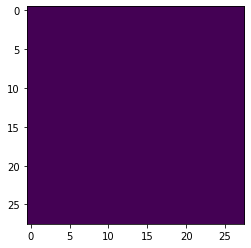

1
l2 dist: 13.115792
target class:  3
pred of adv ex:  3


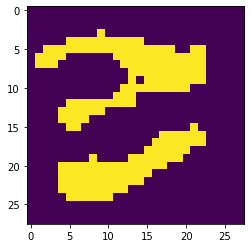

2
l2 dist: 12.773845
target class:  3
pred of adv ex:  3


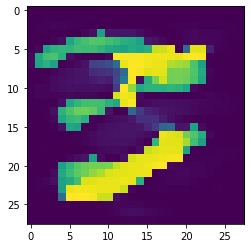

3
l2 dist: 12.417747
target class:  3
pred of adv ex:  3


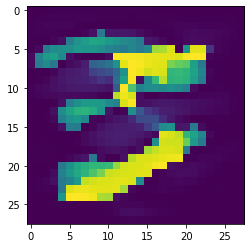

4
l2 dist: 12.056025
target class:  3
pred of adv ex:  3


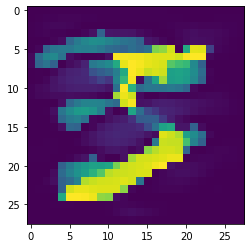

5
l2 dist: 11.69261
target class:  3
pred of adv ex:  3


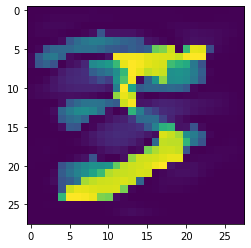

6
l2 dist: 11.329968
target class:  3
pred of adv ex:  3


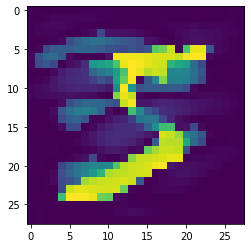

7
l2 dist: 10.969913
target class:  3
pred of adv ex:  3


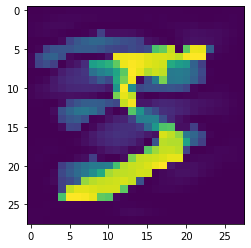

8
l2 dist: 10.613906
target class:  3
pred of adv ex:  3


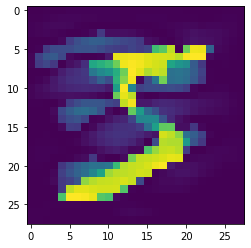

9
l2 dist: 10.263177
target class:  3
pred of adv ex:  3


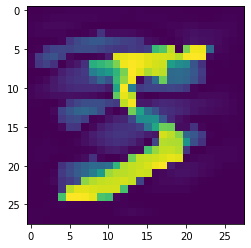

10
l2 dist: 9.918789
target class:  3
pred of adv ex:  3


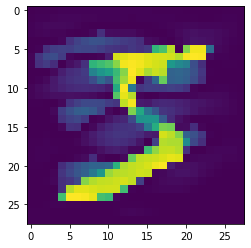

11
l2 dist: 9.581674
target class:  3
pred of adv ex:  3


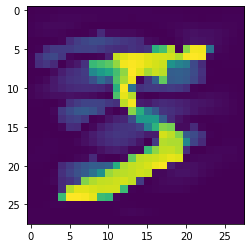

12
l2 dist: 9.252636
target class:  3
pred of adv ex:  5


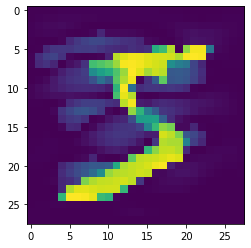

13
l2 dist: 8.946455
target class:  3
pred of adv ex:  5


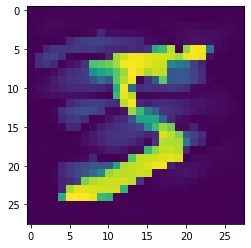

14
l2 dist: 8.660133
target class:  3
pred of adv ex:  3


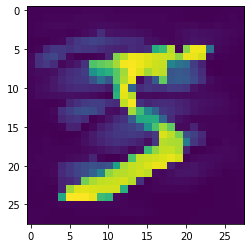

15
l2 dist: 8.381459
target class:  3
pred of adv ex:  3


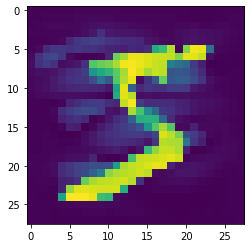

16
l2 dist: 8.110824
target class:  3
pred of adv ex:  3


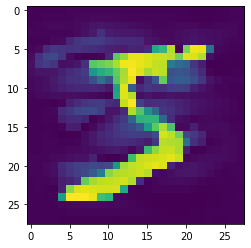

17
l2 dist: 7.848541
target class:  3
pred of adv ex:  3


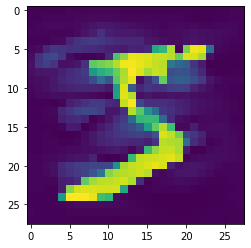

18
l2 dist: 7.5948477
target class:  3
pred of adv ex:  3


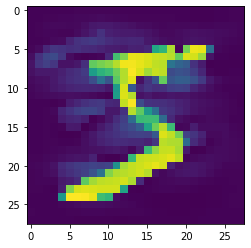

19
l2 dist: 7.3499084
target class:  3
pred of adv ex:  3


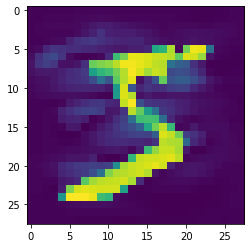

20
l2 dist: 7.1138225
target class:  3
pred of adv ex:  3


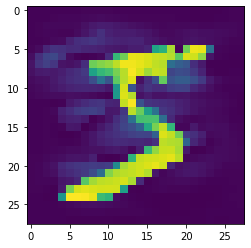

21
l2 dist: 6.886628
target class:  3
pred of adv ex:  3


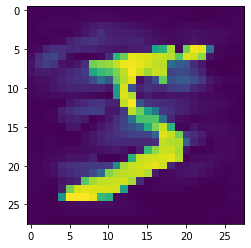

22
l2 dist: 6.668309
target class:  3
pred of adv ex:  5


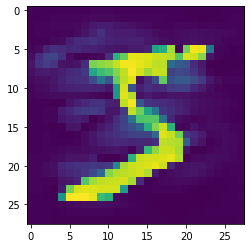

23
l2 dist: 6.479377
target class:  3
pred of adv ex:  3


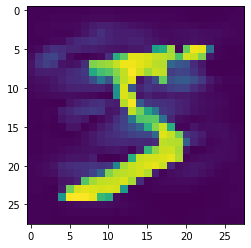

24
l2 dist: 6.298042
target class:  3
pred of adv ex:  3


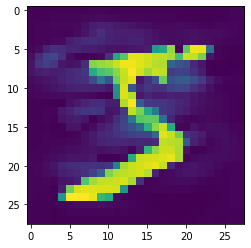

25
l2 dist: 6.1240444
target class:  3
pred of adv ex:  3


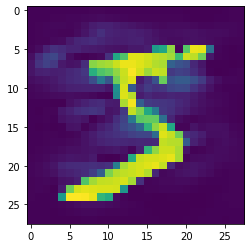

26
l2 dist: 5.9571238
target class:  3
pred of adv ex:  3


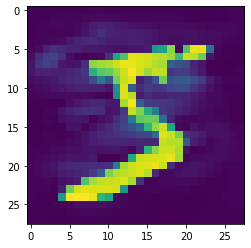

27
l2 dist: 5.7970243
target class:  3
pred of adv ex:  3


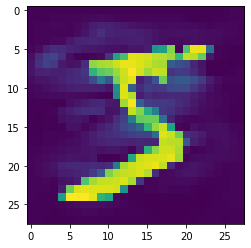

28
l2 dist: 5.64349
target class:  3
pred of adv ex:  3


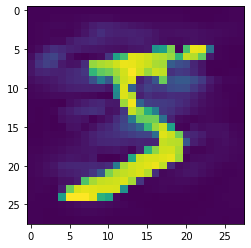

29
l2 dist: 5.4962697
target class:  3
pred of adv ex:  3


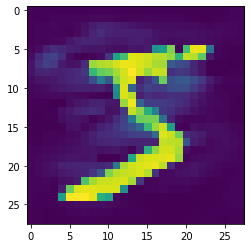

30
l2 dist: 5.3551173
target class:  3
pred of adv ex:  3


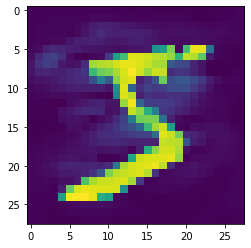

31
l2 dist: 5.219792
target class:  3
pred of adv ex:  3


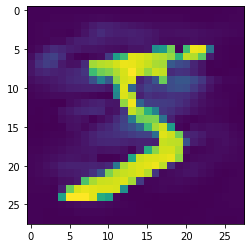

32
l2 dist: 5.0900593
target class:  3
pred of adv ex:  3


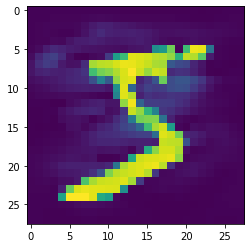

33
l2 dist: 4.965692
target class:  3
pred of adv ex:  3


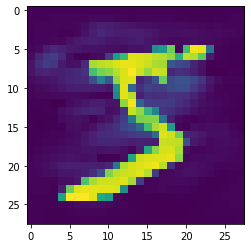

34
l2 dist: 4.8464704
target class:  3
pred of adv ex:  5


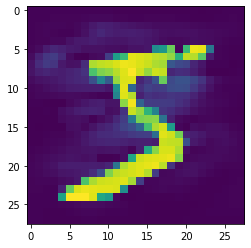

35
l2 dist: 4.747811
target class:  3
pred of adv ex:  3


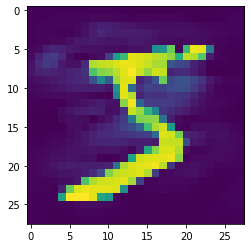

36
l2 dist: 4.653061
target class:  3
pred of adv ex:  3


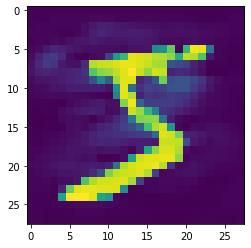

37
l2 dist: 4.5619025
target class:  3
pred of adv ex:  3


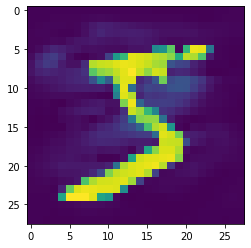

38
l2 dist: 4.4740624
target class:  3
pred of adv ex:  3


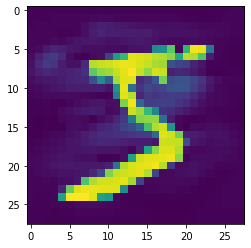

39
l2 dist: 4.3893046
target class:  3
pred of adv ex:  3


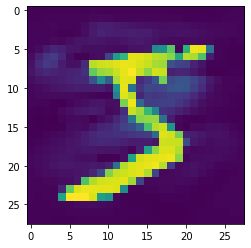

40
l2 dist: 4.3074284
target class:  3
pred of adv ex:  3


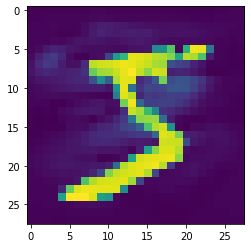

41
l2 dist: 4.22826
target class:  3
pred of adv ex:  3


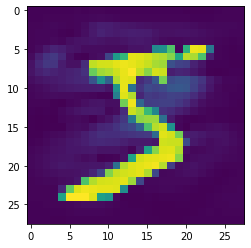

42
l2 dist: 4.1516514
target class:  3
pred of adv ex:  3


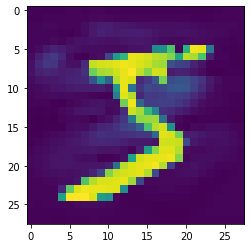

43
l2 dist: 4.077474
target class:  3
pred of adv ex:  3


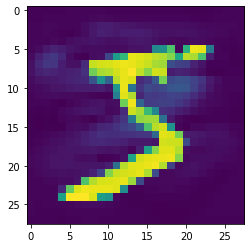

44
l2 dist: 4.005617
target class:  3
pred of adv ex:  3


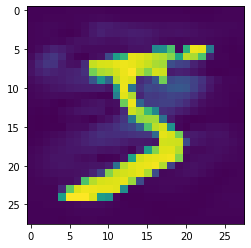

45
l2 dist: 3.935983
target class:  3
pred of adv ex:  3


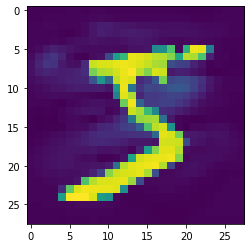

46
l2 dist: 3.8684855
target class:  3
pred of adv ex:  3


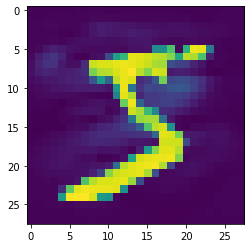

47
l2 dist: 3.8030477
target class:  3
pred of adv ex:  3


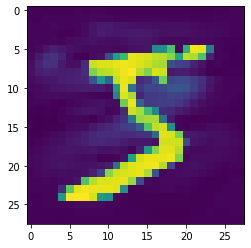

48
l2 dist: 3.7395992
target class:  3
pred of adv ex:  3


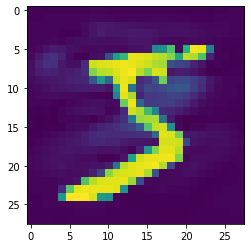

49
l2 dist: 3.6780758
target class:  3
pred of adv ex:  3


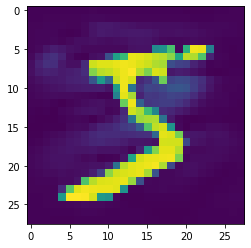

50
l2 dist: 3.6184182
target class:  3
pred of adv ex:  3


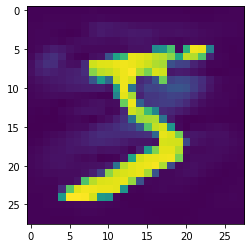

51
l2 dist: 3.5605705
target class:  3
pred of adv ex:  3


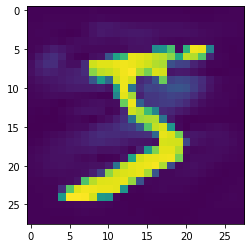

52
l2 dist: 3.50448
target class:  3
pred of adv ex:  5


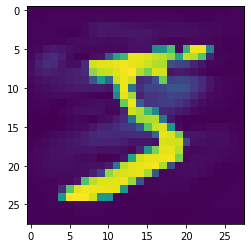

53
l2 dist: 3.4639928
target class:  3
pred of adv ex:  3


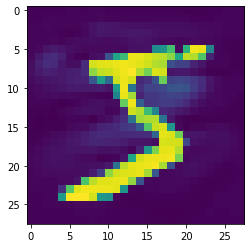

54
l2 dist: 3.4240851
target class:  3
pred of adv ex:  3


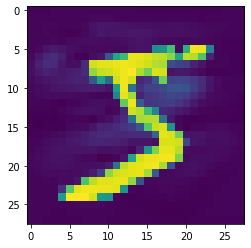

55
l2 dist: 3.3846853
target class:  3
pred of adv ex:  3


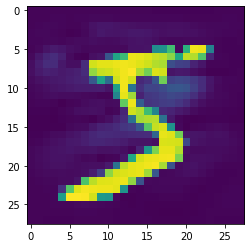

56
l2 dist: 3.3457422
target class:  3
pred of adv ex:  3


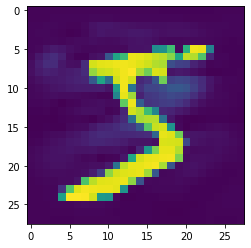

57
l2 dist: 3.3072221
target class:  3
pred of adv ex:  3


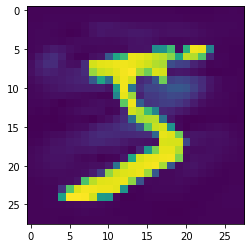

58
l2 dist: 3.2691057
target class:  3
pred of adv ex:  3


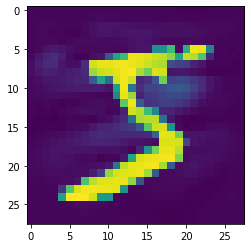

59
l2 dist: 3.2313855
target class:  3
pred of adv ex:  3


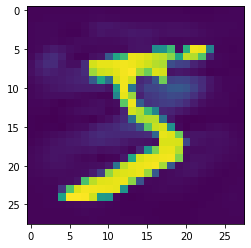

60
l2 dist: 3.194064
target class:  3
pred of adv ex:  3


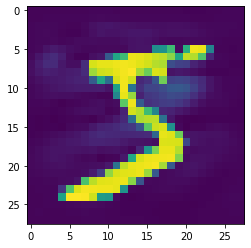

61
l2 dist: 3.1571505
target class:  3
pred of adv ex:  3


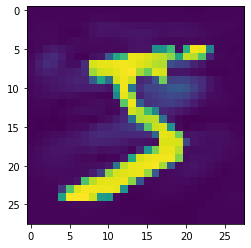

62
l2 dist: 3.1206608
target class:  3
pred of adv ex:  3


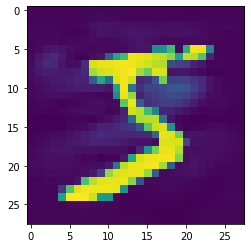

63
l2 dist: 3.0846133
target class:  3
pred of adv ex:  3


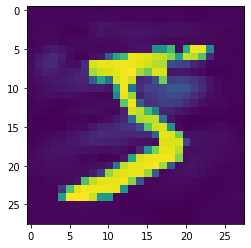

64
l2 dist: 3.0490294
target class:  3
pred of adv ex:  3


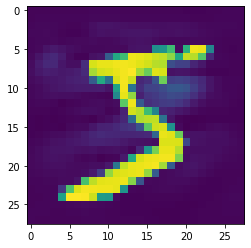

65
l2 dist: 3.0139306
target class:  3
pred of adv ex:  3


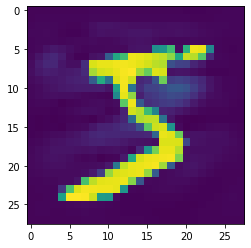

66
l2 dist: 2.979339
target class:  3
pred of adv ex:  5


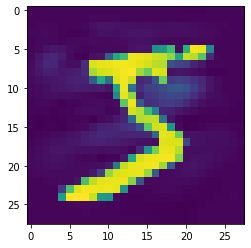

67
l2 dist: 2.9604373
target class:  3
pred of adv ex:  3


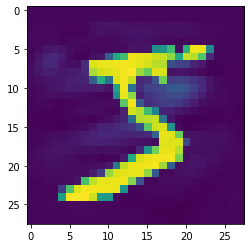

68
l2 dist: 2.9409287
target class:  3
pred of adv ex:  3


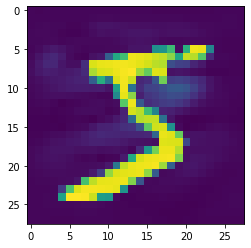

69
l2 dist: 2.9207892
target class:  3
pred of adv ex:  3


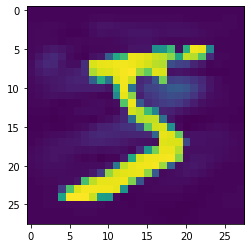

70
l2 dist: 2.9000206
target class:  3
pred of adv ex:  3


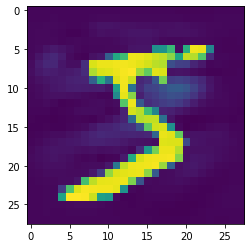

71
l2 dist: 2.8786433
target class:  3
pred of adv ex:  3


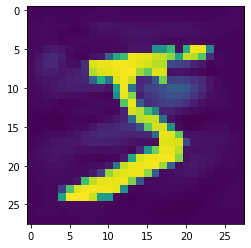

72
l2 dist: 2.8566945
target class:  3
pred of adv ex:  3


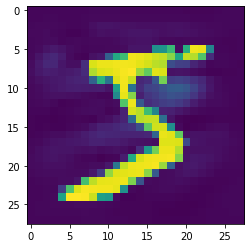

73
l2 dist: 2.8342218
target class:  3
pred of adv ex:  3


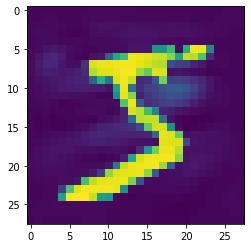

74
l2 dist: 2.8112833
target class:  3
pred of adv ex:  3


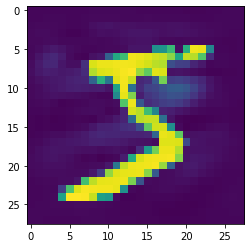

75
l2 dist: 2.7879412
target class:  3
pred of adv ex:  3


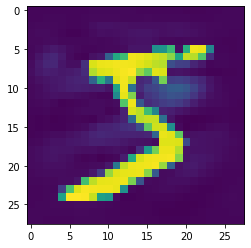

76
l2 dist: 2.764262
target class:  3
pred of adv ex:  3


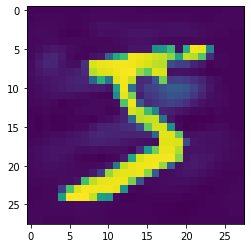

77
l2 dist: 2.7403123
target class:  3
pred of adv ex:  3


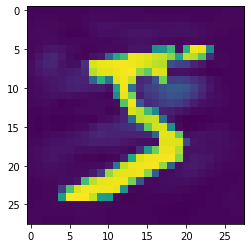

78
l2 dist: 2.7161584
target class:  3
pred of adv ex:  3


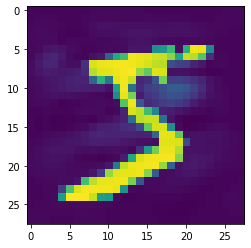

79
l2 dist: 2.6918645
target class:  3
pred of adv ex:  3


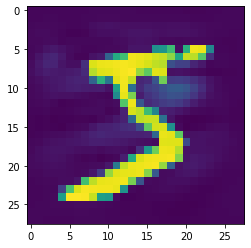

80
l2 dist: 2.6674922
target class:  3
pred of adv ex:  3


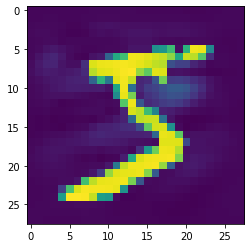

81
l2 dist: 2.6430979
target class:  3
pred of adv ex:  3


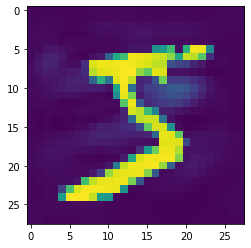

82
l2 dist: 2.6187348
target class:  3
pred of adv ex:  3


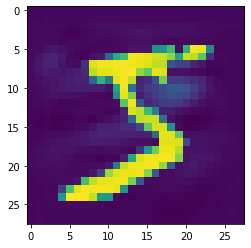

83
l2 dist: 2.5944512
target class:  3
pred of adv ex:  5


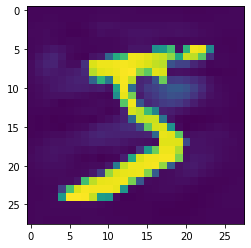

84
l2 dist: 2.5867848
target class:  3
pred of adv ex:  3


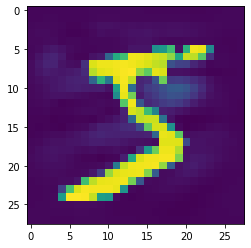

85
l2 dist: 2.5779207
target class:  3
pred of adv ex:  3


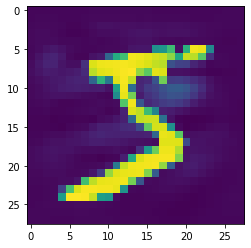

86
l2 dist: 2.5678842
target class:  3
pred of adv ex:  3


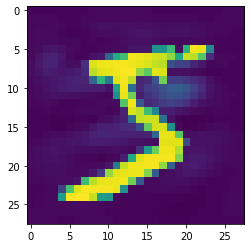

87
l2 dist: 2.5567203
target class:  3
pred of adv ex:  3


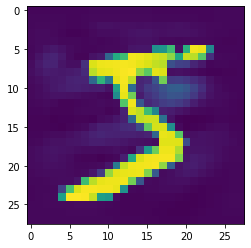

88
l2 dist: 2.5444882
target class:  3
pred of adv ex:  3


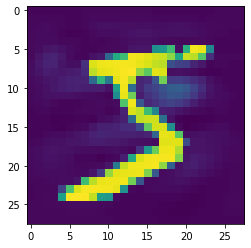

89
l2 dist: 2.531258
target class:  3
pred of adv ex:  3


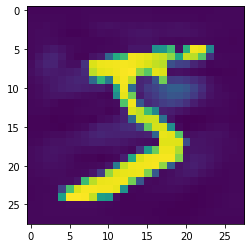

90
l2 dist: 2.5171084
target class:  3
pred of adv ex:  3


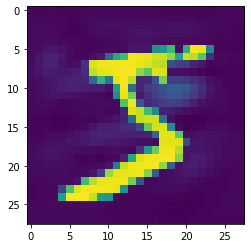

91
l2 dist: 2.5021226
target class:  3
pred of adv ex:  3


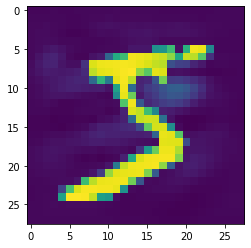

92
l2 dist: 2.4863877
target class:  3
pred of adv ex:  3


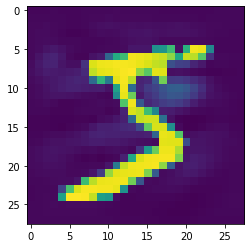

93
l2 dist: 2.4699907
target class:  3
pred of adv ex:  3


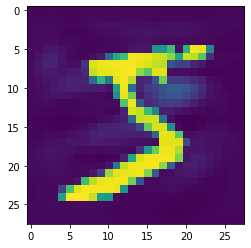

94
l2 dist: 2.4530182
target class:  3
pred of adv ex:  3


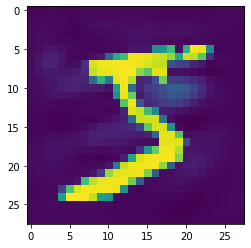

95
l2 dist: 2.4355545
target class:  3
pred of adv ex:  3


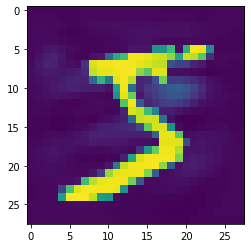

96
l2 dist: 2.417681
target class:  3
pred of adv ex:  3


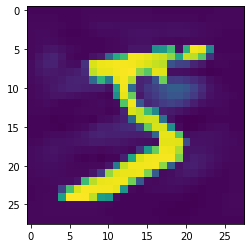

97
l2 dist: 2.399474
target class:  3
pred of adv ex:  3


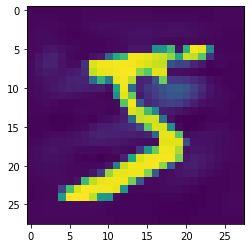

98
l2 dist: 2.3810053
target class:  3
pred of adv ex:  3


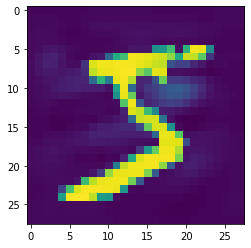

99
l2 dist: 2.3623414
target class:  3
pred of adv ex:  3


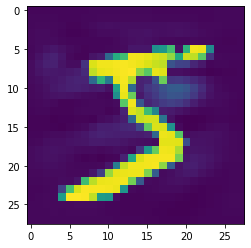

100
l2 dist: 2.3435433
target class:  3
pred of adv ex:  3


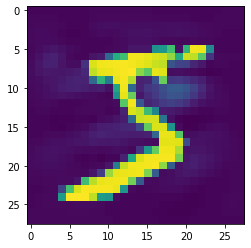

101
l2 dist: 2.3246663
target class:  3
pred of adv ex:  5


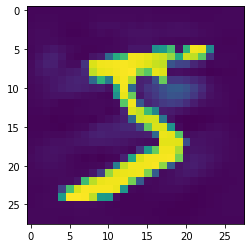

102
l2 dist: 2.3229954
target class:  3
pred of adv ex:  3


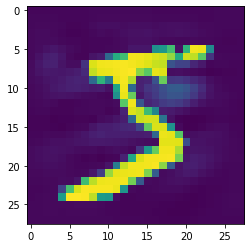

103
l2 dist: 2.3198678
target class:  3
pred of adv ex:  3


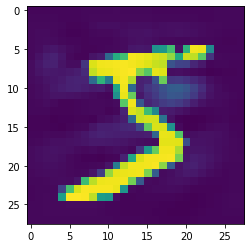

104
l2 dist: 2.315327
target class:  3
pred of adv ex:  3


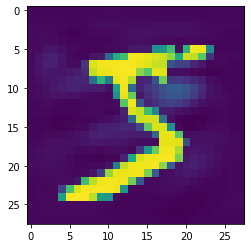

105
l2 dist: 2.3094344
target class:  3
pred of adv ex:  3


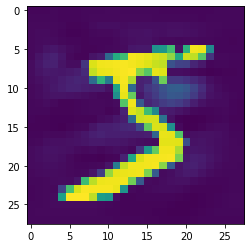

106
l2 dist: 2.3022647
target class:  3
pred of adv ex:  3


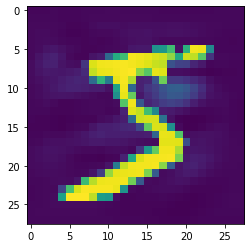

107
l2 dist: 2.2939024
target class:  3
pred of adv ex:  3


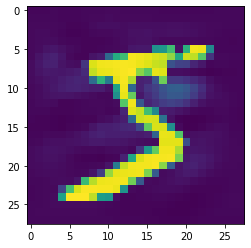

108
l2 dist: 2.2844388
target class:  3
pred of adv ex:  3


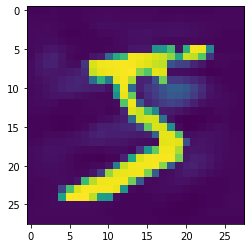

109
l2 dist: 2.2739697
target class:  3
pred of adv ex:  3


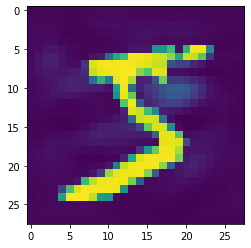

110
l2 dist: 2.2625918
target class:  3
pred of adv ex:  3


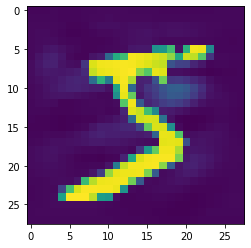

111
l2 dist: 2.2504027
target class:  3
pred of adv ex:  3


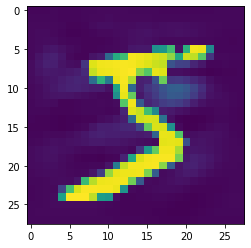

112
l2 dist: 2.237497
target class:  3
pred of adv ex:  3


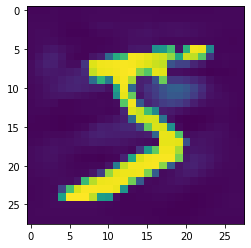

113
l2 dist: 2.2239676
target class:  3
pred of adv ex:  3


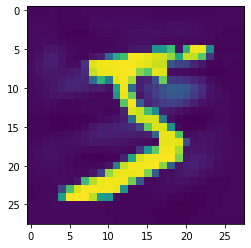

114
l2 dist: 2.2099018
target class:  3
pred of adv ex:  3


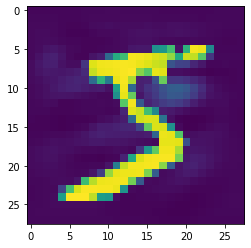

115
l2 dist: 2.1953833
target class:  3
pred of adv ex:  3


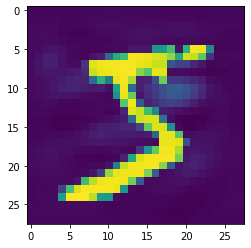

116
l2 dist: 2.1804888
target class:  3
pred of adv ex:  3


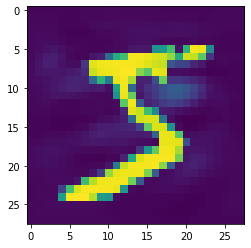

117
l2 dist: 2.1652908
target class:  3
pred of adv ex:  3


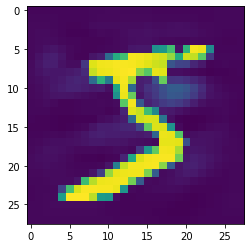

118
l2 dist: 2.1498547
target class:  3
pred of adv ex:  3


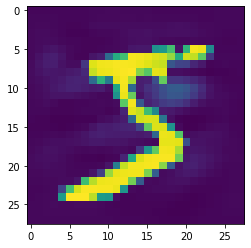

119
l2 dist: 2.1342397
target class:  3
pred of adv ex:  5


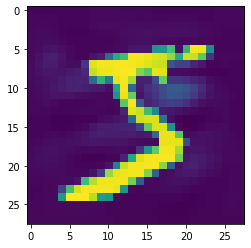

120
l2 dist: 2.1366475
target class:  3
pred of adv ex:  3


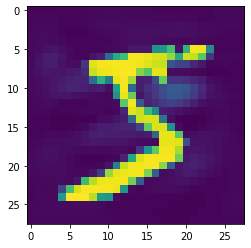

121
l2 dist: 2.1374204
target class:  3
pred of adv ex:  3


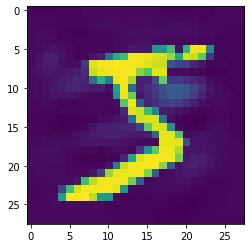

122
l2 dist: 2.136608
target class:  3
pred of adv ex:  3


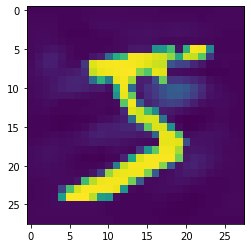

123
l2 dist: 2.134277
target class:  3
pred of adv ex:  3


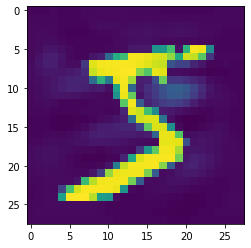

124
l2 dist: 2.1305103
target class:  3
pred of adv ex:  3


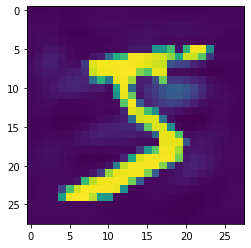

125
l2 dist: 2.1253998
target class:  3
pred of adv ex:  3


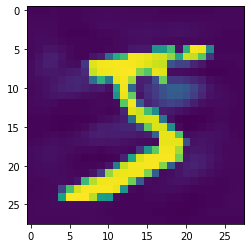

126
l2 dist: 2.119045
target class:  3
pred of adv ex:  3


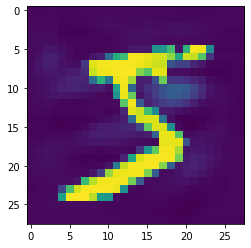

127
l2 dist: 2.1115494
target class:  3
pred of adv ex:  3


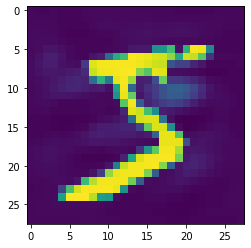

128
l2 dist: 2.103018
target class:  3
pred of adv ex:  3


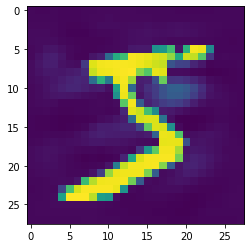

129
l2 dist: 2.0935562
target class:  3
pred of adv ex:  3


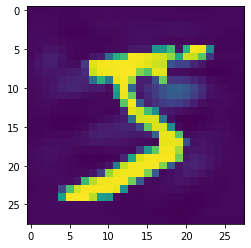

130
l2 dist: 2.0832667
target class:  3
pred of adv ex:  3


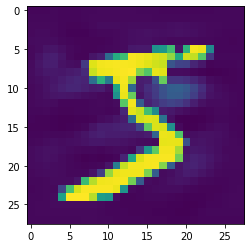

131
l2 dist: 2.0722492
target class:  3
pred of adv ex:  3


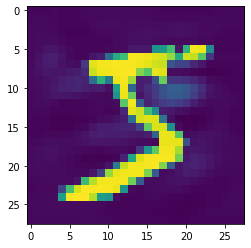

132
l2 dist: 2.0605989
target class:  3
pred of adv ex:  3


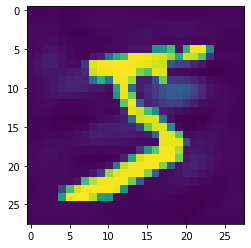

133
l2 dist: 2.0484052
target class:  3
pred of adv ex:  3


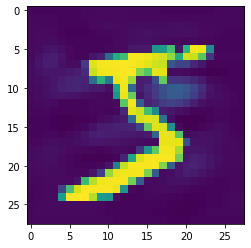

134
l2 dist: 2.035752
target class:  3
pred of adv ex:  3


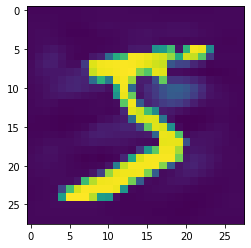

135
l2 dist: 2.022717
target class:  3
pred of adv ex:  3


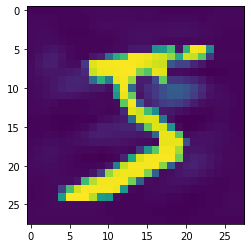

136
l2 dist: 2.0093706
target class:  3
pred of adv ex:  3


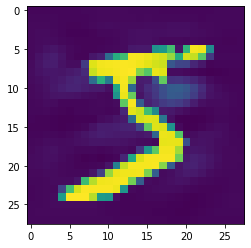

137
l2 dist: 1.9957781
target class:  3
pred of adv ex:  3


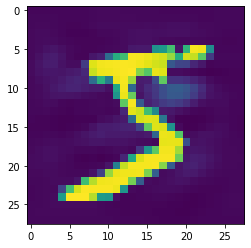

138
l2 dist: 1.9819973
target class:  3
pred of adv ex:  5


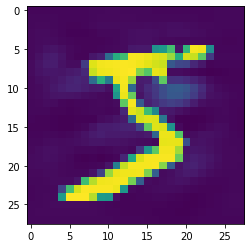

139
l2 dist: 1.9872652
target class:  3
pred of adv ex:  3


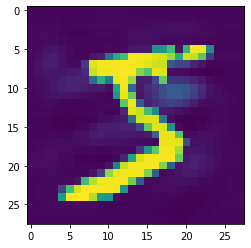

140
l2 dist: 1.9907802
target class:  3
pred of adv ex:  3


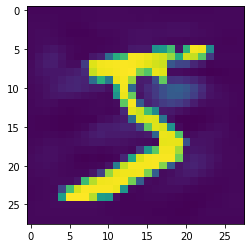

141
l2 dist: 1.9925942
target class:  3
pred of adv ex:  3


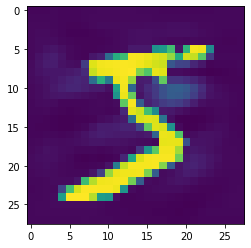

142
l2 dist: 1.9927783
target class:  3
pred of adv ex:  3


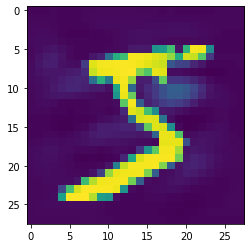

143
l2 dist: 1.9914191
target class:  3
pred of adv ex:  3


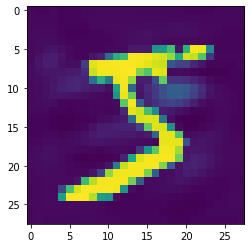

144
l2 dist: 1.9886134
target class:  3
pred of adv ex:  3


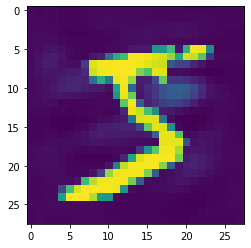

145
l2 dist: 1.9844655
target class:  3
pred of adv ex:  3


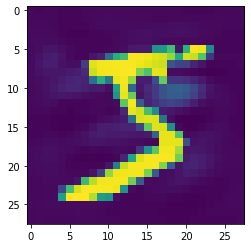

146
l2 dist: 1.9790846
target class:  3
pred of adv ex:  3


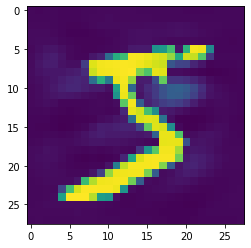

147
l2 dist: 1.9725811
target class:  3
pred of adv ex:  3


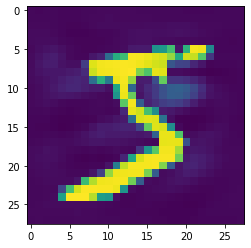

148
l2 dist: 1.9650657
target class:  3
pred of adv ex:  3


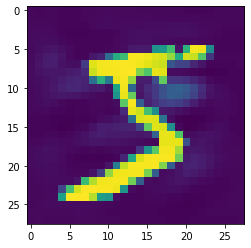

149
l2 dist: 1.9566466
target class:  3
pred of adv ex:  3


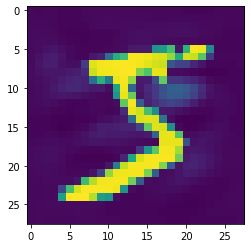

150
l2 dist: 1.9474285
target class:  3
pred of adv ex:  3


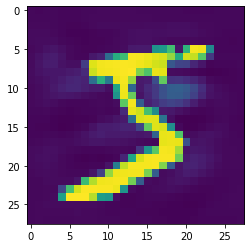

151
l2 dist: 1.9375117
target class:  3
pred of adv ex:  3


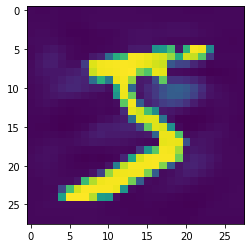

152
l2 dist: 1.9269904
target class:  3
pred of adv ex:  3


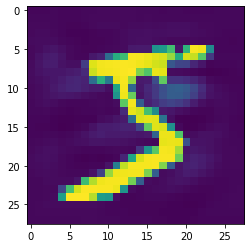

153
l2 dist: 1.9159534
target class:  3
pred of adv ex:  3


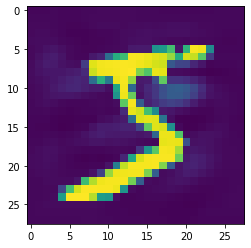

154
l2 dist: 1.9044819
target class:  3
pred of adv ex:  3


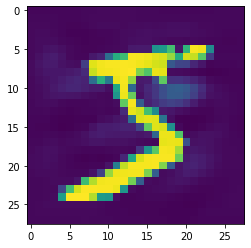

155
l2 dist: 1.8926507
target class:  3
pred of adv ex:  3


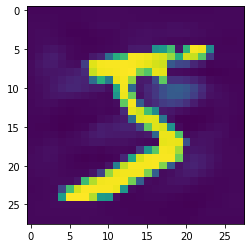

156
l2 dist: 1.880528
target class:  3
pred of adv ex:  3


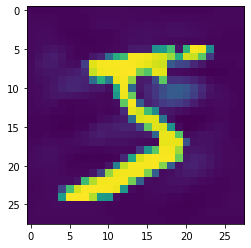

157
l2 dist: 1.868175
target class:  3
pred of adv ex:  5


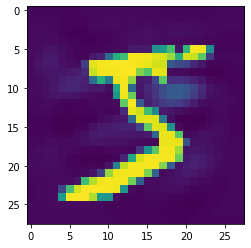

158
l2 dist: 1.876047
target class:  3
pred of adv ex:  3


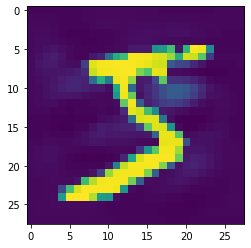

159
l2 dist: 1.8820243
target class:  3
pred of adv ex:  3


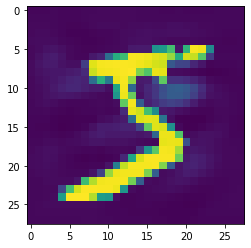

160
l2 dist: 1.886159
target class:  3
pred of adv ex:  3


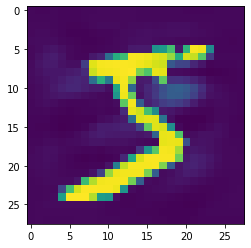

161
l2 dist: 1.8885247
target class:  3
pred of adv ex:  3


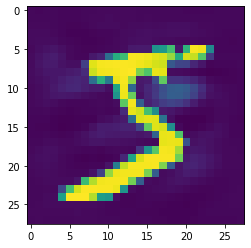

162
l2 dist: 1.8892125
target class:  3
pred of adv ex:  3


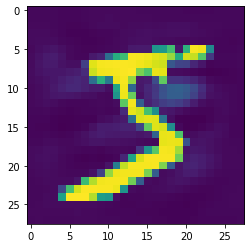

163
l2 dist: 1.8883251
target class:  3
pred of adv ex:  3


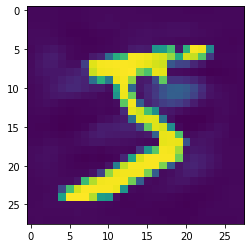

164
l2 dist: 1.8859738
target class:  3
pred of adv ex:  3


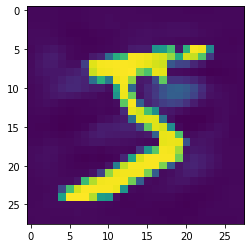

165
l2 dist: 1.8822753
target class:  3
pred of adv ex:  3


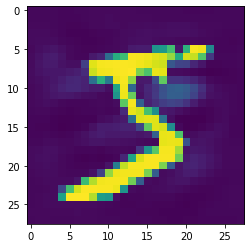

166
l2 dist: 1.8773482
target class:  3
pred of adv ex:  3


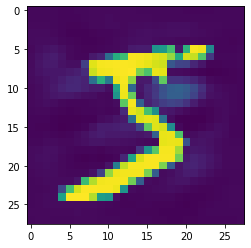

167
l2 dist: 1.871311
target class:  3
pred of adv ex:  3


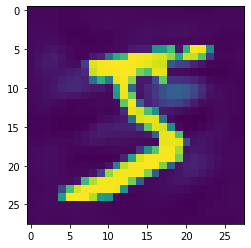

168
l2 dist: 1.8642805
target class:  3
pred of adv ex:  3


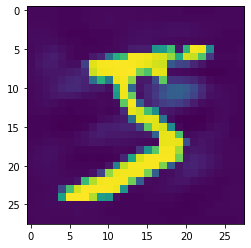

169
l2 dist: 1.8563693
target class:  3
pred of adv ex:  3


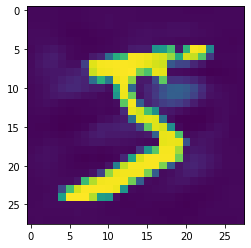

170
l2 dist: 1.8476851
target class:  3
pred of adv ex:  3


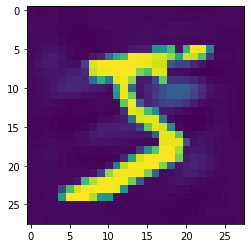

171
l2 dist: 1.8383293
target class:  3
pred of adv ex:  3


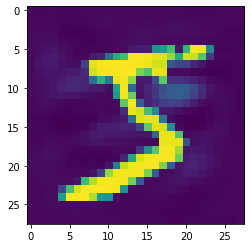

172
l2 dist: 1.828397
target class:  3
pred of adv ex:  3


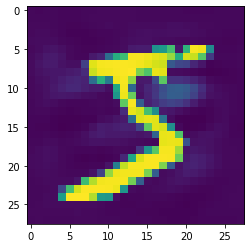

173
l2 dist: 1.817976
target class:  3
pred of adv ex:  3


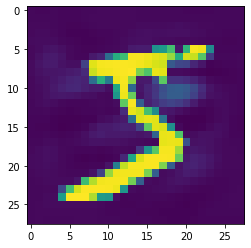

174
l2 dist: 1.8071462
target class:  3
pred of adv ex:  3


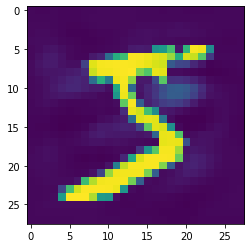

175
l2 dist: 1.7959805
target class:  3
pred of adv ex:  3


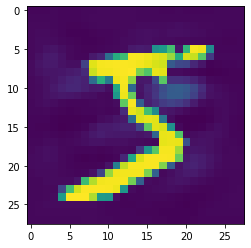

176
l2 dist: 1.7845448
target class:  3
pred of adv ex:  3


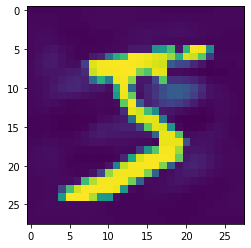

177
l2 dist: 1.7728978
target class:  3
pred of adv ex:  3


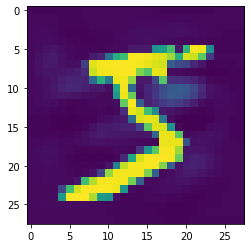

178
l2 dist: 1.7610921
target class:  3
pred of adv ex:  5


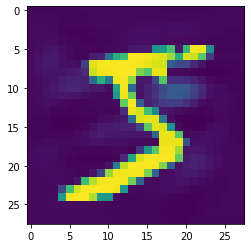

179
l2 dist: 1.7705789
target class:  3
pred of adv ex:  3


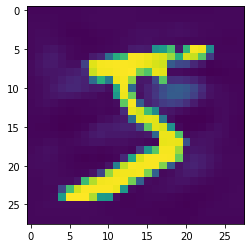

180
l2 dist: 1.7781303
target class:  3
pred of adv ex:  3


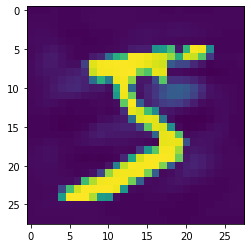

181
l2 dist: 1.783796
target class:  3
pred of adv ex:  3


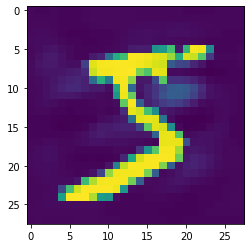

182
l2 dist: 1.7876483
target class:  3
pred of adv ex:  3


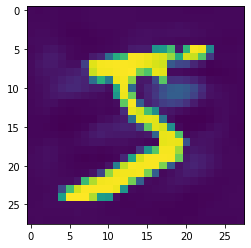

183
l2 dist: 1.7897761
target class:  3
pred of adv ex:  3


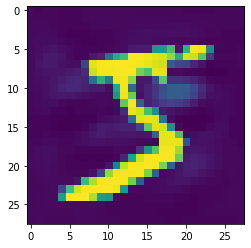

184
l2 dist: 1.7902812
target class:  3
pred of adv ex:  3


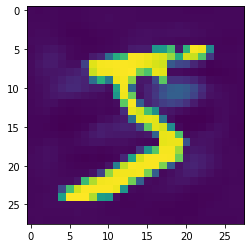

185
l2 dist: 1.7892747
target class:  3
pred of adv ex:  3


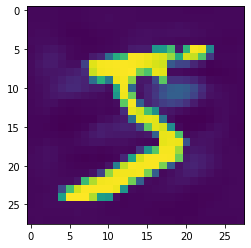

186
l2 dist: 1.7868727
target class:  3
pred of adv ex:  3


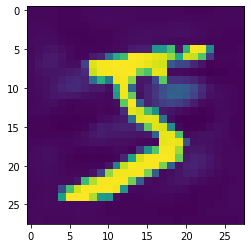

187
l2 dist: 1.7831954
target class:  3
pred of adv ex:  3


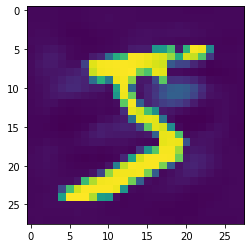

188
l2 dist: 1.7783626
target class:  3
pred of adv ex:  3


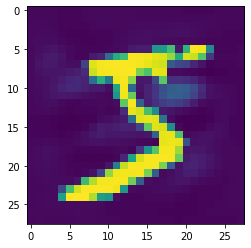

189
l2 dist: 1.7724932
target class:  3
pred of adv ex:  3


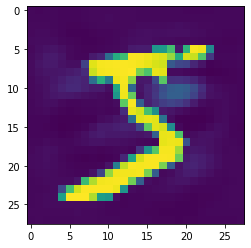

190
l2 dist: 1.7657024
target class:  3
pred of adv ex:  3


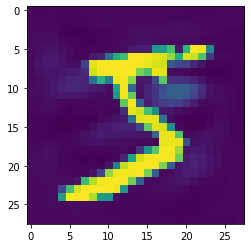

191
l2 dist: 1.7581005
target class:  3
pred of adv ex:  3


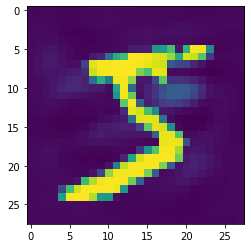

192
l2 dist: 1.7497923
target class:  3
pred of adv ex:  3


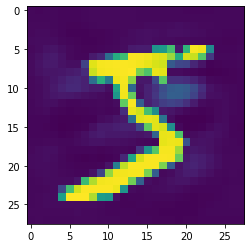

193
l2 dist: 1.7408755
target class:  3
pred of adv ex:  3


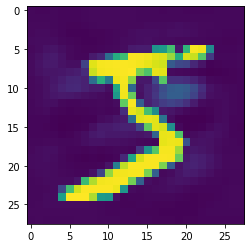

194
l2 dist: 1.7314403
target class:  3
pred of adv ex:  3


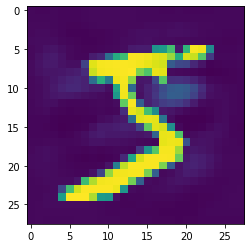

195
l2 dist: 1.7215698
target class:  3
pred of adv ex:  3


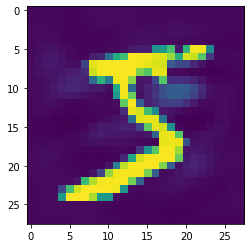

196
l2 dist: 1.7113389
target class:  3
pred of adv ex:  3


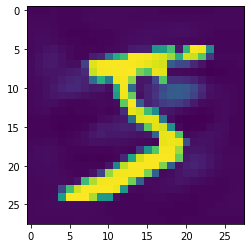

197
l2 dist: 1.7008156
target class:  3
pred of adv ex:  3


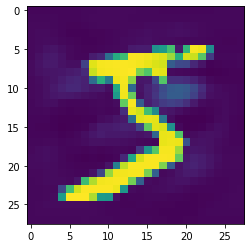

198
l2 dist: 1.6900598
target class:  3
pred of adv ex:  3


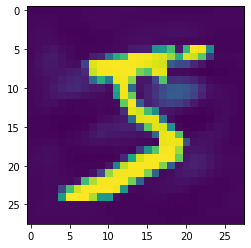

199
l2 dist: 1.6791254
target class:  3
pred of adv ex:  5


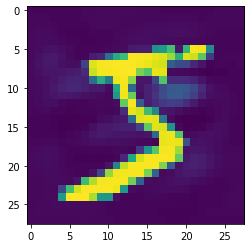

200
l2 dist: 1.6904634
target class:  3
pred of adv ex:  3


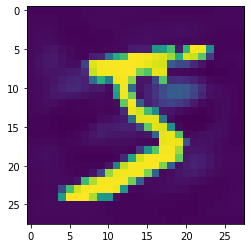

201
l2 dist: 1.6997699
target class:  3
pred of adv ex:  3


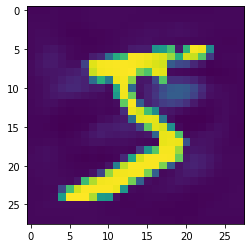

202
l2 dist: 1.707091
target class:  3
pred of adv ex:  3


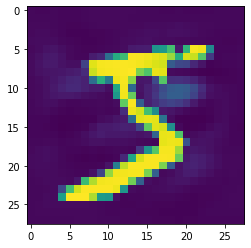

203
l2 dist: 1.7124975
target class:  3
pred of adv ex:  3


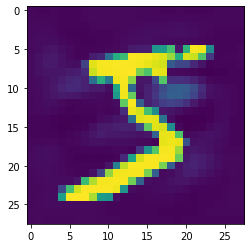

204
l2 dist: 1.7160796
target class:  3
pred of adv ex:  3


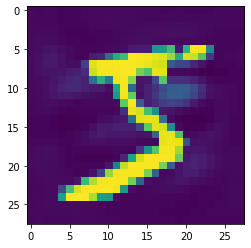

205
l2 dist: 1.7179419
target class:  3
pred of adv ex:  3


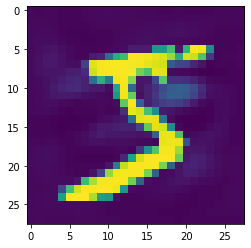

206
l2 dist: 1.7181997
target class:  3
pred of adv ex:  3


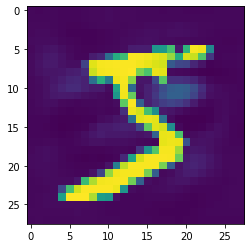

207
l2 dist: 1.7169747
target class:  3
pred of adv ex:  3


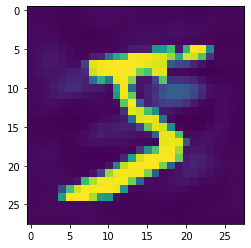

208
l2 dist: 1.7143927
target class:  3
pred of adv ex:  3


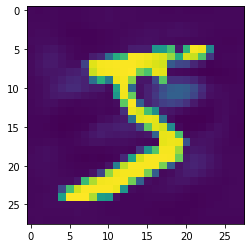

209
l2 dist: 1.71058
target class:  3
pred of adv ex:  3


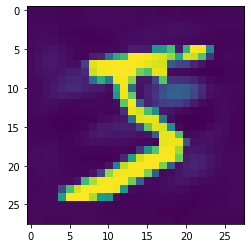

210
l2 dist: 1.705662
target class:  3
pred of adv ex:  3


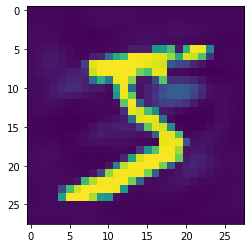

211
l2 dist: 1.6997601
target class:  3
pred of adv ex:  3


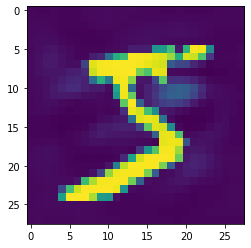

212
l2 dist: 1.6929913
target class:  3
pred of adv ex:  3


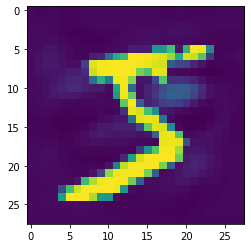

213
l2 dist: 1.6854658
target class:  3
pred of adv ex:  3


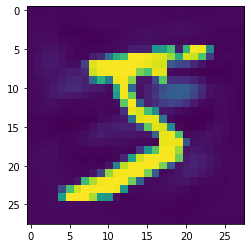

214
l2 dist: 1.6772867
target class:  3
pred of adv ex:  3


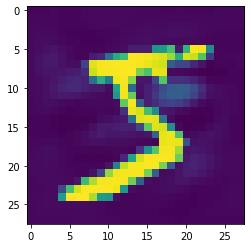

215
l2 dist: 1.6685493
target class:  3
pred of adv ex:  3


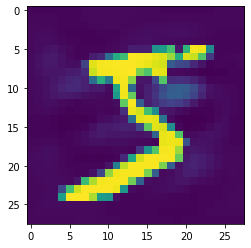

216
l2 dist: 1.6593407
target class:  3
pred of adv ex:  3


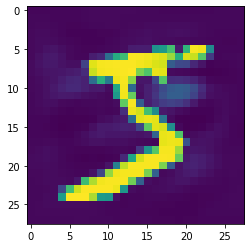

217
l2 dist: 1.6497397
target class:  3
pred of adv ex:  3


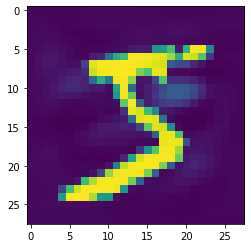

218
l2 dist: 1.6398171
target class:  3
pred of adv ex:  3


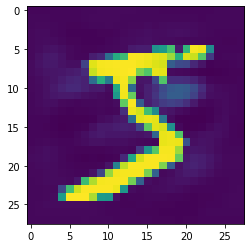

219
l2 dist: 1.6296363
target class:  3
pred of adv ex:  3


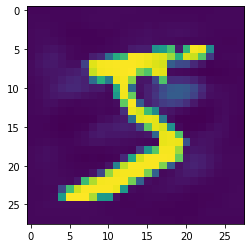

220
l2 dist: 1.6192533
target class:  3
pred of adv ex:  5


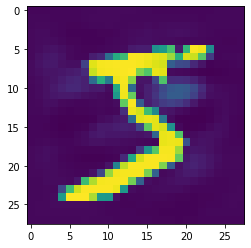

221
l2 dist: 1.6321373
target class:  3
pred of adv ex:  3


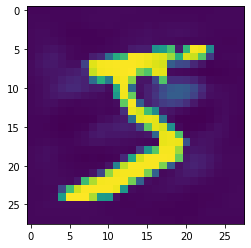

222
l2 dist: 1.6428803
target class:  3
pred of adv ex:  3


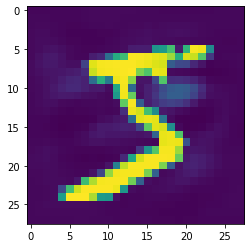

223
l2 dist: 1.6515297
target class:  3
pred of adv ex:  3


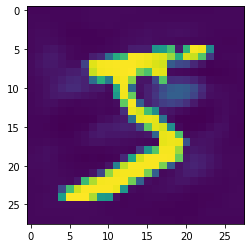

224
l2 dist: 1.6581587
target class:  3
pred of adv ex:  3


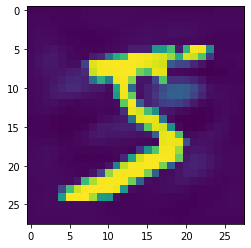

225
l2 dist: 1.6628617
target class:  3
pred of adv ex:  3


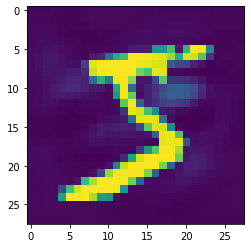

226
l2 dist: 1.6657479
target class:  3
pred of adv ex:  3


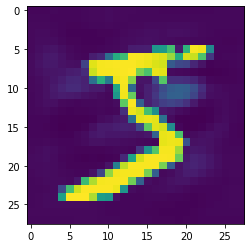

227
l2 dist: 1.6669387
target class:  3
pred of adv ex:  3


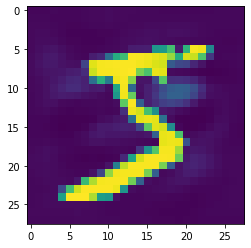

228
l2 dist: 1.6665623
target class:  3
pred of adv ex:  3


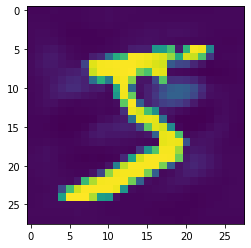

229
l2 dist: 1.6647509
target class:  3
pred of adv ex:  3


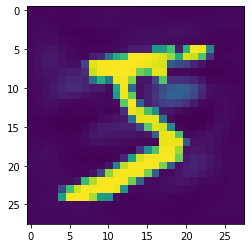

230
l2 dist: 1.6616379
target class:  3
pred of adv ex:  3


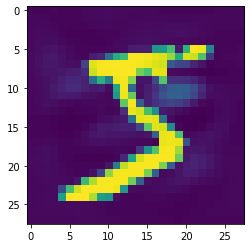

231
l2 dist: 1.6573554
target class:  3
pred of adv ex:  3


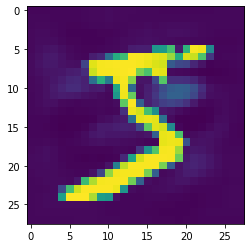

232
l2 dist: 1.6520319
target class:  3
pred of adv ex:  3


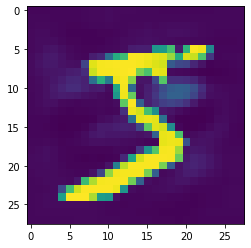

233
l2 dist: 1.6457903
target class:  3
pred of adv ex:  3


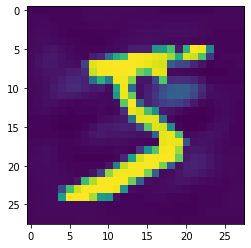

234
l2 dist: 1.638747
target class:  3
pred of adv ex:  3


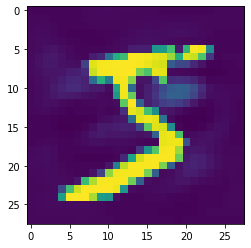

235
l2 dist: 1.6310104
target class:  3
pred of adv ex:  3


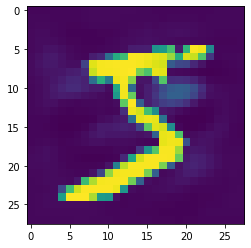

236
l2 dist: 1.6226814
target class:  3
pred of adv ex:  3


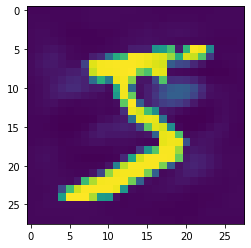

237
l2 dist: 1.6138506
target class:  3
pred of adv ex:  3


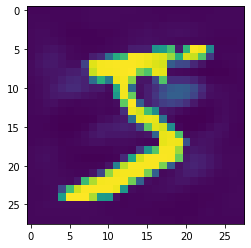

238
l2 dist: 1.6046015
target class:  3
pred of adv ex:  3


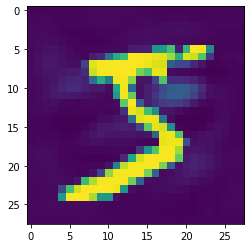

239
l2 dist: 1.5950078
target class:  3
pred of adv ex:  3


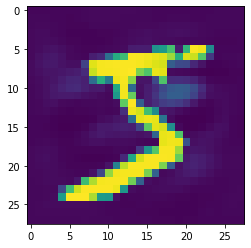

240
l2 dist: 1.5851359
target class:  3
pred of adv ex:  3


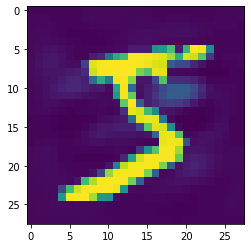

241
l2 dist: 1.5750443
target class:  3
pred of adv ex:  3


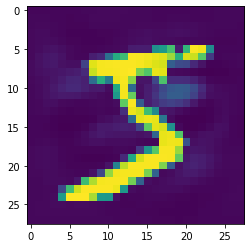

242
l2 dist: 1.5647849
target class:  3
pred of adv ex:  3


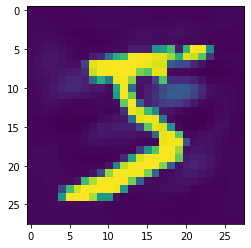

243
l2 dist: 1.5544026
target class:  3
pred of adv ex:  5


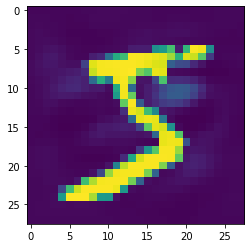

244
l2 dist: 1.5679654
target class:  3
pred of adv ex:  3


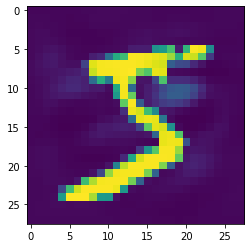

245
l2 dist: 1.5794091
target class:  3
pred of adv ex:  3


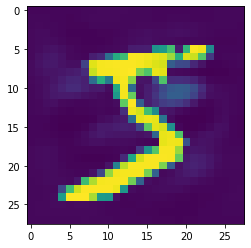

246
l2 dist: 1.5887733
target class:  3
pred of adv ex:  3


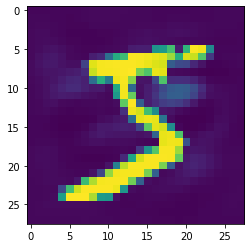

247
l2 dist: 1.5961245
target class:  3
pred of adv ex:  3


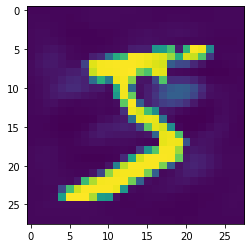

248
l2 dist: 1.6015502
target class:  3
pred of adv ex:  3


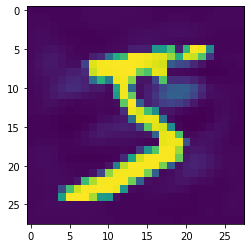

249
l2 dist: 1.6051537
target class:  3
pred of adv ex:  3


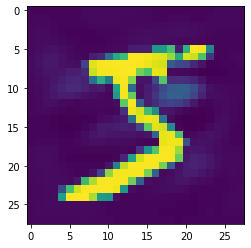

250
l2 dist: 1.6070507
target class:  3
pred of adv ex:  3


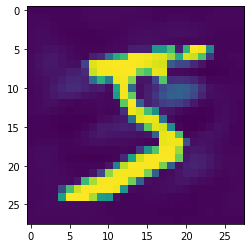

251
l2 dist: 1.6073651
target class:  3
pred of adv ex:  3


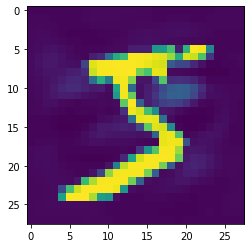

252
l2 dist: 1.6062266
target class:  3
pred of adv ex:  3


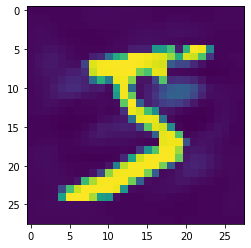

253
l2 dist: 1.6037667
target class:  3
pred of adv ex:  3


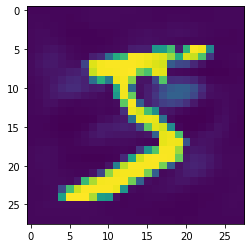

254
l2 dist: 1.6001168
target class:  3
pred of adv ex:  3


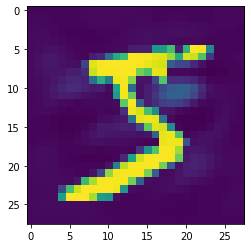

255
l2 dist: 1.5954057
target class:  3
pred of adv ex:  3


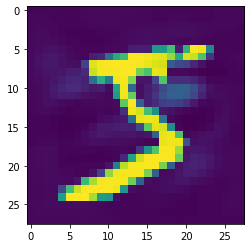

256
l2 dist: 1.5897572
target class:  3
pred of adv ex:  3


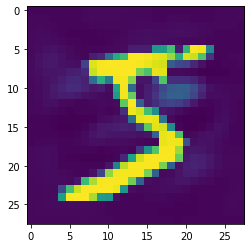

257
l2 dist: 1.5832894
target class:  3
pred of adv ex:  3


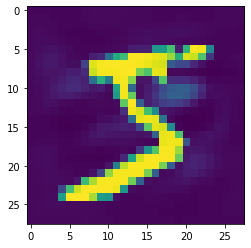

258
l2 dist: 1.5761124
target class:  3
pred of adv ex:  3


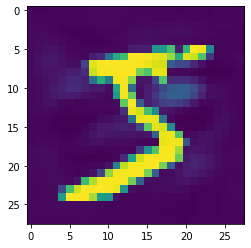

259
l2 dist: 1.568328
target class:  3
pred of adv ex:  3


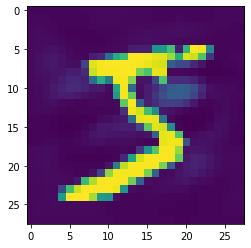

260
l2 dist: 1.5600297
target class:  3
pred of adv ex:  3


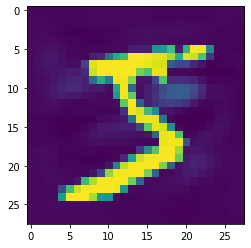

261
l2 dist: 1.5513015
target class:  3
pred of adv ex:  3


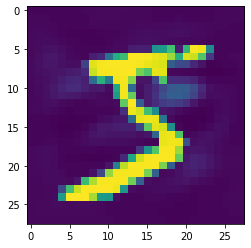

262
l2 dist: 1.5422188
target class:  3
pred of adv ex:  3


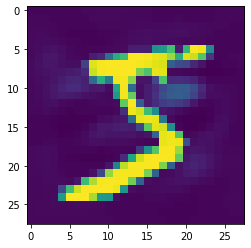

263
l2 dist: 1.5328484
target class:  3
pred of adv ex:  3


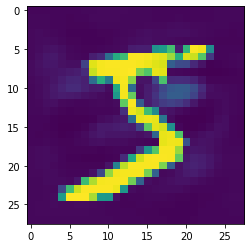

264
l2 dist: 1.5232494
target class:  3
pred of adv ex:  3


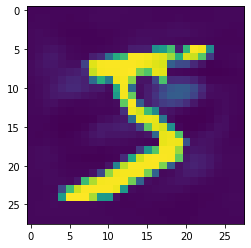

265
l2 dist: 1.5134736
target class:  3
pred of adv ex:  5


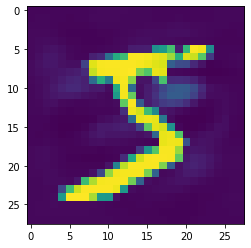

266
l2 dist: 1.528464
target class:  3
pred of adv ex:  3


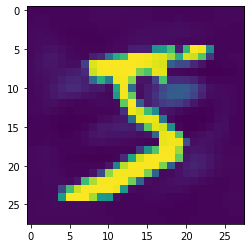

267
l2 dist: 1.541214
target class:  3
pred of adv ex:  3


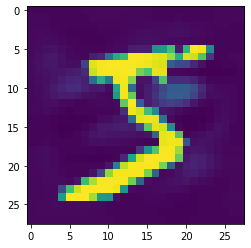

268
l2 dist: 1.5517644
target class:  3
pred of adv ex:  3


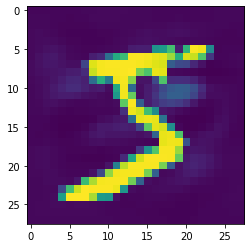

269
l2 dist: 1.5601847
target class:  3
pred of adv ex:  3


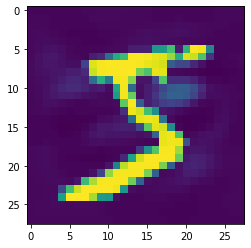

270
l2 dist: 1.5665683
target class:  3
pred of adv ex:  3


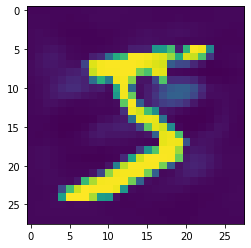

271
l2 dist: 1.5710257
target class:  3
pred of adv ex:  3


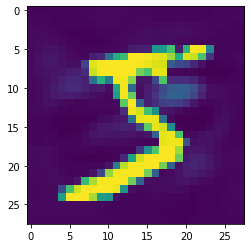

272
l2 dist: 1.5736808
target class:  3
pred of adv ex:  3


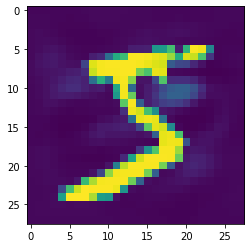

273
l2 dist: 1.5746664
target class:  3
pred of adv ex:  3


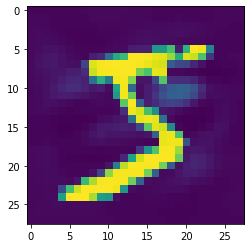

274
l2 dist: 1.5741204
target class:  3
pred of adv ex:  3


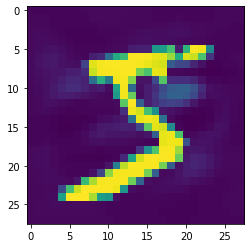

275
l2 dist: 1.572183
target class:  3
pred of adv ex:  3


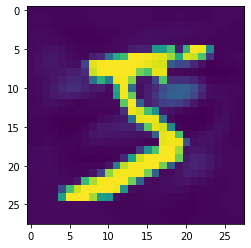

276
l2 dist: 1.5689933
target class:  3
pred of adv ex:  3


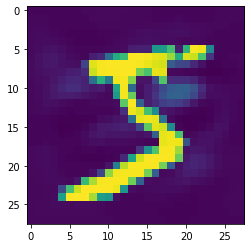

277
l2 dist: 1.564687
target class:  3
pred of adv ex:  3


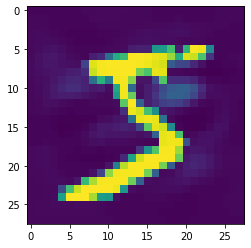

278
l2 dist: 1.559395
target class:  3
pred of adv ex:  3


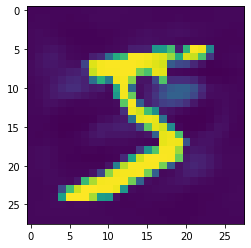

279
l2 dist: 1.5532407
target class:  3
pred of adv ex:  3


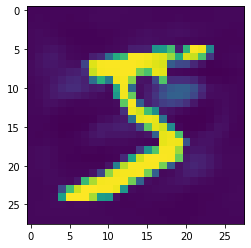

280
l2 dist: 1.5463393
target class:  3
pred of adv ex:  3


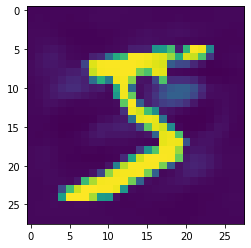

281
l2 dist: 1.5387976
target class:  3
pred of adv ex:  3


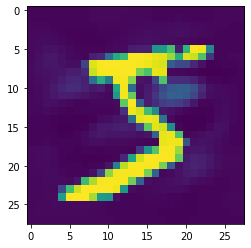

282
l2 dist: 1.5307126
target class:  3
pred of adv ex:  3


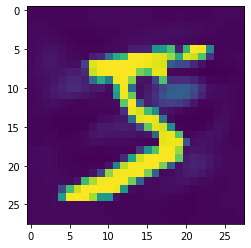

283
l2 dist: 1.5221721
target class:  3
pred of adv ex:  3


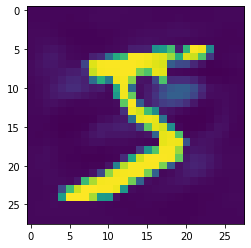

284
l2 dist: 1.5132543
target class:  3
pred of adv ex:  3


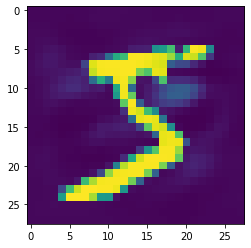

285
l2 dist: 1.504029
target class:  3
pred of adv ex:  3


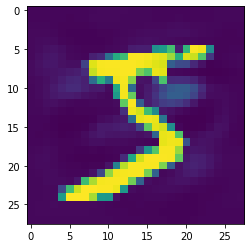

286
l2 dist: 1.4945579
target class:  3
pred of adv ex:  3


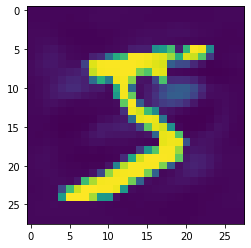

287
l2 dist: 1.4848946
target class:  3
pred of adv ex:  3


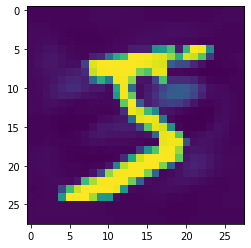

288
l2 dist: 1.475087
target class:  3
pred of adv ex:  3


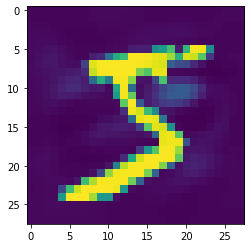

289
l2 dist: 1.4651765
target class:  3
pred of adv ex:  5


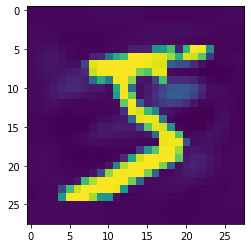

290
l2 dist: 1.4804462
target class:  3
pred of adv ex:  3


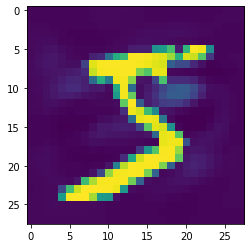

291
l2 dist: 1.4935267
target class:  3
pred of adv ex:  3


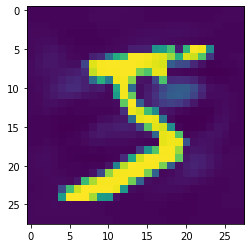

292
l2 dist: 1.5044498
target class:  3
pred of adv ex:  3


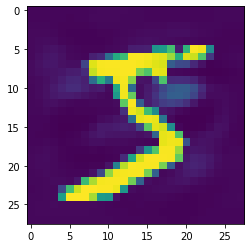

293
l2 dist: 1.513276
target class:  3
pred of adv ex:  3


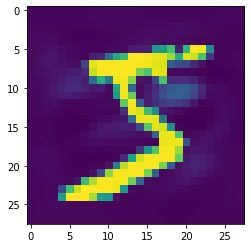

294
l2 dist: 1.5200887
target class:  3
pred of adv ex:  3


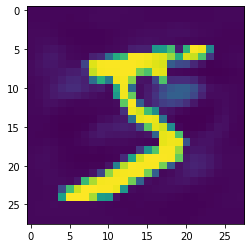

295
l2 dist: 1.5249896
target class:  3
pred of adv ex:  3


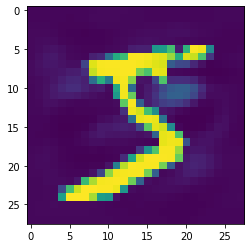

296
l2 dist: 1.528095
target class:  3
pred of adv ex:  3


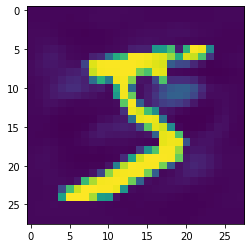

297
l2 dist: 1.5295314
target class:  3
pred of adv ex:  3


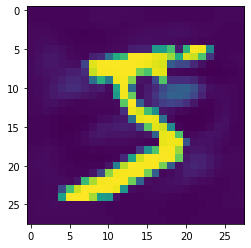

298
l2 dist: 1.5294316
target class:  3
pred of adv ex:  3


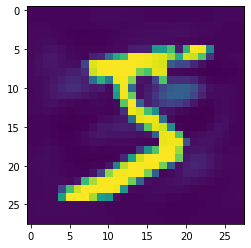

299
l2 dist: 1.5279326
target class:  3
pred of adv ex:  3


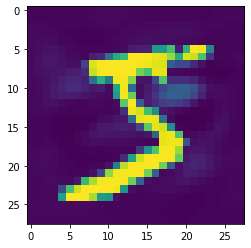

300
l2 dist: 1.5251713
target class:  3
pred of adv ex:  3


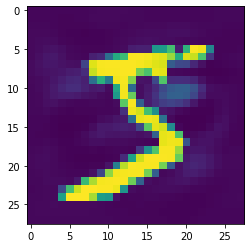

301
l2 dist: 1.5212833
target class:  3
pred of adv ex:  3


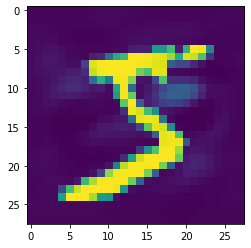

302
l2 dist: 1.5163985
target class:  3
pred of adv ex:  3


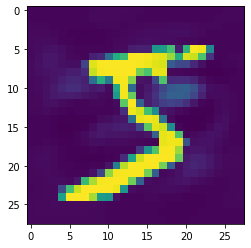

303
l2 dist: 1.5106419
target class:  3
pred of adv ex:  3


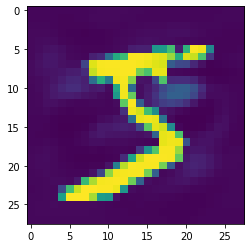

304
l2 dist: 1.5041301
target class:  3
pred of adv ex:  3


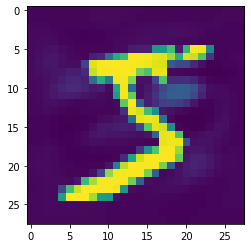

305
l2 dist: 1.4969708
target class:  3
pred of adv ex:  3


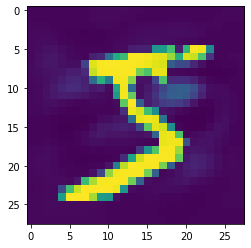

306
l2 dist: 1.4892623
target class:  3
pred of adv ex:  3


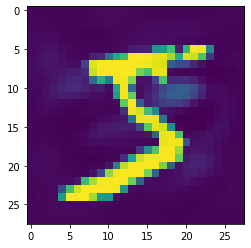

307
l2 dist: 1.4810938
target class:  3
pred of adv ex:  3


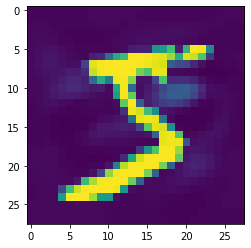

308
l2 dist: 1.4725441
target class:  3
pred of adv ex:  3


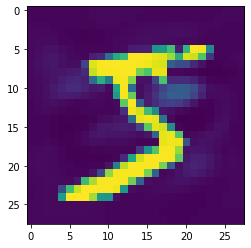

309
l2 dist: 1.4636838
target class:  3
pred of adv ex:  3


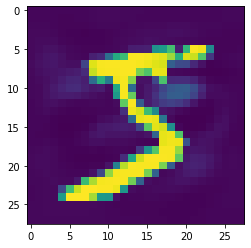

310
l2 dist: 1.4545742
target class:  3
pred of adv ex:  3


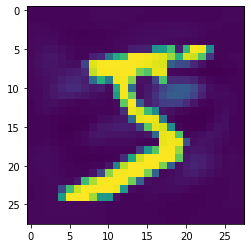

311
l2 dist: 1.4452693
target class:  3
pred of adv ex:  3


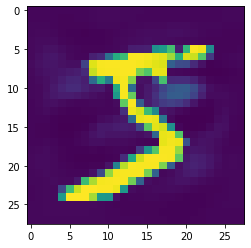

312
l2 dist: 1.435816
target class:  3
pred of adv ex:  5


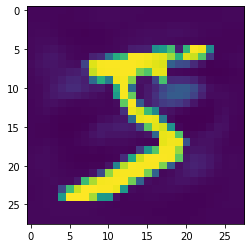

313
l2 dist: 1.4522384
target class:  3
pred of adv ex:  3


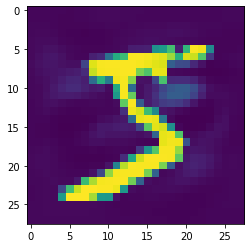

314
l2 dist: 1.4663655
target class:  3
pred of adv ex:  3


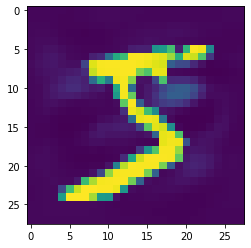

315
l2 dist: 1.4782295
target class:  3
pred of adv ex:  3


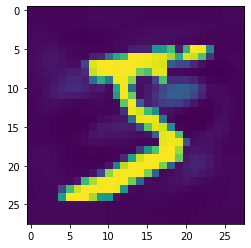

316
l2 dist: 1.4878948
target class:  3
pred of adv ex:  3


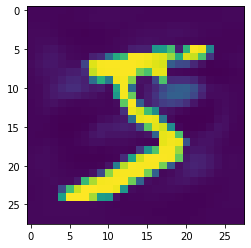

317
l2 dist: 1.4954506
target class:  3
pred of adv ex:  3


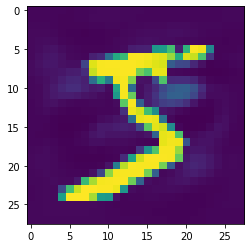

318
l2 dist: 1.5010058
target class:  3
pred of adv ex:  3


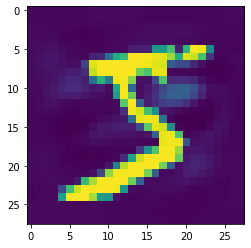

319
l2 dist: 1.5046843
target class:  3
pred of adv ex:  3


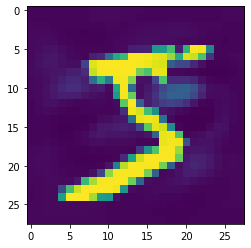

320
l2 dist: 1.5066203
target class:  3
pred of adv ex:  3


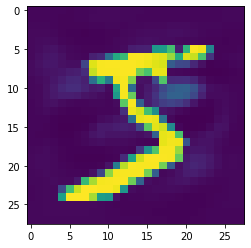

321
l2 dist: 1.5069549
target class:  3
pred of adv ex:  3


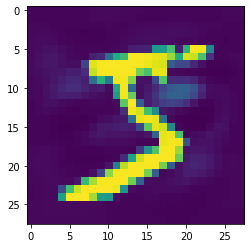

322
l2 dist: 1.5058322
target class:  3
pred of adv ex:  3


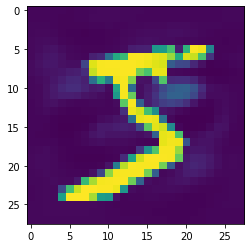

323
l2 dist: 1.503396
target class:  3
pred of adv ex:  3


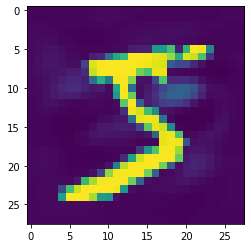

324
l2 dist: 1.4997877
target class:  3
pred of adv ex:  3


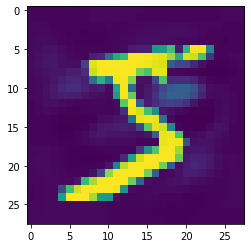

325
l2 dist: 1.4951434
target class:  3
pred of adv ex:  3


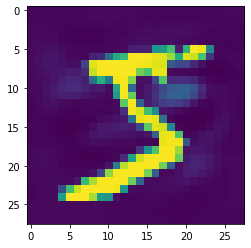

326
l2 dist: 1.4895923
target class:  3
pred of adv ex:  3


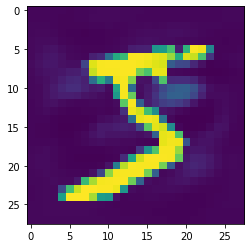

327
l2 dist: 1.4832553
target class:  3
pred of adv ex:  3


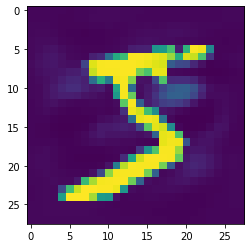

328
l2 dist: 1.4762436
target class:  3
pred of adv ex:  3


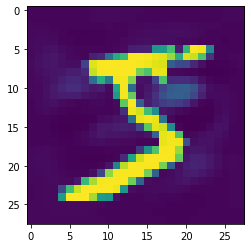

329
l2 dist: 1.468659
target class:  3
pred of adv ex:  3


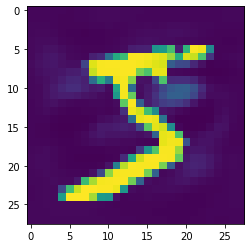

330
l2 dist: 1.4605935
target class:  3
pred of adv ex:  3


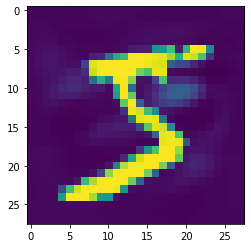

331
l2 dist: 1.452128
target class:  3
pred of adv ex:  3


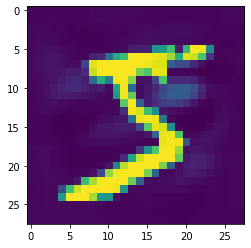

332
l2 dist: 1.4433359
target class:  3
pred of adv ex:  3


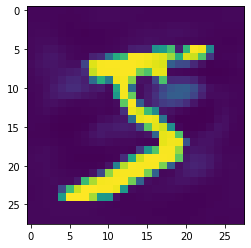

333
l2 dist: 1.4342805
target class:  3
pred of adv ex:  3


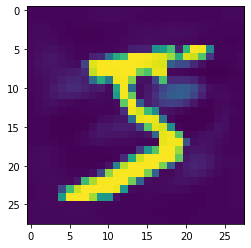

334
l2 dist: 1.4250175
target class:  3
pred of adv ex:  3


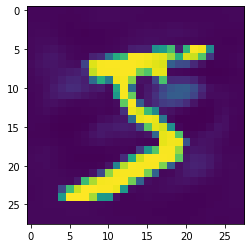

335
l2 dist: 1.415596
target class:  3
pred of adv ex:  3


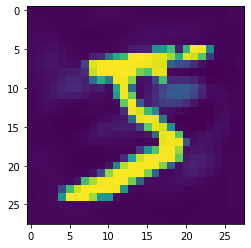

336
l2 dist: 1.4060584
target class:  3
pred of adv ex:  5


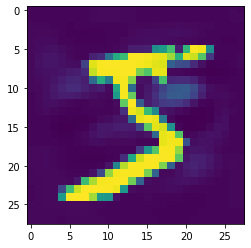

337
l2 dist: 1.4228436
target class:  3
pred of adv ex:  3


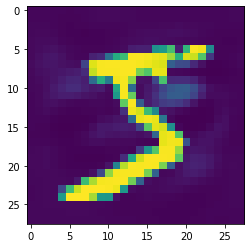

338
l2 dist: 1.437338
target class:  3
pred of adv ex:  3


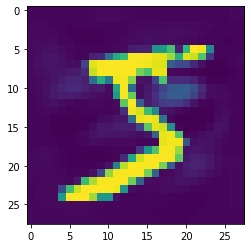

339
l2 dist: 1.4495693
target class:  3
pred of adv ex:  3


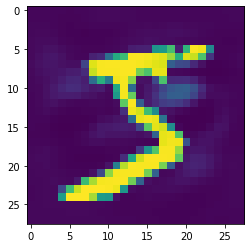

340
l2 dist: 1.459596
target class:  3
pred of adv ex:  3


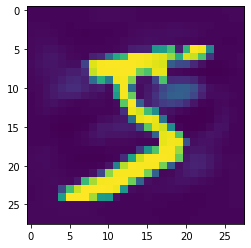

341
l2 dist: 1.4675028
target class:  3
pred of adv ex:  3


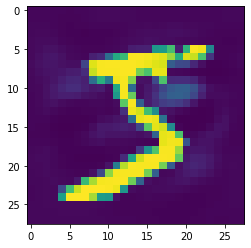

342
l2 dist: 1.473395
target class:  3
pred of adv ex:  3


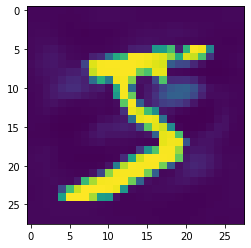

343
l2 dist: 1.4773928
target class:  3
pred of adv ex:  3


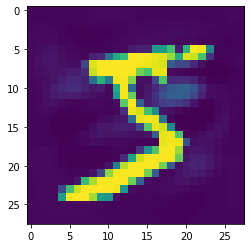

344
l2 dist: 1.4796287
target class:  3
pred of adv ex:  3


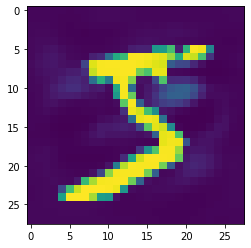

345
l2 dist: 1.4802426
target class:  3
pred of adv ex:  3


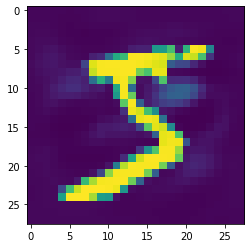

346
l2 dist: 1.4793789
target class:  3
pred of adv ex:  3


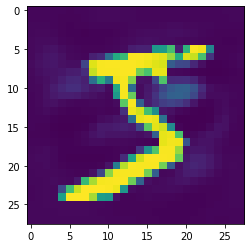

347
l2 dist: 1.4771823
target class:  3
pred of adv ex:  3


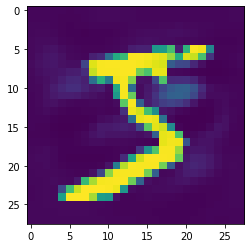

348
l2 dist: 1.4737955
target class:  3
pred of adv ex:  3


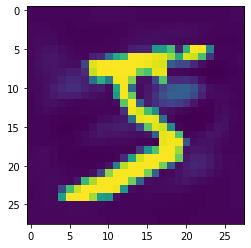

349
l2 dist: 1.4693565
target class:  3
pred of adv ex:  3


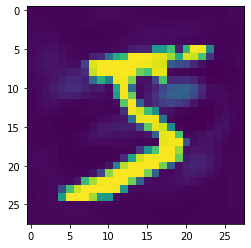

350
l2 dist: 1.4639968
target class:  3
pred of adv ex:  3


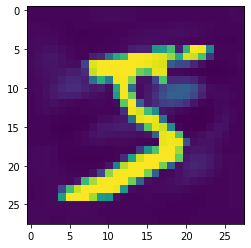

351
l2 dist: 1.4578395
target class:  3
pred of adv ex:  3


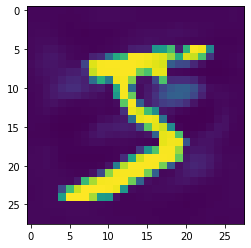

352
l2 dist: 1.4509978
target class:  3
pred of adv ex:  3


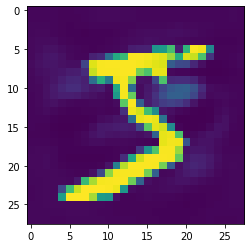

353
l2 dist: 1.4435759
target class:  3
pred of adv ex:  3


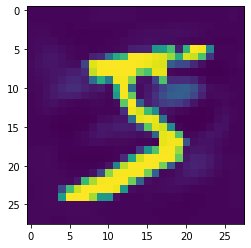

354
l2 dist: 1.4356664
target class:  3
pred of adv ex:  3


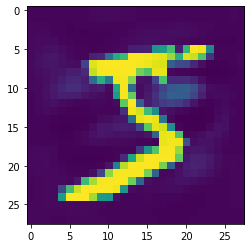

355
l2 dist: 1.4273529
target class:  3
pred of adv ex:  3


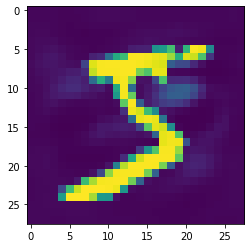

356
l2 dist: 1.4187083
target class:  3
pred of adv ex:  3


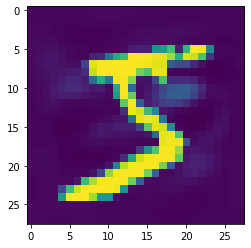

357
l2 dist: 1.4097974
target class:  3
pred of adv ex:  3


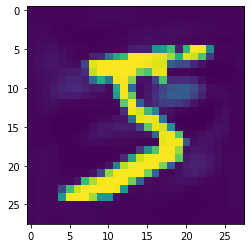

358
l2 dist: 1.4006763
target class:  3
pred of adv ex:  3


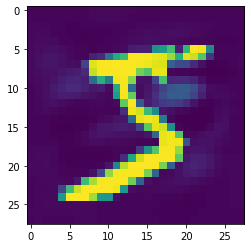

359
l2 dist: 1.3913934
target class:  3
pred of adv ex:  3


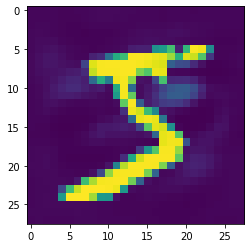

360
l2 dist: 1.381992
target class:  3
pred of adv ex:  5


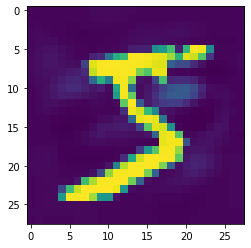

361
l2 dist: 1.3993908
target class:  3
pred of adv ex:  3


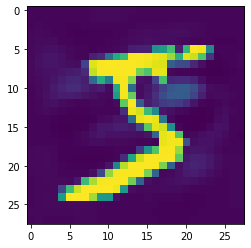

362
l2 dist: 1.4144601
target class:  3
pred of adv ex:  3


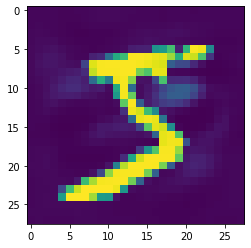

363
l2 dist: 1.4272245
target class:  3
pred of adv ex:  3


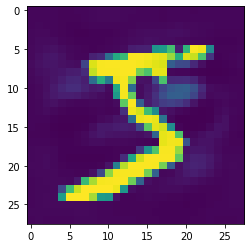

364
l2 dist: 1.4377416
target class:  3
pred of adv ex:  3


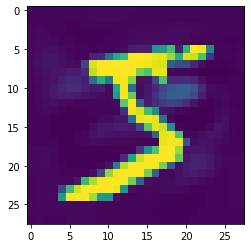

365
l2 dist: 1.4460956
target class:  3
pred of adv ex:  3


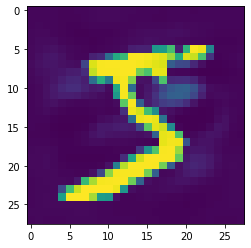

366
l2 dist: 1.4523923
target class:  3
pred of adv ex:  3


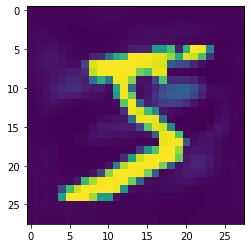

367
l2 dist: 1.4567544
target class:  3
pred of adv ex:  3


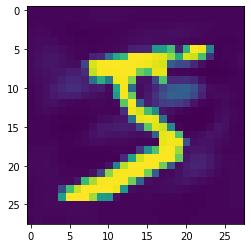

368
l2 dist: 1.459316
target class:  3
pred of adv ex:  3


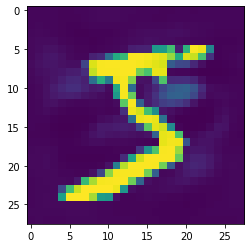

369
l2 dist: 1.4602201
target class:  3
pred of adv ex:  3


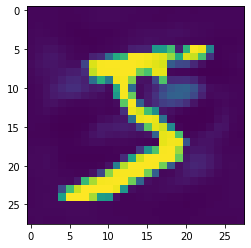

370
l2 dist: 1.4596139
target class:  3
pred of adv ex:  3


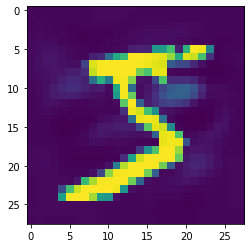

371
l2 dist: 1.4576457
target class:  3
pred of adv ex:  3


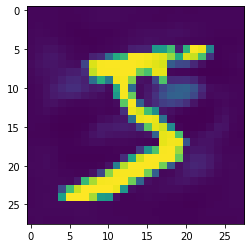

372
l2 dist: 1.4544611
target class:  3
pred of adv ex:  3


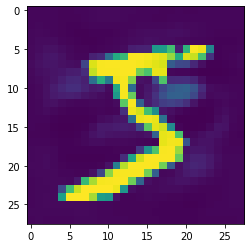

373
l2 dist: 1.4502014
target class:  3
pred of adv ex:  3


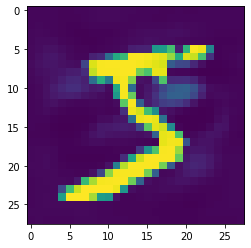

374
l2 dist: 1.4450009
target class:  3
pred of adv ex:  3


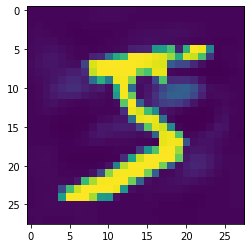

375
l2 dist: 1.4389853
target class:  3
pred of adv ex:  3


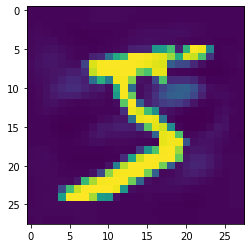

376
l2 dist: 1.4322704
target class:  3
pred of adv ex:  3


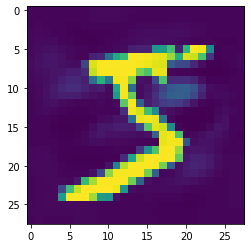

377
l2 dist: 1.4249619
target class:  3
pred of adv ex:  3


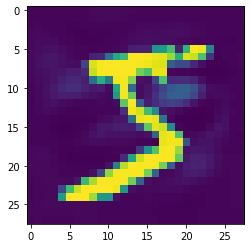

378
l2 dist: 1.4171548
target class:  3
pred of adv ex:  3


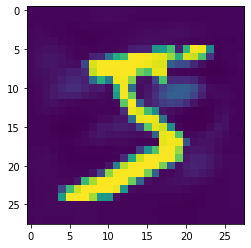

379
l2 dist: 1.4089336
target class:  3
pred of adv ex:  3


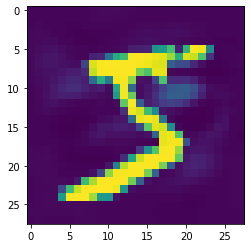

380
l2 dist: 1.4003731
target class:  3
pred of adv ex:  3


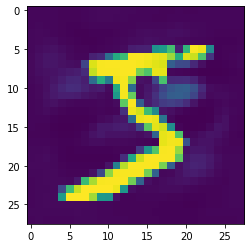

381
l2 dist: 1.3915387
target class:  3
pred of adv ex:  3


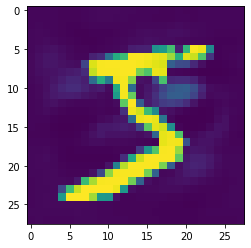

382
l2 dist: 1.3824874
target class:  3
pred of adv ex:  3


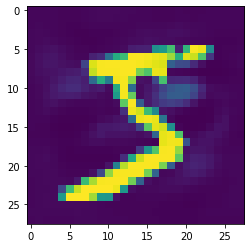

383
l2 dist: 1.3732694
target class:  3
pred of adv ex:  3


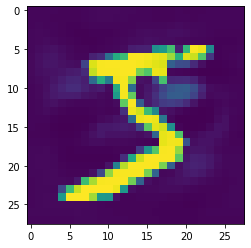

384
l2 dist: 1.3639277
target class:  3
pred of adv ex:  3


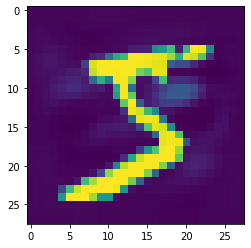

385
l2 dist: 1.3545002
target class:  3
pred of adv ex:  5


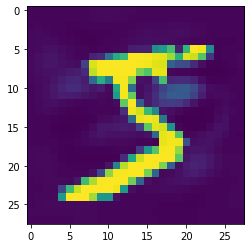

386
l2 dist: 1.3720733
target class:  3
pred of adv ex:  3


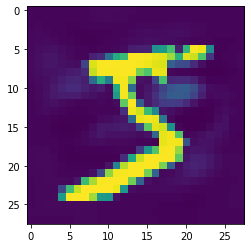

387
l2 dist: 1.3873558
target class:  3
pred of adv ex:  3


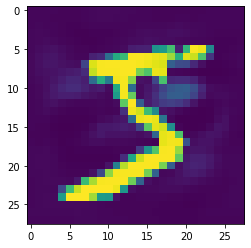

388
l2 dist: 1.4003625
target class:  3
pred of adv ex:  3


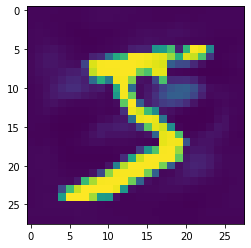

389
l2 dist: 1.4111415
target class:  3
pred of adv ex:  3


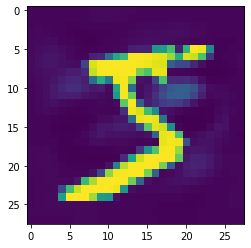

390
l2 dist: 1.4197683
target class:  3
pred of adv ex:  3


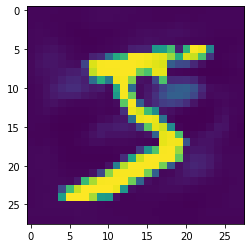

391
l2 dist: 1.4263417
target class:  3
pred of adv ex:  3


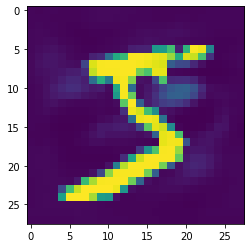

392
l2 dist: 1.430978
target class:  3
pred of adv ex:  3


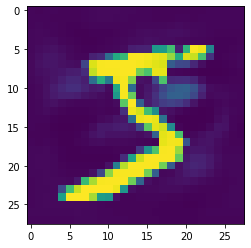

393
l2 dist: 1.4338081
target class:  3
pred of adv ex:  3


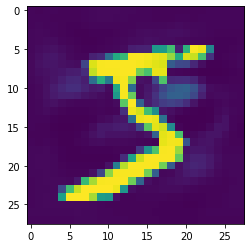

394
l2 dist: 1.4349722
target class:  3
pred of adv ex:  3


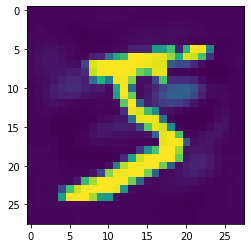

395
l2 dist: 1.4346157
target class:  3
pred of adv ex:  3


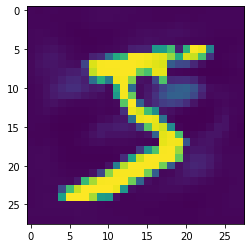

396
l2 dist: 1.4328865
target class:  3
pred of adv ex:  3


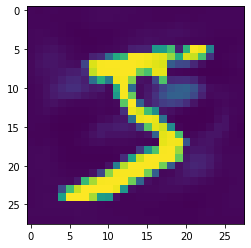

397
l2 dist: 1.429931
target class:  3
pred of adv ex:  3


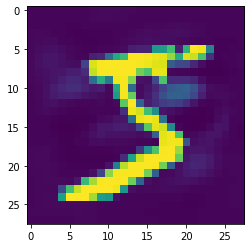

398
l2 dist: 1.4258914
target class:  3
pred of adv ex:  3


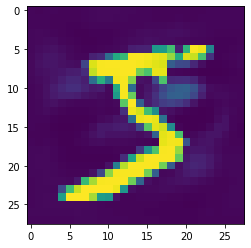

399
l2 dist: 1.4209027
target class:  3
pred of adv ex:  3


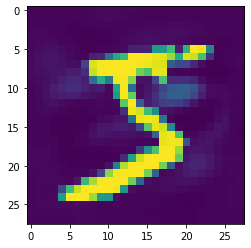

400
l2 dist: 1.4150925
target class:  3
pred of adv ex:  3


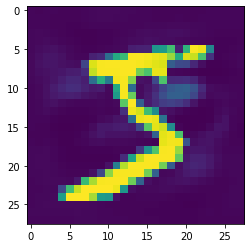

401
l2 dist: 1.4085774
target class:  3
pred of adv ex:  3


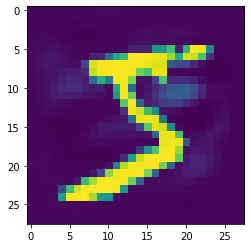

402
l2 dist: 1.4014647
target class:  3
pred of adv ex:  3


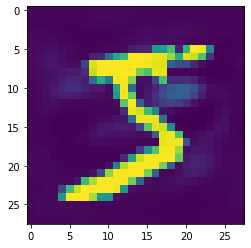

403
l2 dist: 1.3938498
target class:  3
pred of adv ex:  3


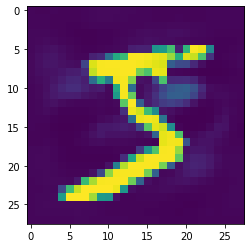

404
l2 dist: 1.3858182
target class:  3
pred of adv ex:  3


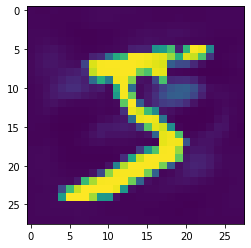

405
l2 dist: 1.377445
target class:  3
pred of adv ex:  3


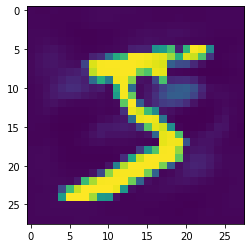

406
l2 dist: 1.3687958
target class:  3
pred of adv ex:  3


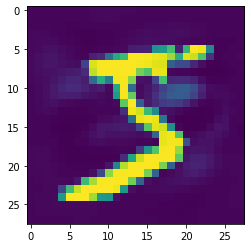

407
l2 dist: 1.3599275
target class:  3
pred of adv ex:  3


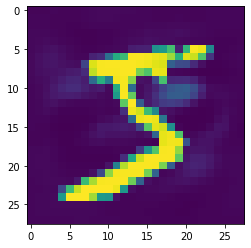

408
l2 dist: 1.3508902
target class:  3
pred of adv ex:  3


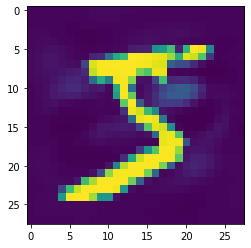

409
l2 dist: 1.3417264
target class:  3
pred of adv ex:  3


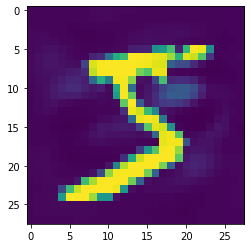

410
l2 dist: 1.3324739
target class:  3
pred of adv ex:  5


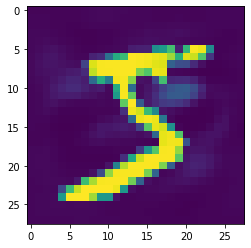

411
l2 dist: 1.3504691
target class:  3
pred of adv ex:  3


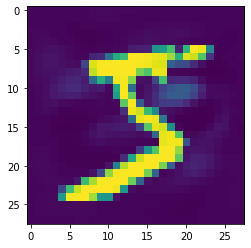

412
l2 dist: 1.3661618
target class:  3
pred of adv ex:  3


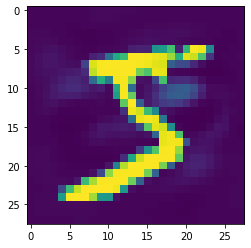

413
l2 dist: 1.3795611
target class:  3
pred of adv ex:  3


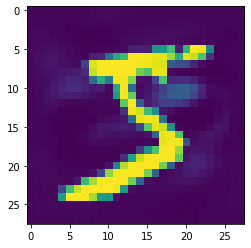

414
l2 dist: 1.3907108
target class:  3
pred of adv ex:  3


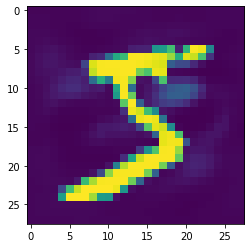

415
l2 dist: 1.3996841
target class:  3
pred of adv ex:  3


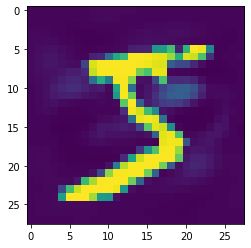

416
l2 dist: 1.406578
target class:  3
pred of adv ex:  3


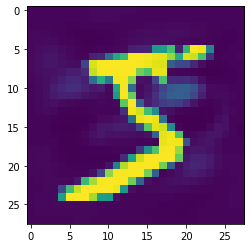

417
l2 dist: 1.4115088
target class:  3
pred of adv ex:  3


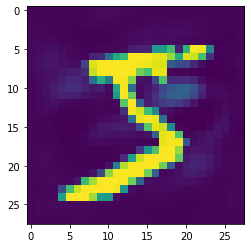

418
l2 dist: 1.414608
target class:  3
pred of adv ex:  3


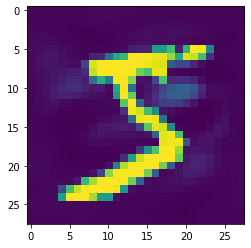

419
l2 dist: 1.4160168
target class:  3
pred of adv ex:  3


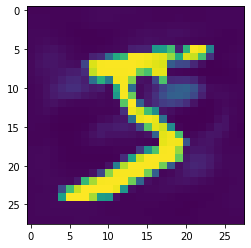

420
l2 dist: 1.4158833
target class:  3
pred of adv ex:  3


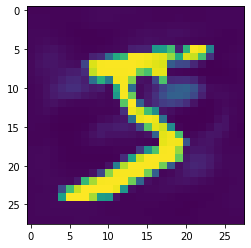

421
l2 dist: 1.4143572
target class:  3
pred of adv ex:  3


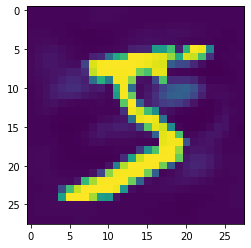

422
l2 dist: 1.4115871
target class:  3
pred of adv ex:  3


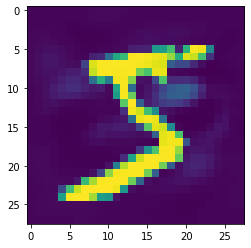

423
l2 dist: 1.4077177
target class:  3
pred of adv ex:  3


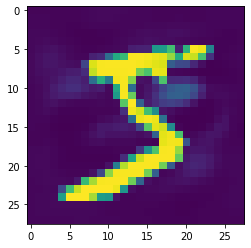

424
l2 dist: 1.4028865
target class:  3
pred of adv ex:  3


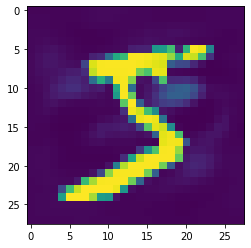

425
l2 dist: 1.3972222
target class:  3
pred of adv ex:  3


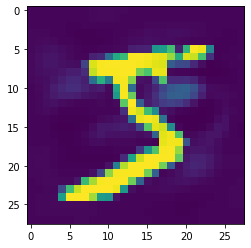

426
l2 dist: 1.3908439
target class:  3
pred of adv ex:  3


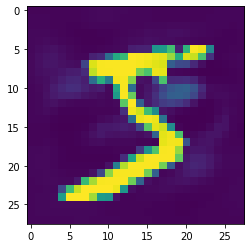

427
l2 dist: 1.3838595
target class:  3
pred of adv ex:  3


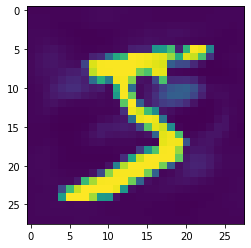

428
l2 dist: 1.376366
target class:  3
pred of adv ex:  3


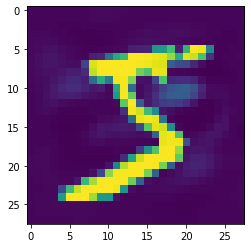

429
l2 dist: 1.3684497
target class:  3
pred of adv ex:  3


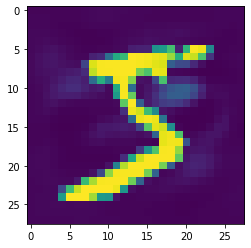

430
l2 dist: 1.3601861
target class:  3
pred of adv ex:  3


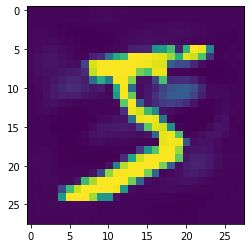

431
l2 dist: 1.3516418
target class:  3
pred of adv ex:  3


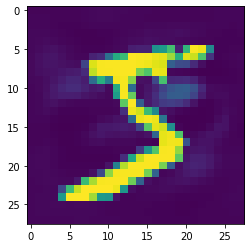

432
l2 dist: 1.3428742
target class:  3
pred of adv ex:  3


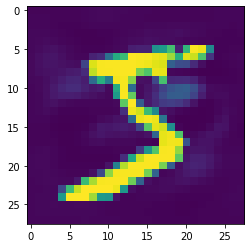

433
l2 dist: 1.3339334
target class:  3
pred of adv ex:  3


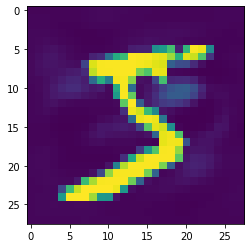

434
l2 dist: 1.3248627
target class:  3
pred of adv ex:  3


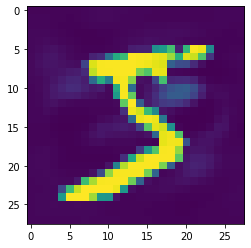

435
l2 dist: 1.3156997
target class:  3
pred of adv ex:  5


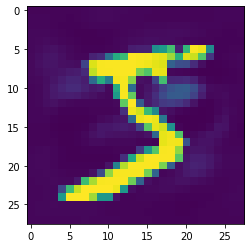

436
l2 dist: 1.3341019
target class:  3
pred of adv ex:  3


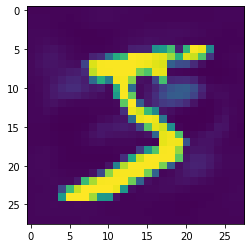

437
l2 dist: 1.3501827
target class:  3
pred of adv ex:  3


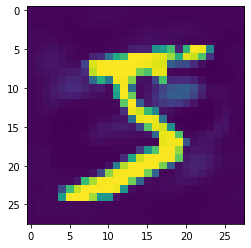

438
l2 dist: 1.3639458
target class:  3
pred of adv ex:  3


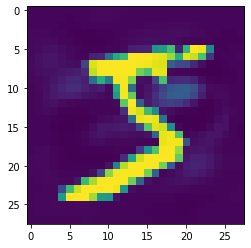

439
l2 dist: 1.3754317
target class:  3
pred of adv ex:  3


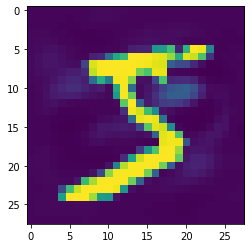

440
l2 dist: 1.3847107
target class:  3
pred of adv ex:  3


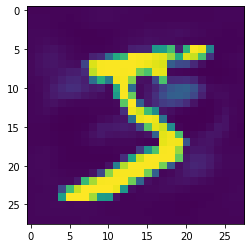

441
l2 dist: 1.3918788
target class:  3
pred of adv ex:  3


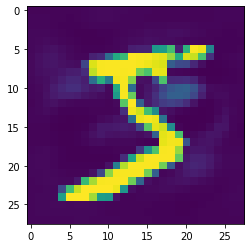

442
l2 dist: 1.397053
target class:  3
pred of adv ex:  3


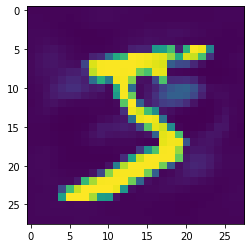

443
l2 dist: 1.4003652
target class:  3
pred of adv ex:  3


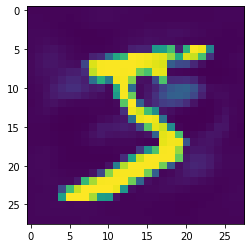

444
l2 dist: 1.4019593
target class:  3
pred of adv ex:  3


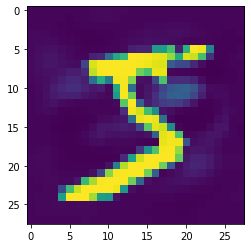

445
l2 dist: 1.4019856
target class:  3
pred of adv ex:  3


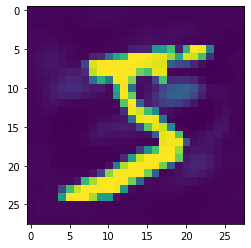

446
l2 dist: 1.4005972
target class:  3
pred of adv ex:  3


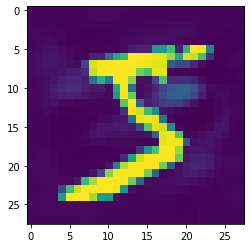

447
l2 dist: 1.3979458
target class:  3
pred of adv ex:  3


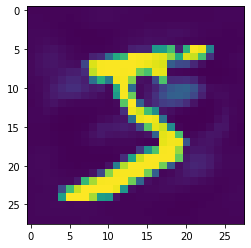

448
l2 dist: 1.3941786
target class:  3
pred of adv ex:  3


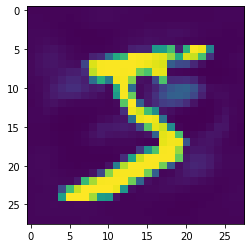

449
l2 dist: 1.3894361
target class:  3
pred of adv ex:  3


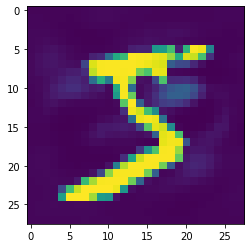

450
l2 dist: 1.3838494
target class:  3
pred of adv ex:  3


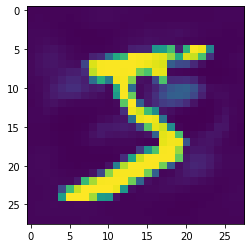

451
l2 dist: 1.3775395
target class:  3
pred of adv ex:  3


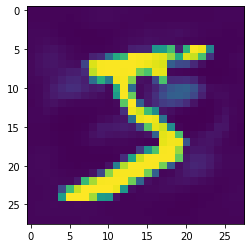

452
l2 dist: 1.370616
target class:  3
pred of adv ex:  3


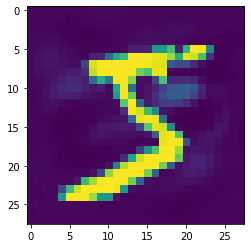

453
l2 dist: 1.3631771
target class:  3
pred of adv ex:  3


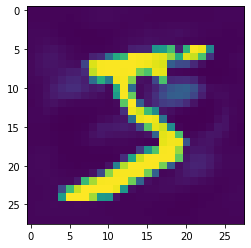

454
l2 dist: 1.3553102
target class:  3
pred of adv ex:  3


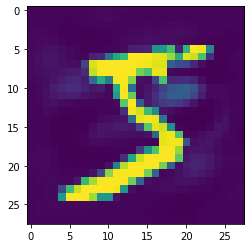

455
l2 dist: 1.3470919
target class:  3
pred of adv ex:  3


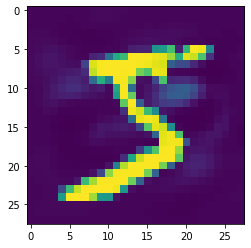

456
l2 dist: 1.3385888
target class:  3
pred of adv ex:  3


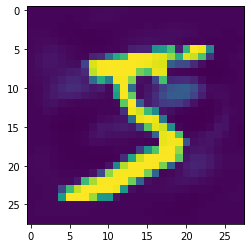

457
l2 dist: 1.3298595
target class:  3
pred of adv ex:  3


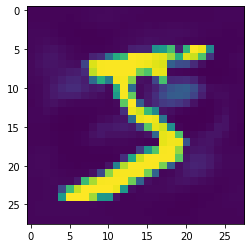

458
l2 dist: 1.3209542
target class:  3
pred of adv ex:  3


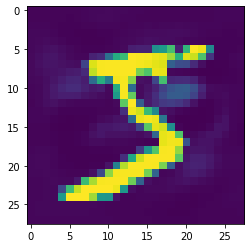

459
l2 dist: 1.3119165
target class:  3
pred of adv ex:  3


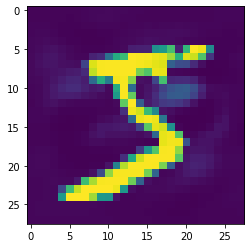

460
l2 dist: 1.3027846
target class:  3
pred of adv ex:  5


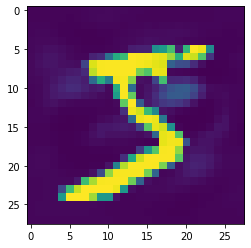

461
l2 dist: 1.3215783
target class:  3
pred of adv ex:  3


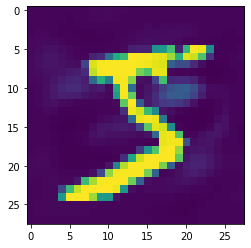

462
l2 dist: 1.3380282
target class:  3
pred of adv ex:  3


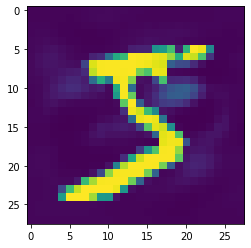

463
l2 dist: 1.3521335
target class:  3
pred of adv ex:  3


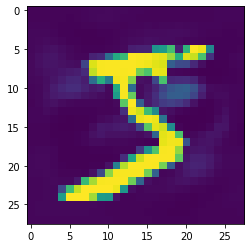

464
l2 dist: 1.363931
target class:  3
pred of adv ex:  3


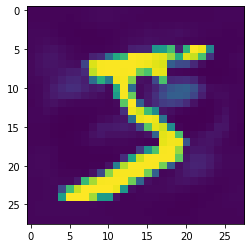

465
l2 dist: 1.3734885
target class:  3
pred of adv ex:  3


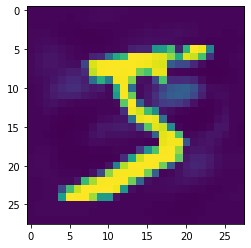

466
l2 dist: 1.3809016
target class:  3
pred of adv ex:  3


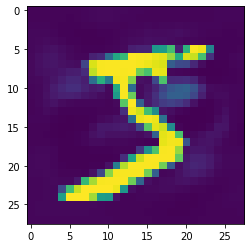

467
l2 dist: 1.3862869
target class:  3
pred of adv ex:  3


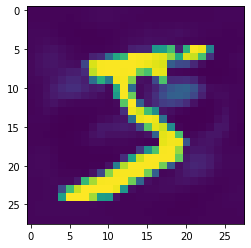

468
l2 dist: 1.3897786
target class:  3
pred of adv ex:  3


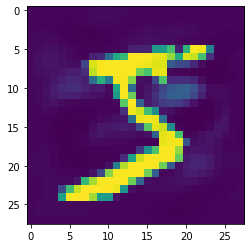

469
l2 dist: 1.3915225
target class:  3
pred of adv ex:  3


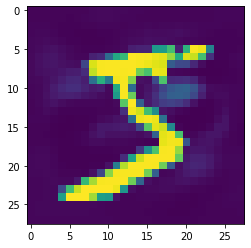

470
l2 dist: 1.3916723
target class:  3
pred of adv ex:  3


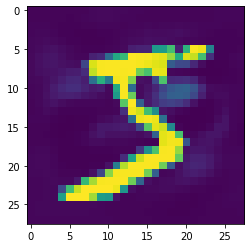

471
l2 dist: 1.3903837
target class:  3
pred of adv ex:  3


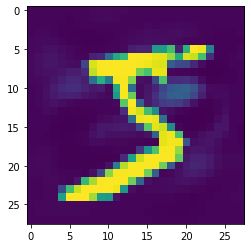

472
l2 dist: 1.3878124
target class:  3
pred of adv ex:  3


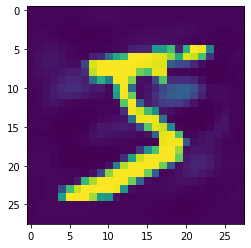

473
l2 dist: 1.3841085
target class:  3
pred of adv ex:  3


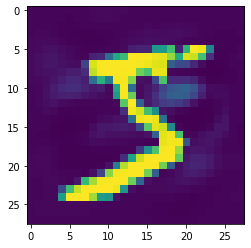

474
l2 dist: 1.3794153
target class:  3
pred of adv ex:  3


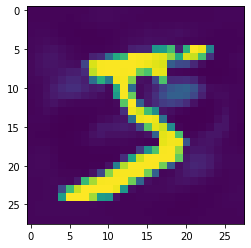

475
l2 dist: 1.3738666
target class:  3
pred of adv ex:  3


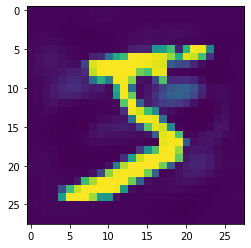

476
l2 dist: 1.367585
target class:  3
pred of adv ex:  3


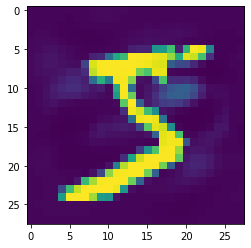

477
l2 dist: 1.3606821
target class:  3
pred of adv ex:  3


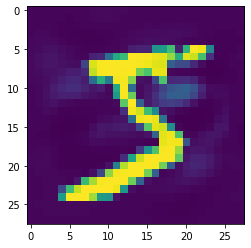

478
l2 dist: 1.3532578
target class:  3
pred of adv ex:  3


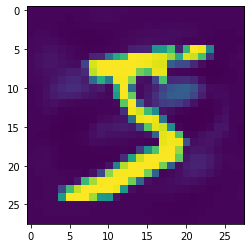

479
l2 dist: 1.3454001
target class:  3
pred of adv ex:  3


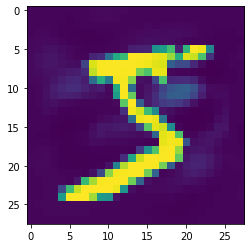

480
l2 dist: 1.3371867
target class:  3
pred of adv ex:  3


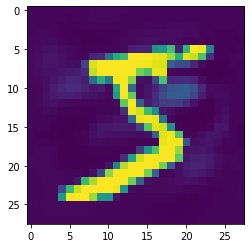

481
l2 dist: 1.328685
target class:  3
pred of adv ex:  3


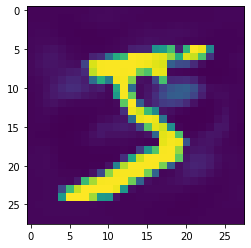

482
l2 dist: 1.3199545
target class:  3
pred of adv ex:  3


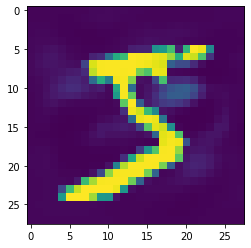

483
l2 dist: 1.3110453
target class:  3
pred of adv ex:  3


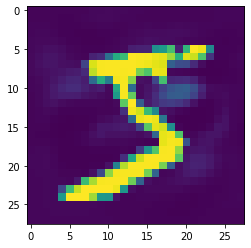

484
l2 dist: 1.3020018
target class:  3
pred of adv ex:  3


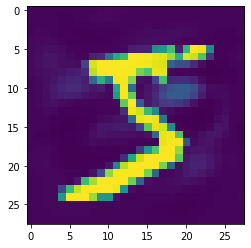

485
l2 dist: 1.2928623
target class:  3
pred of adv ex:  5


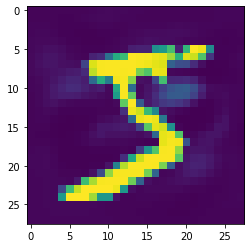

486
l2 dist: 1.3120242
target class:  3
pred of adv ex:  3


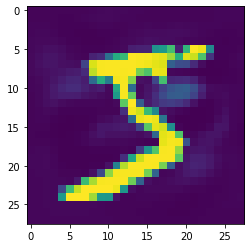

487
l2 dist: 1.3288188
target class:  3
pred of adv ex:  3


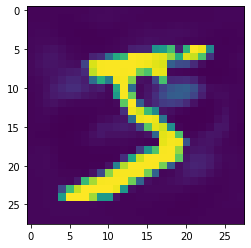

488
l2 dist: 1.3432407
target class:  3
pred of adv ex:  3


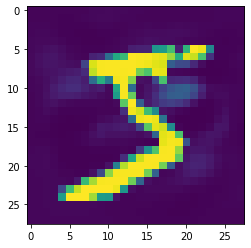

489
l2 dist: 1.3553227
target class:  3
pred of adv ex:  3


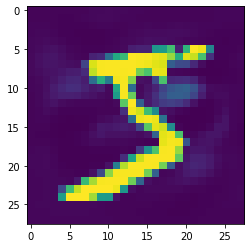

490
l2 dist: 1.3651314
target class:  3
pred of adv ex:  3


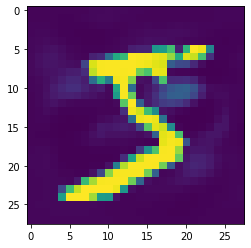

491
l2 dist: 1.3727604
target class:  3
pred of adv ex:  3


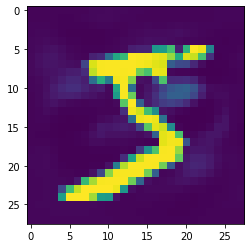

492
l2 dist: 1.3783277
target class:  3
pred of adv ex:  3


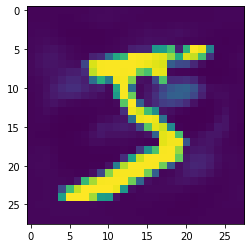

493
l2 dist: 1.3819689
target class:  3
pred of adv ex:  3


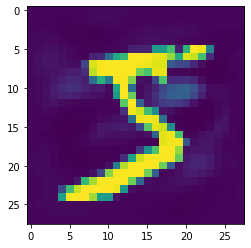

494
l2 dist: 1.3838323
target class:  3
pred of adv ex:  3


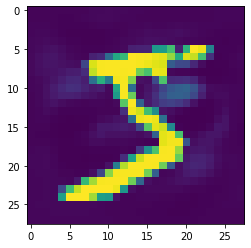

495
l2 dist: 1.384075
target class:  3
pred of adv ex:  3


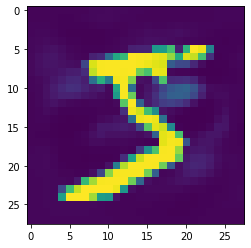

496
l2 dist: 1.3828564
target class:  3
pred of adv ex:  3


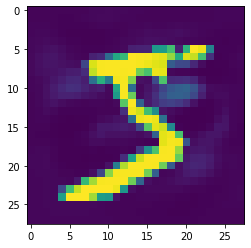

497
l2 dist: 1.3803351
target class:  3
pred of adv ex:  3


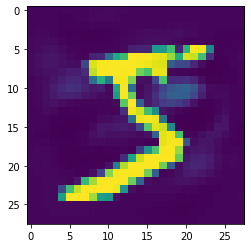

498
l2 dist: 1.3766649
target class:  3
pred of adv ex:  3


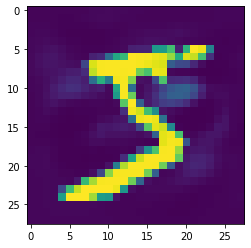

499
l2 dist: 1.3719918
target class:  3
pred of adv ex:  3


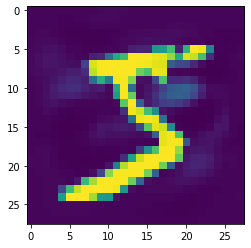

500
l2 dist: 1.3664519
target class:  3
pred of adv ex:  3


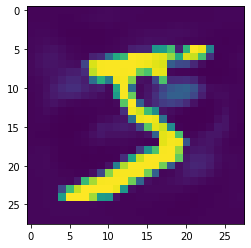

501
l2 dist: 1.3601702
target class:  3
pred of adv ex:  3


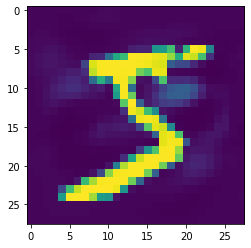

502
l2 dist: 1.35326
target class:  3
pred of adv ex:  3


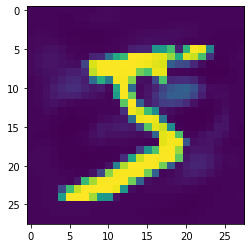

503
l2 dist: 1.3458222
target class:  3
pred of adv ex:  3


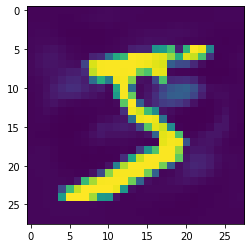

504
l2 dist: 1.337946
target class:  3
pred of adv ex:  3


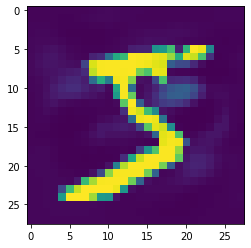

505
l2 dist: 1.3297105
target class:  3
pred of adv ex:  3


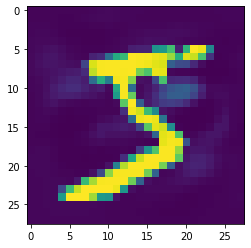

506
l2 dist: 1.3211834
target class:  3
pred of adv ex:  3


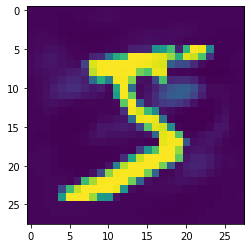

507
l2 dist: 1.3124249
target class:  3
pred of adv ex:  3


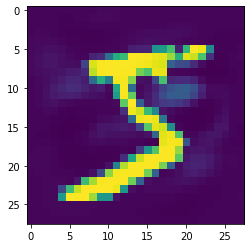

508
l2 dist: 1.3034858
target class:  3
pred of adv ex:  3


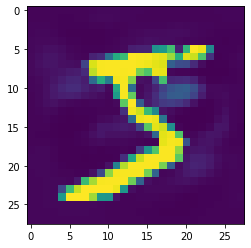

509
l2 dist: 1.2944107
target class:  3
pred of adv ex:  3


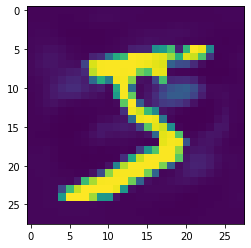

510
l2 dist: 1.2852384
target class:  3
pred of adv ex:  3


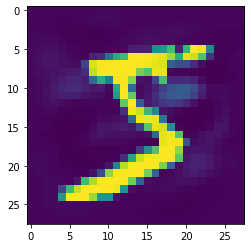

511
l2 dist: 1.2760023
target class:  3
pred of adv ex:  5


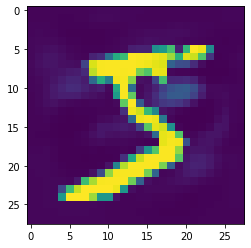

512
l2 dist: 1.2950312
target class:  3
pred of adv ex:  3


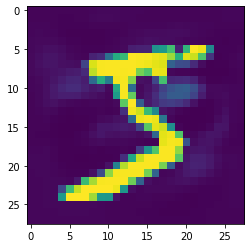

513
l2 dist: 1.3117619
target class:  3
pred of adv ex:  3


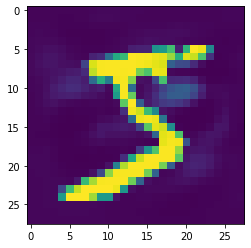

514
l2 dist: 1.3261755
target class:  3
pred of adv ex:  3


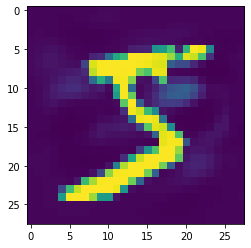

515
l2 dist: 1.3382916
target class:  3
pred of adv ex:  3


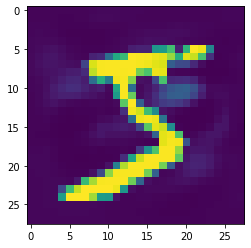

516
l2 dist: 1.3481652
target class:  3
pred of adv ex:  3


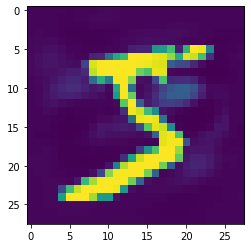

517
l2 dist: 1.3558804
target class:  3
pred of adv ex:  3


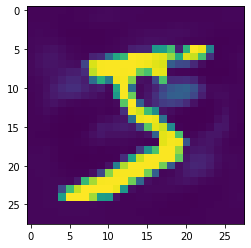

518
l2 dist: 1.3615471
target class:  3
pred of adv ex:  3


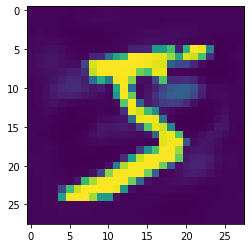

519
l2 dist: 1.3652956
target class:  3
pred of adv ex:  3


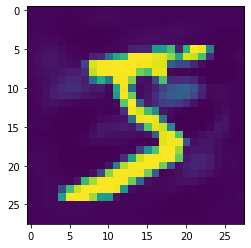

520
l2 dist: 1.3672708
target class:  3
pred of adv ex:  3


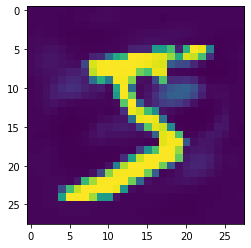

521
l2 dist: 1.367627
target class:  3
pred of adv ex:  3


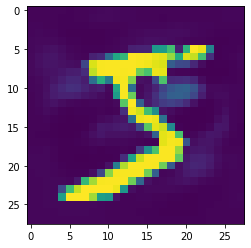

522
l2 dist: 1.3665228
target class:  3
pred of adv ex:  3


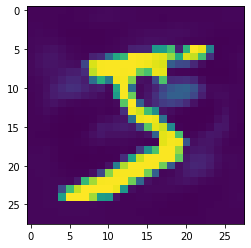

523
l2 dist: 1.3641162
target class:  3
pred of adv ex:  3


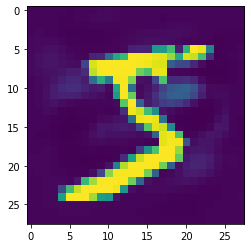

524
l2 dist: 1.3605613
target class:  3
pred of adv ex:  3


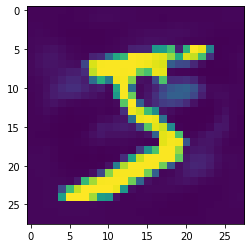

525
l2 dist: 1.3560044
target class:  3
pred of adv ex:  3


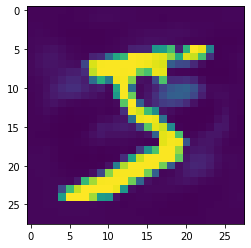

526
l2 dist: 1.3505821
target class:  3
pred of adv ex:  3


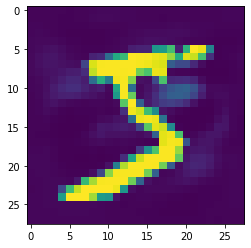

527
l2 dist: 1.34442
target class:  3
pred of adv ex:  3


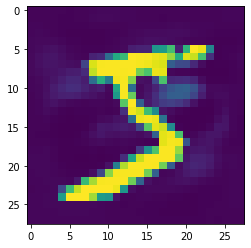

528
l2 dist: 1.3376311
target class:  3
pred of adv ex:  3


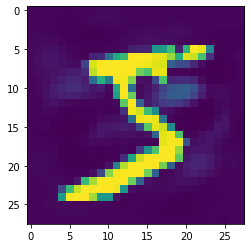

529
l2 dist: 1.3303173
target class:  3
pred of adv ex:  3


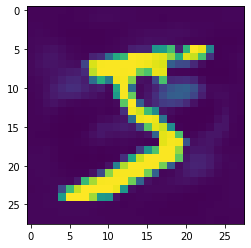

530
l2 dist: 1.3225677
target class:  3
pred of adv ex:  3


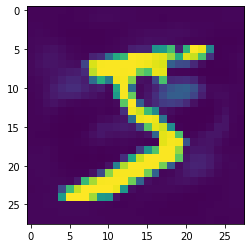

531
l2 dist: 1.3144611
target class:  3
pred of adv ex:  3


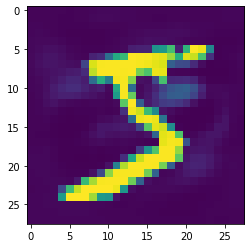

532
l2 dist: 1.3060654
target class:  3
pred of adv ex:  3


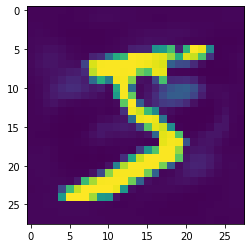

533
l2 dist: 1.2974396
target class:  3
pred of adv ex:  3


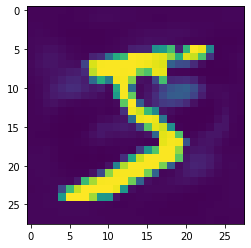

534
l2 dist: 1.2886345
target class:  3
pred of adv ex:  3


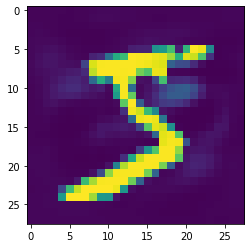

535
l2 dist: 1.279694
target class:  3
pred of adv ex:  3


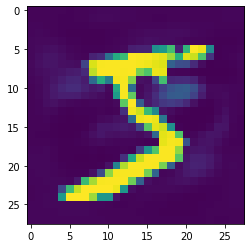

536
l2 dist: 1.2706556
target class:  3
pred of adv ex:  3


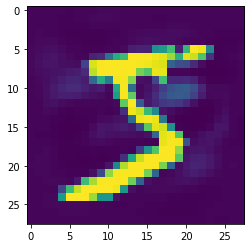

537
l2 dist: 1.2615525
target class:  3
pred of adv ex:  5


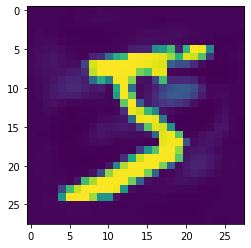

538
l2 dist: 1.2807359
target class:  3
pred of adv ex:  3


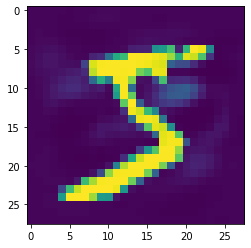

539
l2 dist: 1.2976334
target class:  3
pred of adv ex:  3


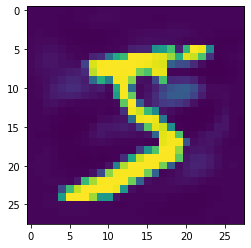

540
l2 dist: 1.3122193
target class:  3
pred of adv ex:  3


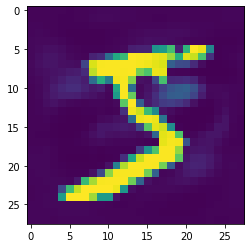

541
l2 dist: 1.3245075
target class:  3
pred of adv ex:  3


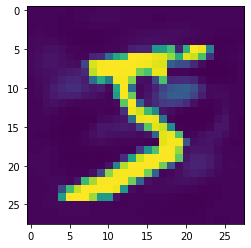

542
l2 dist: 1.3345476
target class:  3
pred of adv ex:  3


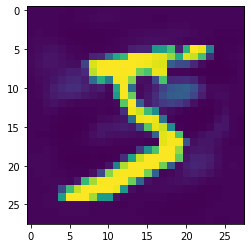

543
l2 dist: 1.3424217
target class:  3
pred of adv ex:  3


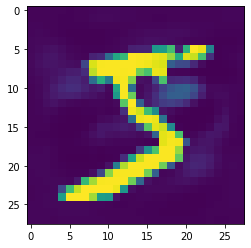

544
l2 dist: 1.3482375
target class:  3
pred of adv ex:  3


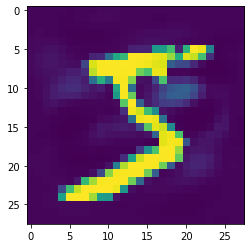

545
l2 dist: 1.3521248
target class:  3
pred of adv ex:  3


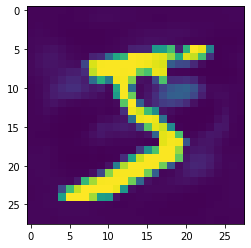

546
l2 dist: 1.3542293
target class:  3
pred of adv ex:  3


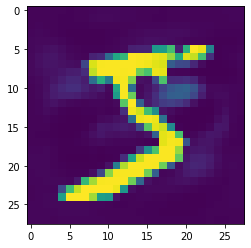

547
l2 dist: 1.354706
target class:  3
pred of adv ex:  3


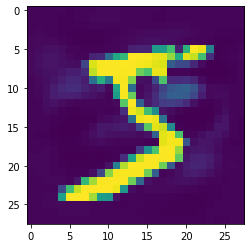

548
l2 dist: 1.3537147
target class:  3
pred of adv ex:  3


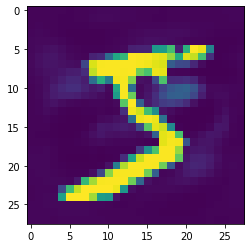

549
l2 dist: 1.351415
target class:  3
pred of adv ex:  3


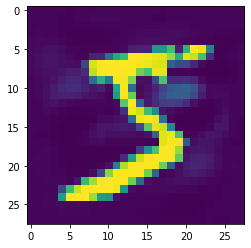

550
l2 dist: 1.3479619
target class:  3
pred of adv ex:  3


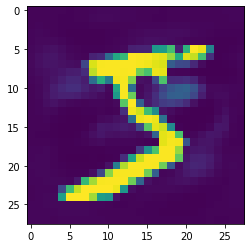

551
l2 dist: 1.3435026
target class:  3
pred of adv ex:  3


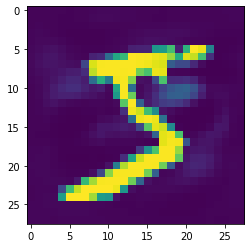

552
l2 dist: 1.3381748
target class:  3
pred of adv ex:  3


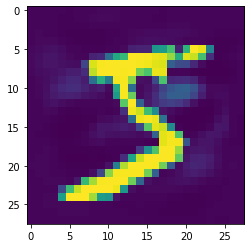

553
l2 dist: 1.3321044
target class:  3
pred of adv ex:  3


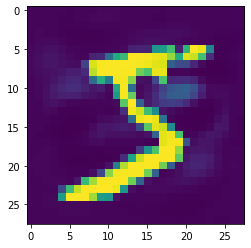

554
l2 dist: 1.3254056
target class:  3
pred of adv ex:  3


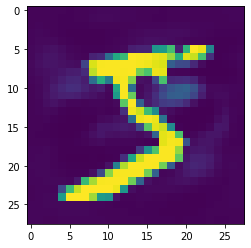

555
l2 dist: 1.31818
target class:  3
pred of adv ex:  3


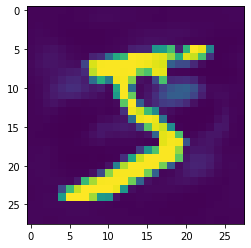

556
l2 dist: 1.3105173
target class:  3
pred of adv ex:  3


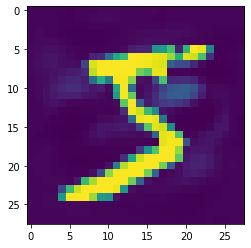

557
l2 dist: 1.3024964
target class:  3
pred of adv ex:  3


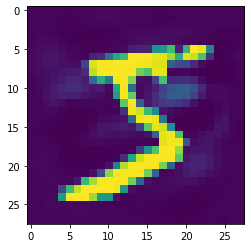

558
l2 dist: 1.2941855
target class:  3
pred of adv ex:  3


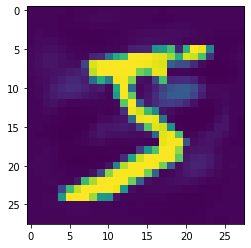

559
l2 dist: 1.2856437
target class:  3
pred of adv ex:  3


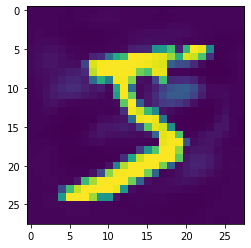

560
l2 dist: 1.2769215
target class:  3
pred of adv ex:  3


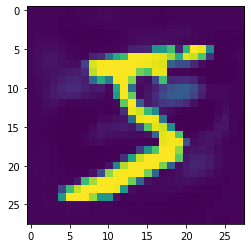

561
l2 dist: 1.2680625
target class:  3
pred of adv ex:  3


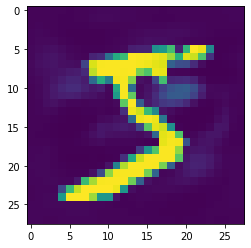

562
l2 dist: 1.2591043
target class:  3
pred of adv ex:  5


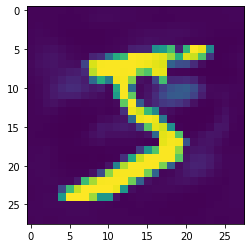

563
l2 dist: 1.279041
target class:  3
pred of adv ex:  3


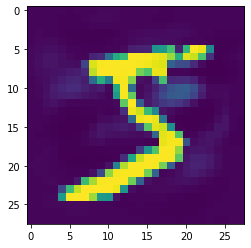

564
l2 dist: 1.2966
target class:  3
pred of adv ex:  3


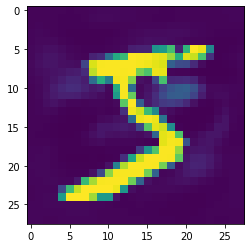

565
l2 dist: 1.3117551
target class:  3
pred of adv ex:  3


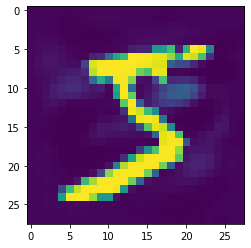

566
l2 dist: 1.3245236
target class:  3
pred of adv ex:  3


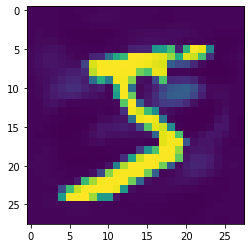

567
l2 dist: 1.3349596
target class:  3
pred of adv ex:  3


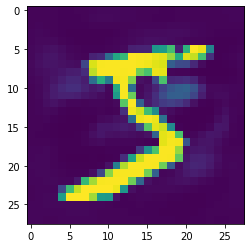

568
l2 dist: 1.343151
target class:  3
pred of adv ex:  3


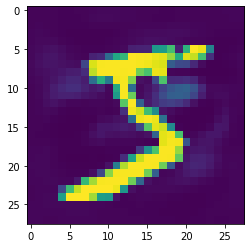

569
l2 dist: 1.3492132
target class:  3
pred of adv ex:  3


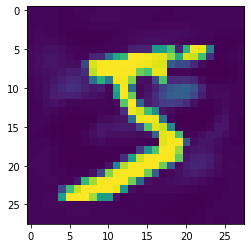

570
l2 dist: 1.3532839
target class:  3
pred of adv ex:  3


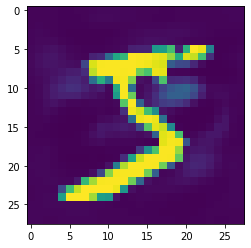

571
l2 dist: 1.3555164
target class:  3
pred of adv ex:  3


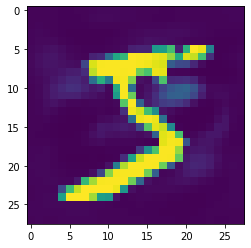

572
l2 dist: 1.3560741
target class:  3
pred of adv ex:  3


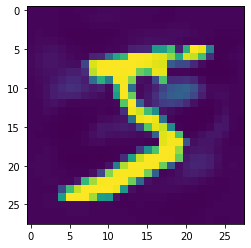

573
l2 dist: 1.3551242
target class:  3
pred of adv ex:  3


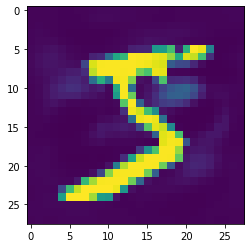

574
l2 dist: 1.3528327
target class:  3
pred of adv ex:  3


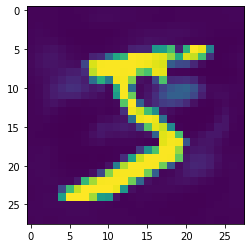

575
l2 dist: 1.34936
target class:  3
pred of adv ex:  3


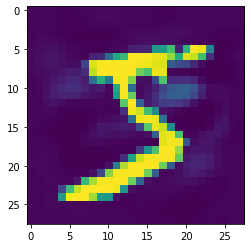

576
l2 dist: 1.3448583
target class:  3
pred of adv ex:  3


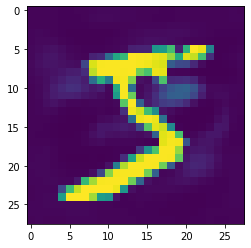

577
l2 dist: 1.3394687
target class:  3
pred of adv ex:  3


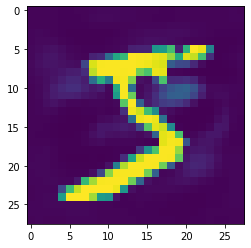

578
l2 dist: 1.3333201
target class:  3
pred of adv ex:  3


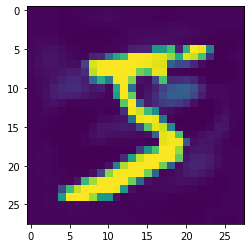

579
l2 dist: 1.3265288
target class:  3
pred of adv ex:  3


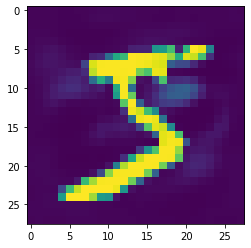

580
l2 dist: 1.3191985
target class:  3
pred of adv ex:  3


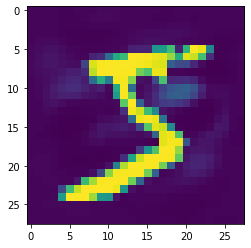

581
l2 dist: 1.3114208
target class:  3
pred of adv ex:  3


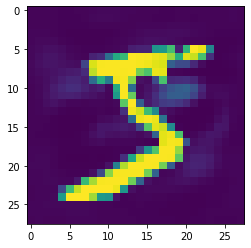

582
l2 dist: 1.303276
target class:  3
pred of adv ex:  3


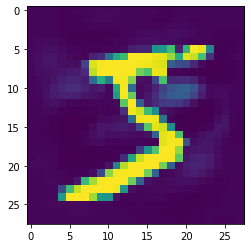

583
l2 dist: 1.2948334
target class:  3
pred of adv ex:  3


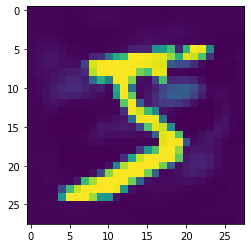

584
l2 dist: 1.2861539
target class:  3
pred of adv ex:  3


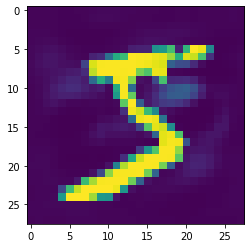

585
l2 dist: 1.2772894
target class:  3
pred of adv ex:  3


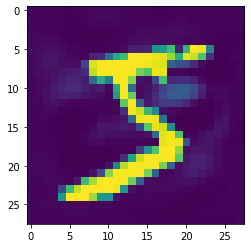

586
l2 dist: 1.2682847
target class:  3
pred of adv ex:  3


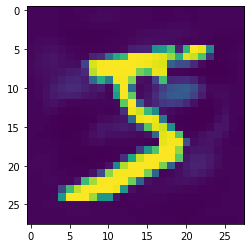

587
l2 dist: 1.2591783
target class:  3
pred of adv ex:  3


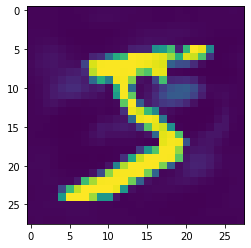

588
l2 dist: 1.250004
target class:  3
pred of adv ex:  5


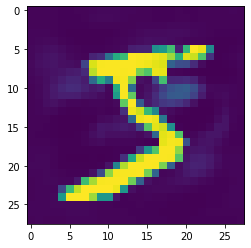

589
l2 dist: 1.2697796
target class:  3
pred of adv ex:  3


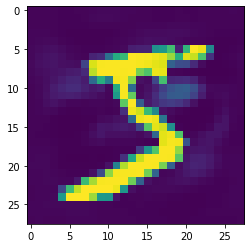

590
l2 dist: 1.2872388
target class:  3
pred of adv ex:  3


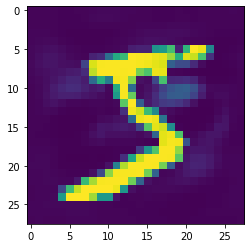

591
l2 dist: 1.3023425
target class:  3
pred of adv ex:  3


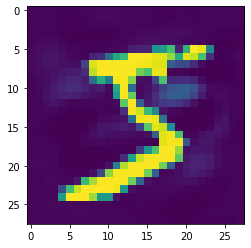

592
l2 dist: 1.3150947
target class:  3
pred of adv ex:  3


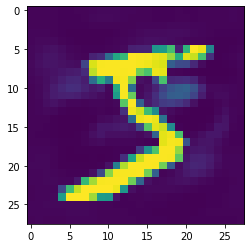

593
l2 dist: 1.3255382
target class:  3
pred of adv ex:  3


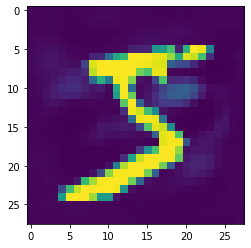

594
l2 dist: 1.3337512
target class:  3
pred of adv ex:  3


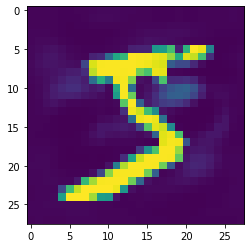

595
l2 dist: 1.3398421
target class:  3
pred of adv ex:  3


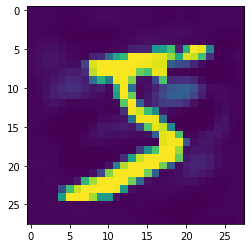

596
l2 dist: 1.3439434
target class:  3
pred of adv ex:  3


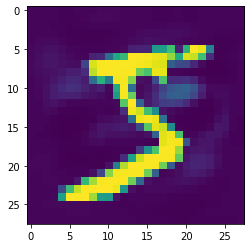

597
l2 dist: 1.3462058
target class:  3
pred of adv ex:  3


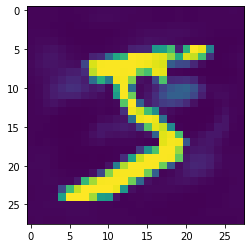

598
l2 dist: 1.3467911
target class:  3
pred of adv ex:  3


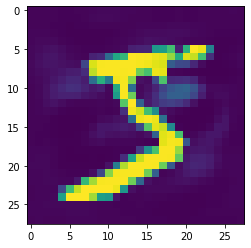

599
l2 dist: 1.3458662
target class:  3
pred of adv ex:  3


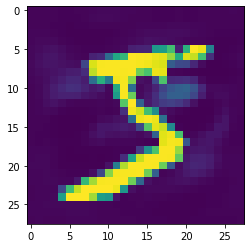

600
l2 dist: 1.3435972
target class:  3
pred of adv ex:  3


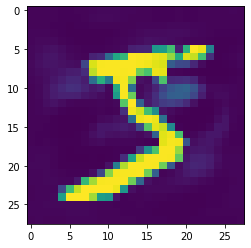

601
l2 dist: 1.3401458
target class:  3
pred of adv ex:  3


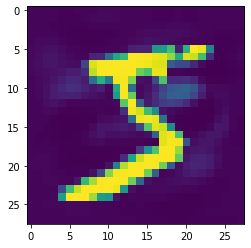

602
l2 dist: 1.3356651
target class:  3
pred of adv ex:  3


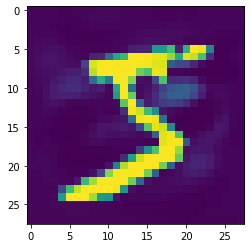

603
l2 dist: 1.3302972
target class:  3
pred of adv ex:  3


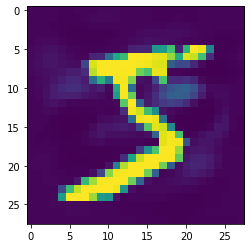

604
l2 dist: 1.3241724
target class:  3
pred of adv ex:  3


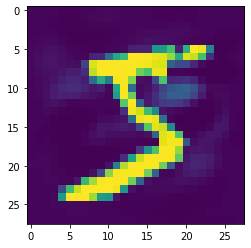

605
l2 dist: 1.3174076
target class:  3
pred of adv ex:  3


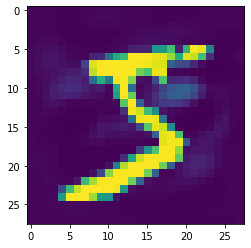

606
l2 dist: 1.3101076
target class:  3
pred of adv ex:  3


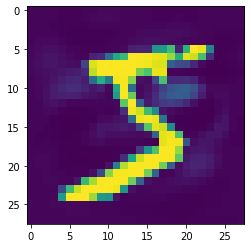

607
l2 dist: 1.302364
target class:  3
pred of adv ex:  3


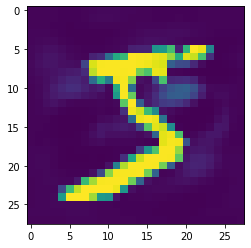

608
l2 dist: 1.2942575
target class:  3
pred of adv ex:  3


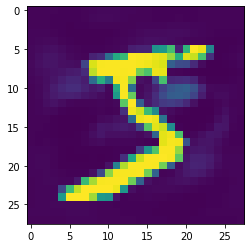

609
l2 dist: 1.2858574
target class:  3
pred of adv ex:  3


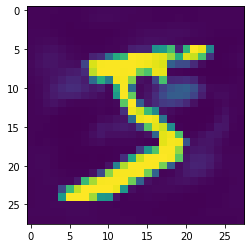

610
l2 dist: 1.2772238
target class:  3
pred of adv ex:  3


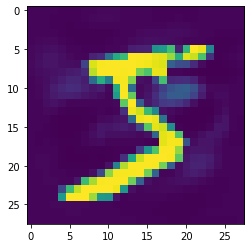

611
l2 dist: 1.2684077
target class:  3
pred of adv ex:  3


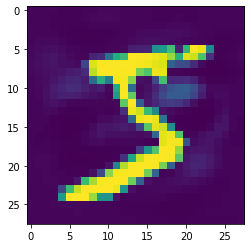

612
l2 dist: 1.2594532
target class:  3
pred of adv ex:  3


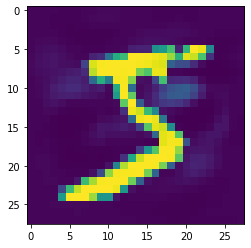

613
l2 dist: 1.2503978
target class:  3
pred of adv ex:  3


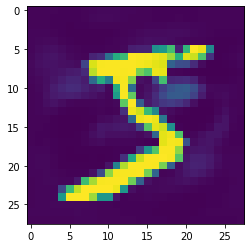

614
l2 dist: 1.2412742
target class:  3
pred of adv ex:  5


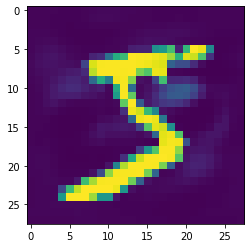

615
l2 dist: 1.2612147
target class:  3
pred of adv ex:  3


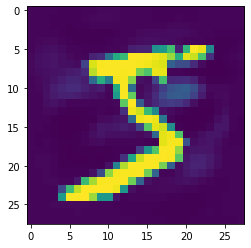

616
l2 dist: 1.2788438
target class:  3
pred of adv ex:  3


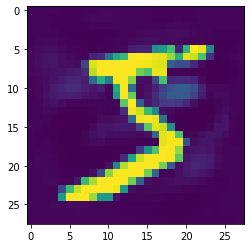

617
l2 dist: 1.294116
target class:  3
pred of adv ex:  3


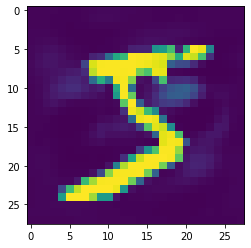

618
l2 dist: 1.3070297
target class:  3
pred of adv ex:  3


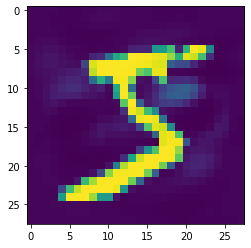

619
l2 dist: 1.317624
target class:  3
pred of adv ex:  3


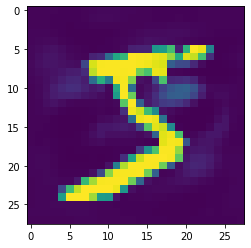

620
l2 dist: 1.3259746
target class:  3
pred of adv ex:  3


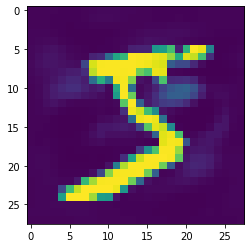

621
l2 dist: 1.3321888
target class:  3
pred of adv ex:  3


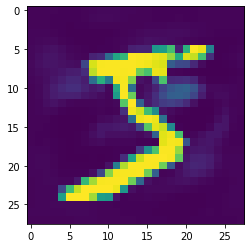

622
l2 dist: 1.3363991
target class:  3
pred of adv ex:  3


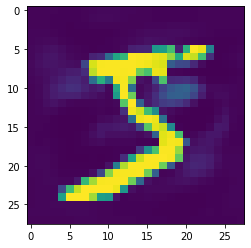

623
l2 dist: 1.3387569
target class:  3
pred of adv ex:  3


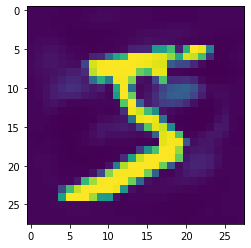

624
l2 dist: 1.3394252
target class:  3
pred of adv ex:  3


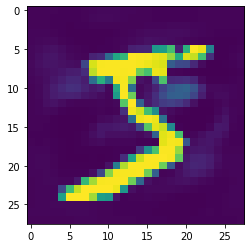

625
l2 dist: 1.3385724
target class:  3
pred of adv ex:  3


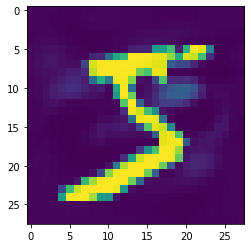

626
l2 dist: 1.3363664
target class:  3
pred of adv ex:  3


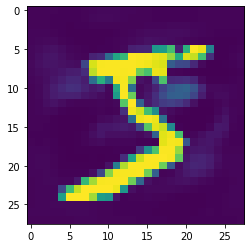

627
l2 dist: 1.3329703
target class:  3
pred of adv ex:  3


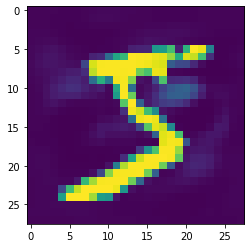

628
l2 dist: 1.3285381
target class:  3
pred of adv ex:  3


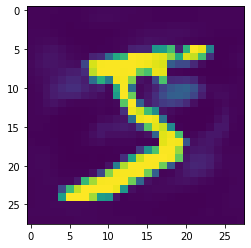

629
l2 dist: 1.3232135
target class:  3
pred of adv ex:  3


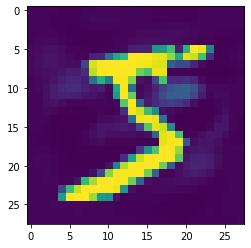

630
l2 dist: 1.3171276
target class:  3
pred of adv ex:  3


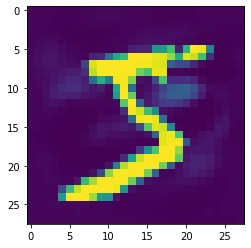

631
l2 dist: 1.3103983
target class:  3
pred of adv ex:  3


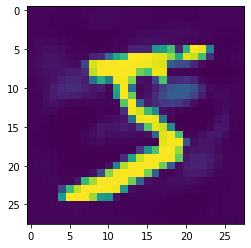

632
l2 dist: 1.3031312
target class:  3
pred of adv ex:  3


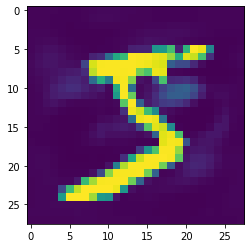

633
l2 dist: 1.2954187
target class:  3
pred of adv ex:  3


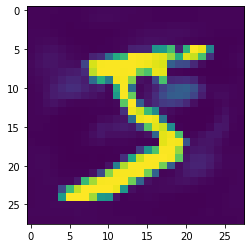

634
l2 dist: 1.287342
target class:  3
pred of adv ex:  3


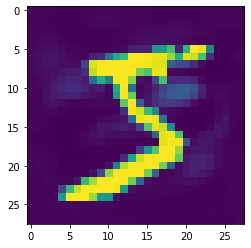

635
l2 dist: 1.2789705
target class:  3
pred of adv ex:  3


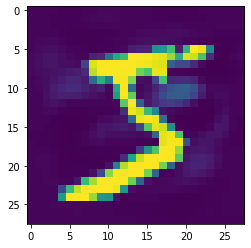

636
l2 dist: 1.2703644
target class:  3
pred of adv ex:  3


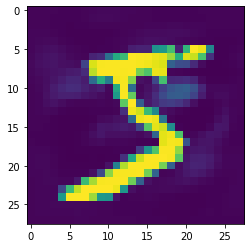

637
l2 dist: 1.261575
target class:  3
pred of adv ex:  3


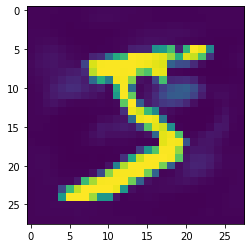

638
l2 dist: 1.2526461
target class:  3
pred of adv ex:  3


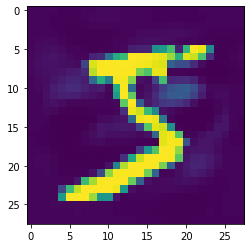

639
l2 dist: 1.2436149
target class:  3
pred of adv ex:  3


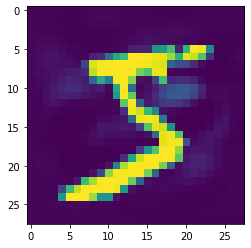

640
l2 dist: 1.2345141
target class:  3
pred of adv ex:  5


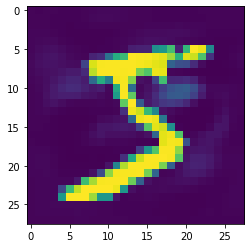

641
l2 dist: 1.2546377
target class:  3
pred of adv ex:  3


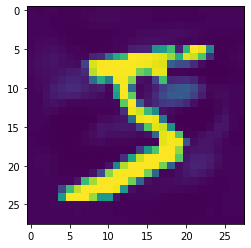

642
l2 dist: 1.2724495
target class:  3
pred of adv ex:  3


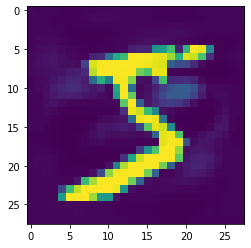

643
l2 dist: 1.2878972
target class:  3
pred of adv ex:  3


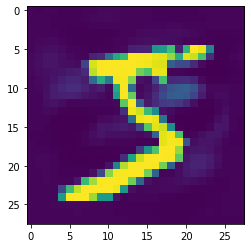

644
l2 dist: 1.3009739
target class:  3
pred of adv ex:  3


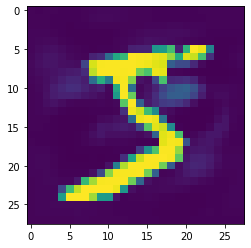

645
l2 dist: 1.3117149
target class:  3
pred of adv ex:  3


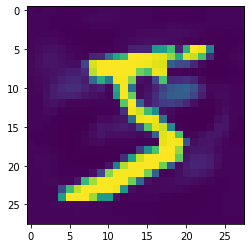

646
l2 dist: 1.3201938
target class:  3
pred of adv ex:  3


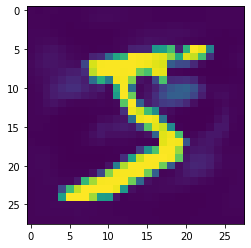

647
l2 dist: 1.326517
target class:  3
pred of adv ex:  3


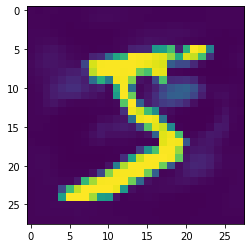

648
l2 dist: 1.3308178
target class:  3
pred of adv ex:  3


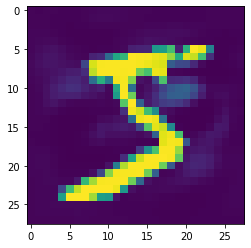

649
l2 dist: 1.3332493
target class:  3
pred of adv ex:  3


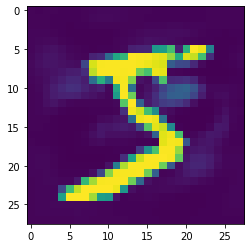

650
l2 dist: 1.3339761
target class:  3
pred of adv ex:  3


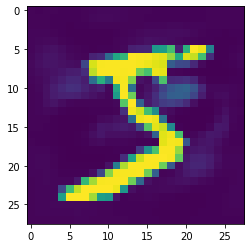

651
l2 dist: 1.3331691
target class:  3
pred of adv ex:  3


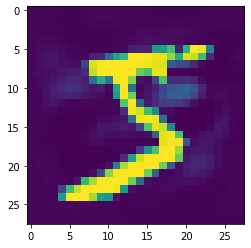

652
l2 dist: 1.3309983
target class:  3
pred of adv ex:  3


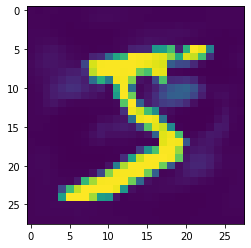

653
l2 dist: 1.3276285
target class:  3
pred of adv ex:  3


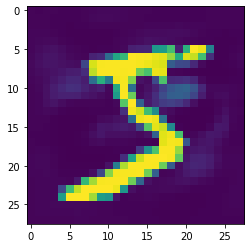

654
l2 dist: 1.323216
target class:  3
pred of adv ex:  3


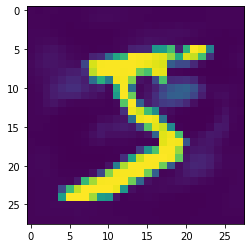

655
l2 dist: 1.3179057
target class:  3
pred of adv ex:  3


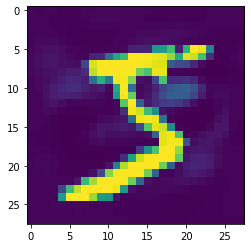

656
l2 dist: 1.3118298
target class:  3
pred of adv ex:  3


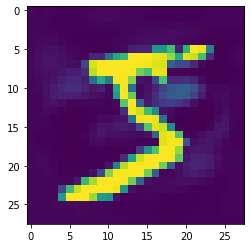

657
l2 dist: 1.3051077
target class:  3
pred of adv ex:  3


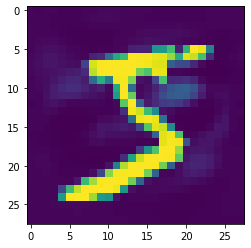

658
l2 dist: 1.2978454
target class:  3
pred of adv ex:  3


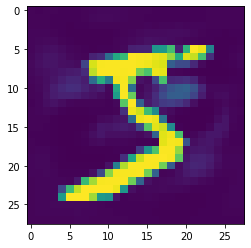

659
l2 dist: 1.2901362
target class:  3
pred of adv ex:  3


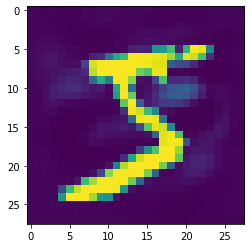

660
l2 dist: 1.2820617
target class:  3
pred of adv ex:  3


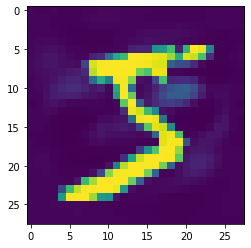

661
l2 dist: 1.2736918
target class:  3
pred of adv ex:  3


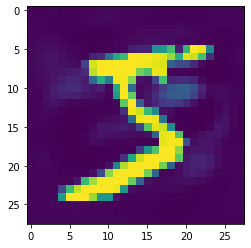

662
l2 dist: 1.2650867
target class:  3
pred of adv ex:  3


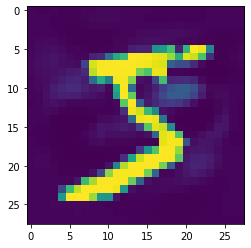

663
l2 dist: 1.2562975
target class:  3
pred of adv ex:  3


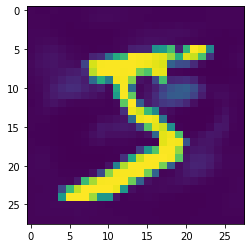

664
l2 dist: 1.247368
target class:  3
pred of adv ex:  3


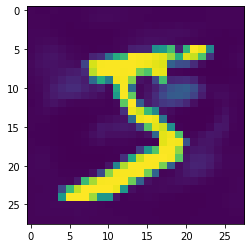

665
l2 dist: 1.2383353
target class:  3
pred of adv ex:  3


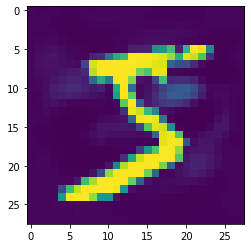

666
l2 dist: 1.2292318
target class:  3
pred of adv ex:  5


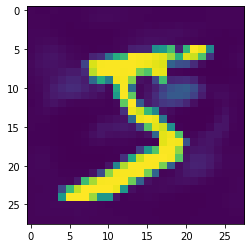

667
l2 dist: 1.24953
target class:  3
pred of adv ex:  3


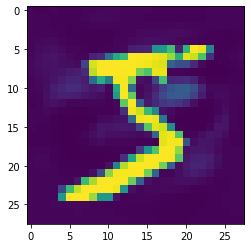

668
l2 dist: 1.2675134
target class:  3
pred of adv ex:  3


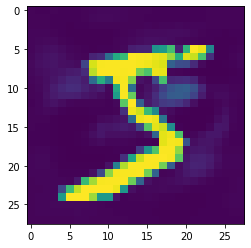

669
l2 dist: 1.2831242
target class:  3
pred of adv ex:  3


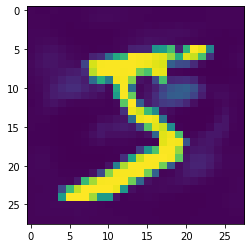

670
l2 dist: 1.2963505
target class:  3
pred of adv ex:  3


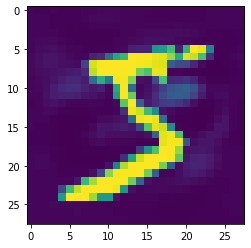

671
l2 dist: 1.3072239
target class:  3
pred of adv ex:  3


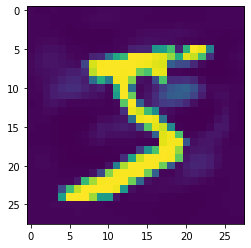

672
l2 dist: 1.3158162
target class:  3
pred of adv ex:  3


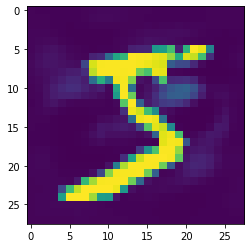

673
l2 dist: 1.3222331
target class:  3
pred of adv ex:  3


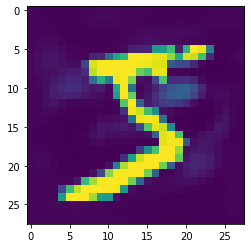

674
l2 dist: 1.3266088
target class:  3
pred of adv ex:  3


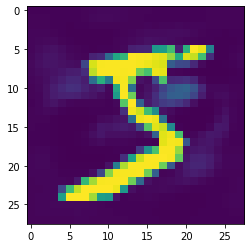

675
l2 dist: 1.3290976
target class:  3
pred of adv ex:  3


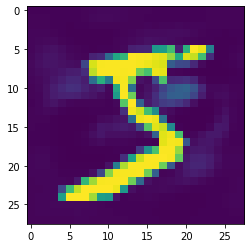

676
l2 dist: 1.3298666
target class:  3
pred of adv ex:  3


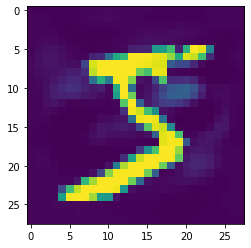

677
l2 dist: 1.3290886
target class:  3
pred of adv ex:  3


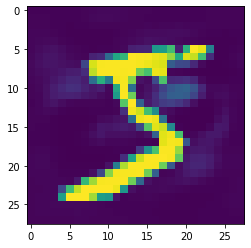

678
l2 dist: 1.3269361
target class:  3
pred of adv ex:  3


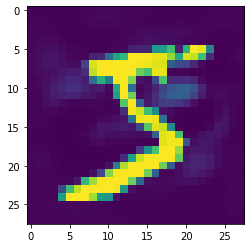

679
l2 dist: 1.323576
target class:  3
pred of adv ex:  3


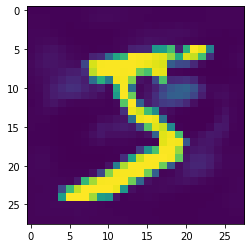

680
l2 dist: 1.3191663
target class:  3
pred of adv ex:  3


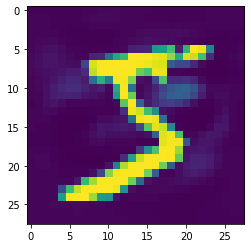

681
l2 dist: 1.3138534
target class:  3
pred of adv ex:  3


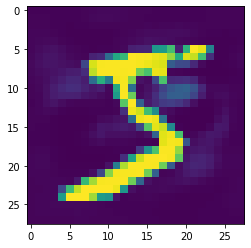

682
l2 dist: 1.3077712
target class:  3
pred of adv ex:  3


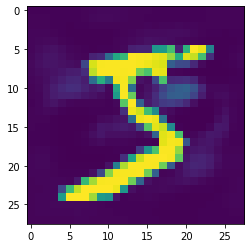

683
l2 dist: 1.3010398
target class:  3
pred of adv ex:  3


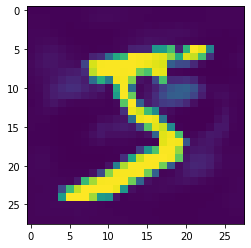

684
l2 dist: 1.2937664
target class:  3
pred of adv ex:  3


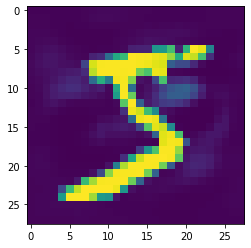

685
l2 dist: 1.286045
target class:  3
pred of adv ex:  3


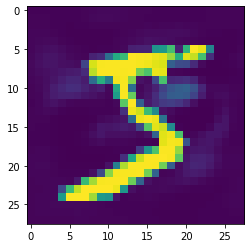

686
l2 dist: 1.2779571
target class:  3
pred of adv ex:  3


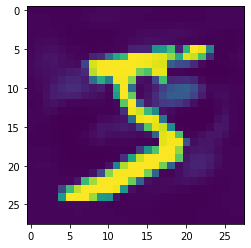

687
l2 dist: 1.2695736
target class:  3
pred of adv ex:  3


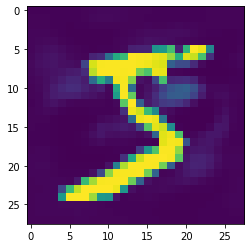

688
l2 dist: 1.2609543
target class:  3
pred of adv ex:  3


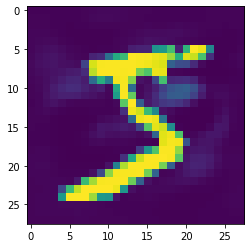

689
l2 dist: 1.2521504
target class:  3
pred of adv ex:  3


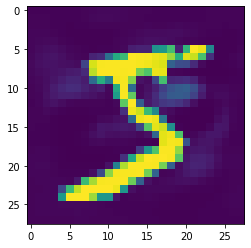

690
l2 dist: 1.2432054
target class:  3
pred of adv ex:  3


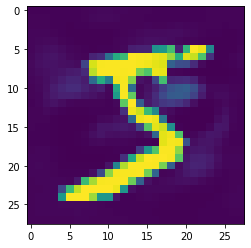

691
l2 dist: 1.2341567
target class:  3
pred of adv ex:  3


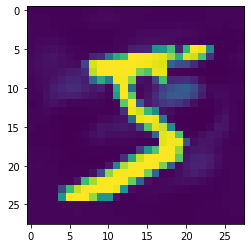

692
l2 dist: 1.2250363
target class:  3
pred of adv ex:  3


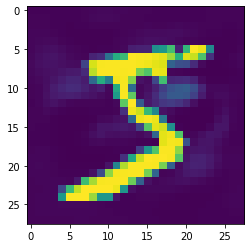

693
l2 dist: 1.2158725
target class:  3
pred of adv ex:  5


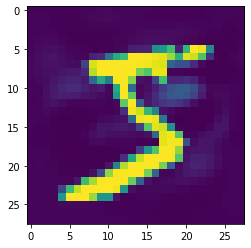

694
l2 dist: 1.2357646
target class:  3
pred of adv ex:  3


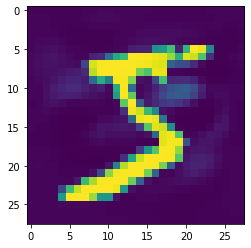

695
l2 dist: 1.2534418
target class:  3
pred of adv ex:  3


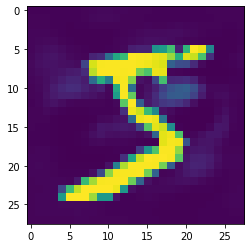

696
l2 dist: 1.2688307
target class:  3
pred of adv ex:  3


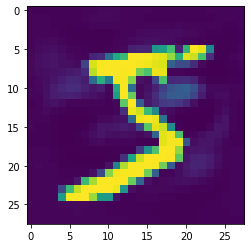

697
l2 dist: 1.2819043
target class:  3
pred of adv ex:  3


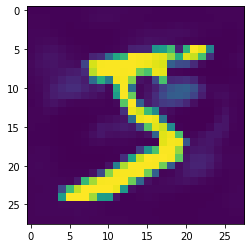

698
l2 dist: 1.292681
target class:  3
pred of adv ex:  3


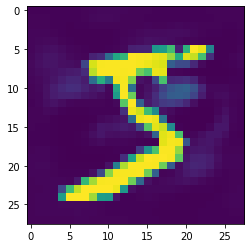

699
l2 dist: 1.3012204
target class:  3
pred of adv ex:  3


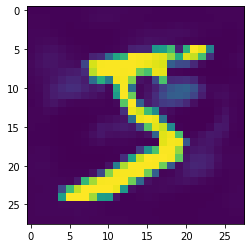

700
l2 dist: 1.3076187
target class:  3
pred of adv ex:  3


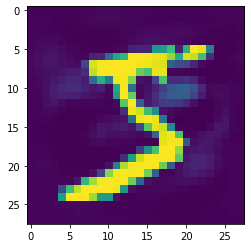

701
l2 dist: 1.3120025
target class:  3
pred of adv ex:  3


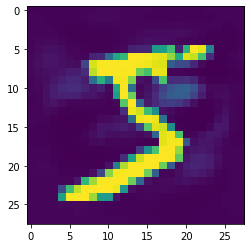

702
l2 dist: 1.3145202
target class:  3
pred of adv ex:  3


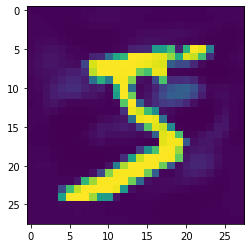

703
l2 dist: 1.3153344
target class:  3
pred of adv ex:  3


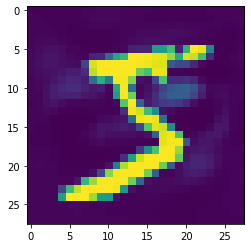

704
l2 dist: 1.3146152
target class:  3
pred of adv ex:  3


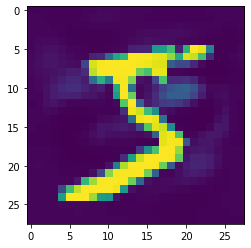

705
l2 dist: 1.312533
target class:  3
pred of adv ex:  3


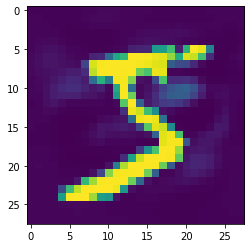

706
l2 dist: 1.3092538
target class:  3
pred of adv ex:  3


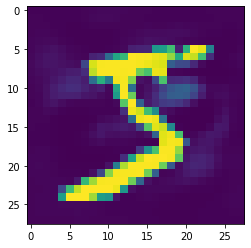

707
l2 dist: 1.3049352
target class:  3
pred of adv ex:  3


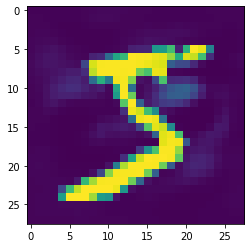

708
l2 dist: 1.2997235
target class:  3
pred of adv ex:  3


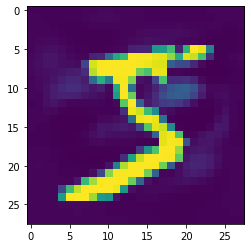

709
l2 dist: 1.2937527
target class:  3
pred of adv ex:  3


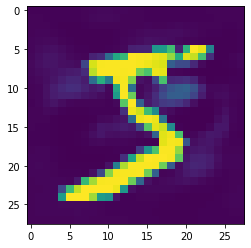

710
l2 dist: 1.2871431
target class:  3
pred of adv ex:  3


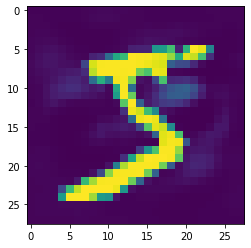

711
l2 dist: 1.2800014
target class:  3
pred of adv ex:  3


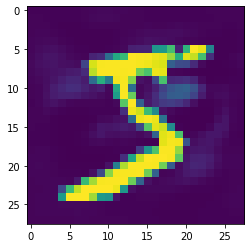

712
l2 dist: 1.272421
target class:  3
pred of adv ex:  3


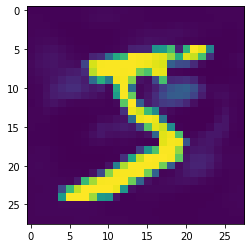

713
l2 dist: 1.2644827
target class:  3
pred of adv ex:  3


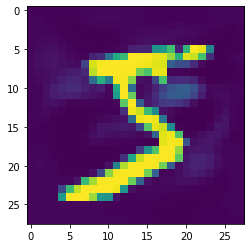

714
l2 dist: 1.2562554
target class:  3
pred of adv ex:  3


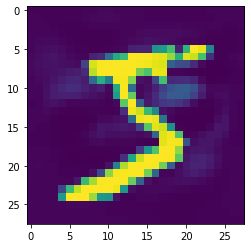

715
l2 dist: 1.2477975
target class:  3
pred of adv ex:  3


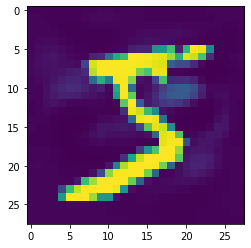

716
l2 dist: 1.2391586
target class:  3
pred of adv ex:  3


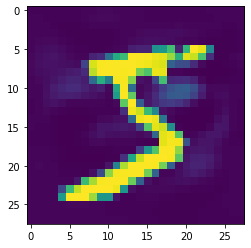

717
l2 dist: 1.2303802
target class:  3
pred of adv ex:  3


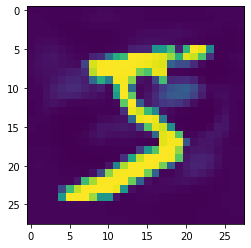

718
l2 dist: 1.2214978
target class:  3
pred of adv ex:  3


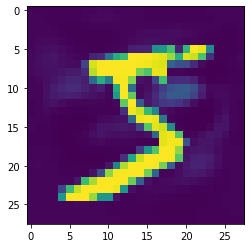

719
l2 dist: 1.2125424
target class:  3
pred of adv ex:  5


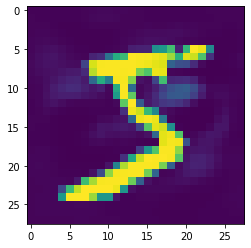

720
l2 dist: 1.232963
target class:  3
pred of adv ex:  3


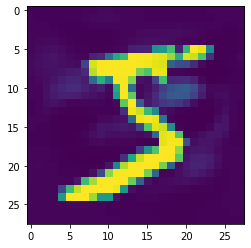

721
l2 dist: 1.2510989
target class:  3
pred of adv ex:  3


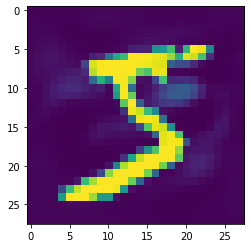

722
l2 dist: 1.2668798
target class:  3
pred of adv ex:  3


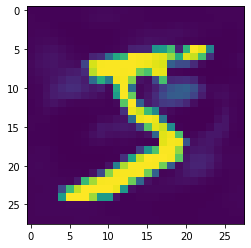

723
l2 dist: 1.280283
target class:  3
pred of adv ex:  3


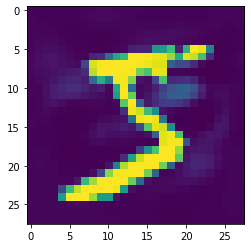

724
l2 dist: 1.2913319
target class:  3
pred of adv ex:  3


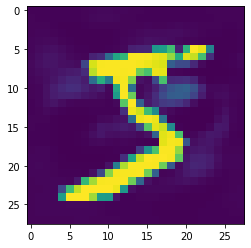

725
l2 dist: 1.3000923
target class:  3
pred of adv ex:  3


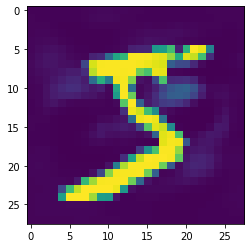

726
l2 dist: 1.3066671
target class:  3
pred of adv ex:  3


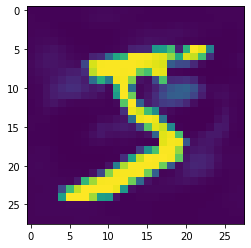

727
l2 dist: 1.3111885
target class:  3
pred of adv ex:  3


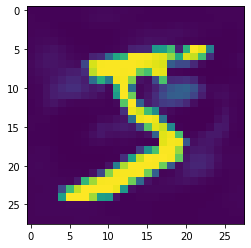

728
l2 dist: 1.3138108
target class:  3
pred of adv ex:  3


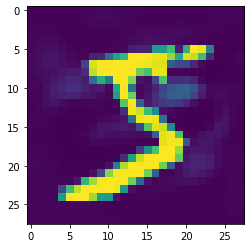

729
l2 dist: 1.3147024
target class:  3
pred of adv ex:  3


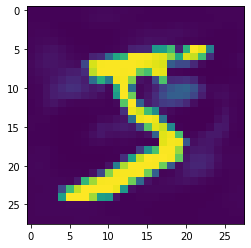

730
l2 dist: 1.3140376
target class:  3
pred of adv ex:  3


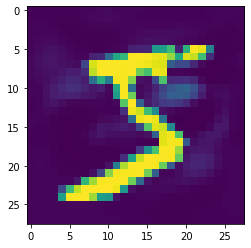

731
l2 dist: 1.3119906
target class:  3
pred of adv ex:  3


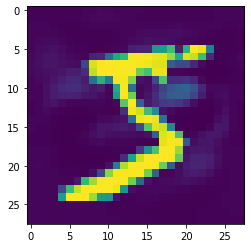

732
l2 dist: 1.3087302
target class:  3
pred of adv ex:  3


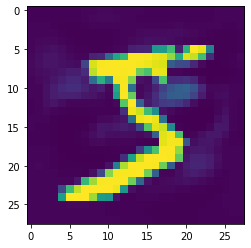

733
l2 dist: 1.3044161
target class:  3
pred of adv ex:  3


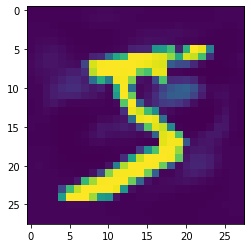

734
l2 dist: 1.2991962
target class:  3
pred of adv ex:  3


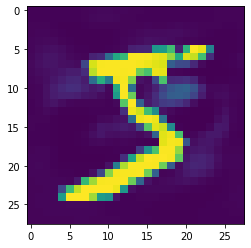

735
l2 dist: 1.2932059
target class:  3
pred of adv ex:  3


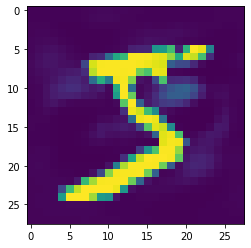

736
l2 dist: 1.2865661
target class:  3
pred of adv ex:  3


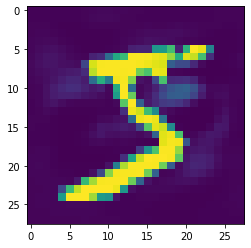

737
l2 dist: 1.2793853
target class:  3
pred of adv ex:  3


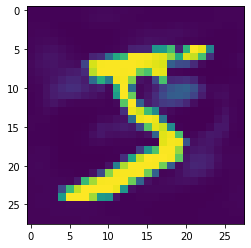

738
l2 dist: 1.2717578
target class:  3
pred of adv ex:  3


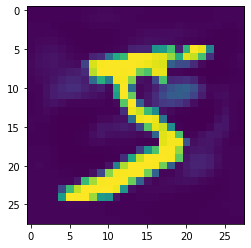

739
l2 dist: 1.2637655
target class:  3
pred of adv ex:  3


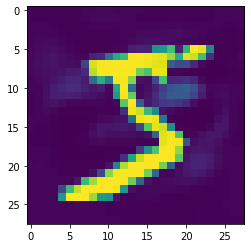

740
l2 dist: 1.2554784
target class:  3
pred of adv ex:  3


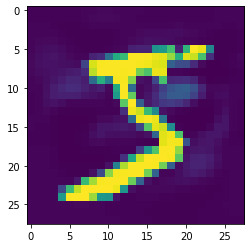

741
l2 dist: 1.2469565
target class:  3
pred of adv ex:  3


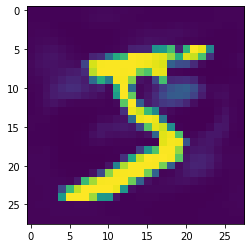

742
l2 dist: 1.2382499
target class:  3
pred of adv ex:  3


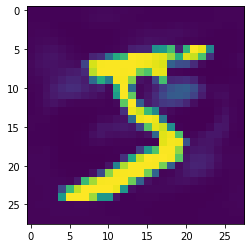

743
l2 dist: 1.2294015
target class:  3
pred of adv ex:  3


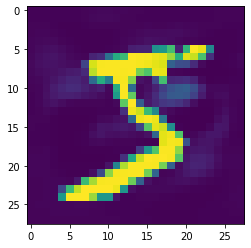

744
l2 dist: 1.2204471
target class:  3
pred of adv ex:  3


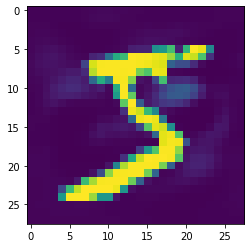

745
l2 dist: 1.2114187
target class:  3
pred of adv ex:  5


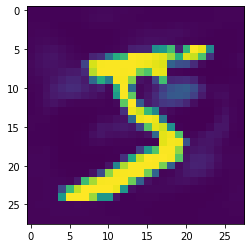

746
l2 dist: 1.2320521
target class:  3
pred of adv ex:  3


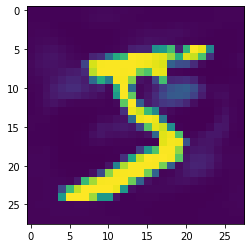

747
l2 dist: 1.2503858
target class:  3
pred of adv ex:  3


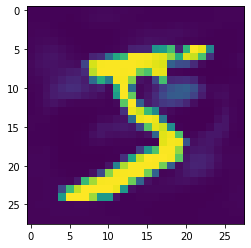

748
l2 dist: 1.2663441
target class:  3
pred of adv ex:  3


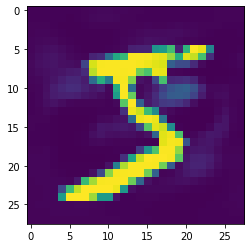

749
l2 dist: 1.2798998
target class:  3
pred of adv ex:  3


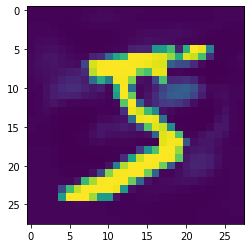

750
l2 dist: 1.2910739
target class:  3
pred of adv ex:  3


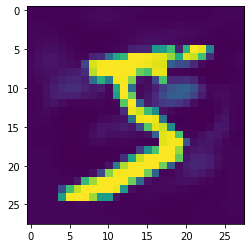

751
l2 dist: 1.2999307
target class:  3
pred of adv ex:  3


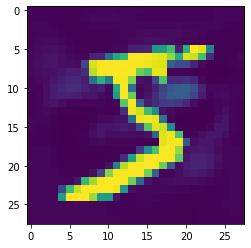

752
l2 dist: 1.3065736
target class:  3
pred of adv ex:  3


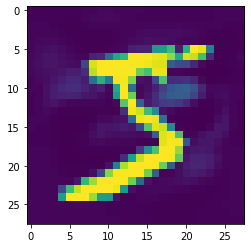

753
l2 dist: 1.3111371
target class:  3
pred of adv ex:  3


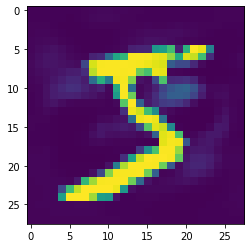

754
l2 dist: 1.313778
target class:  3
pred of adv ex:  3


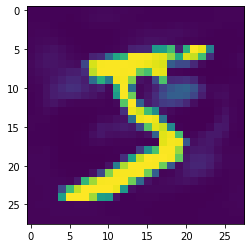

755
l2 dist: 1.3146685
target class:  3
pred of adv ex:  3


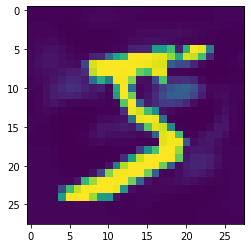

756
l2 dist: 1.313986
target class:  3
pred of adv ex:  3


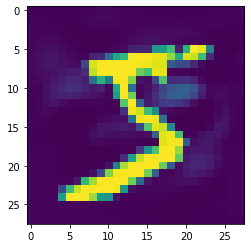

757
l2 dist: 1.311908
target class:  3
pred of adv ex:  3


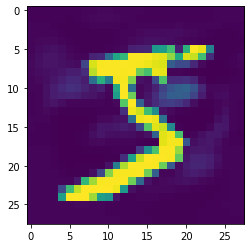

758
l2 dist: 1.3086061
target class:  3
pred of adv ex:  3


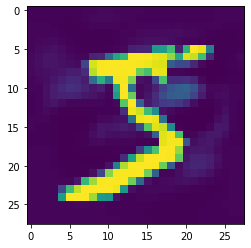

759
l2 dist: 1.3042425
target class:  3
pred of adv ex:  3


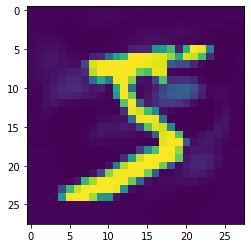

760
l2 dist: 1.2989672
target class:  3
pred of adv ex:  3


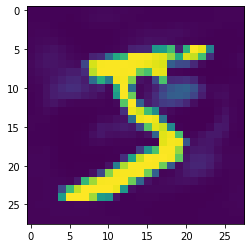

761
l2 dist: 1.2929168
target class:  3
pred of adv ex:  3


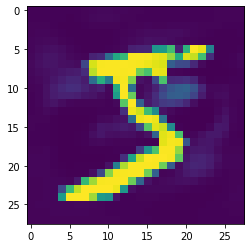

762
l2 dist: 1.286214
target class:  3
pred of adv ex:  3


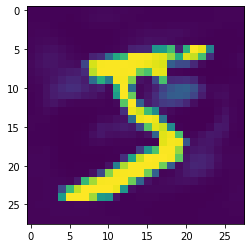

763
l2 dist: 1.2789675
target class:  3
pred of adv ex:  3


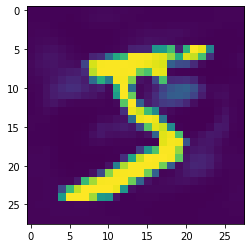

764
l2 dist: 1.2712728
target class:  3
pred of adv ex:  3


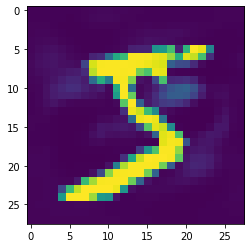

765
l2 dist: 1.263212
target class:  3
pred of adv ex:  3


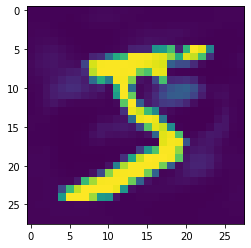

766
l2 dist: 1.2548559
target class:  3
pred of adv ex:  3


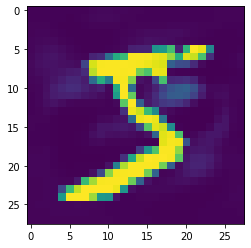

767
l2 dist: 1.2462645
target class:  3
pred of adv ex:  3


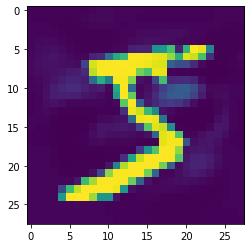

768
l2 dist: 1.2374879
target class:  3
pred of adv ex:  3


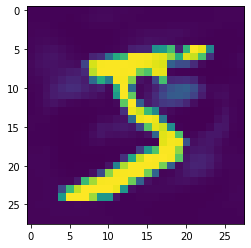

769
l2 dist: 1.2285691
target class:  3
pred of adv ex:  3


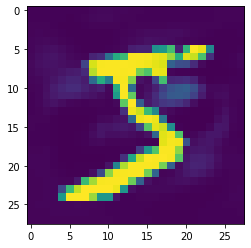

770
l2 dist: 1.2195446
target class:  3
pred of adv ex:  3


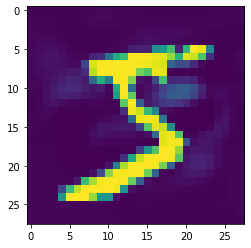

771
l2 dist: 1.2104458
target class:  3
pred of adv ex:  3


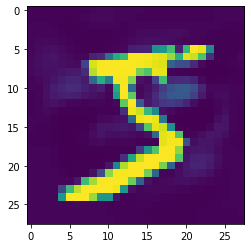

772
l2 dist: 1.2013009
target class:  3
pred of adv ex:  5


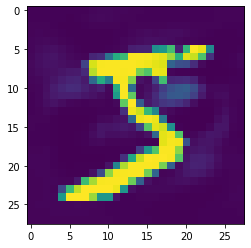

773
l2 dist: 1.2215159
target class:  3
pred of adv ex:  3


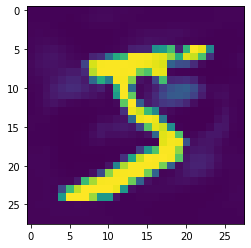

774
l2 dist: 1.239529
target class:  3
pred of adv ex:  3


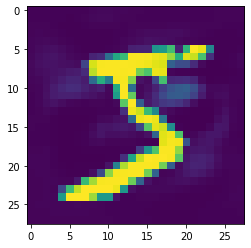

775
l2 dist: 1.2552493
target class:  3
pred of adv ex:  3


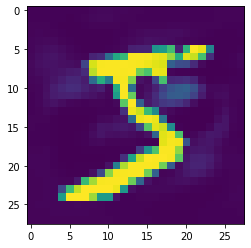

776
l2 dist: 1.2686346
target class:  3
pred of adv ex:  3


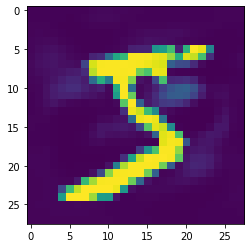

777
l2 dist: 1.2796916
target class:  3
pred of adv ex:  3


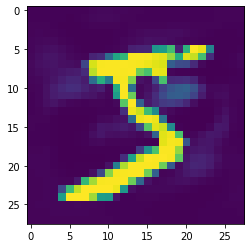

778
l2 dist: 1.2884734
target class:  3
pred of adv ex:  3


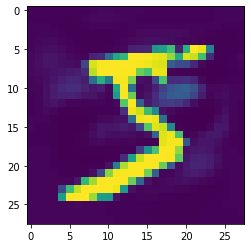

779
l2 dist: 1.2950733
target class:  3
pred of adv ex:  3


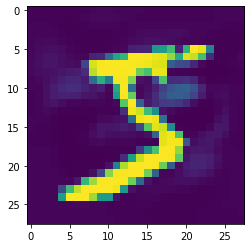

780
l2 dist: 1.2996176
target class:  3
pred of adv ex:  3


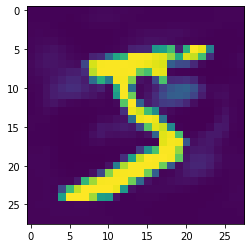

781
l2 dist: 1.3022583
target class:  3
pred of adv ex:  3


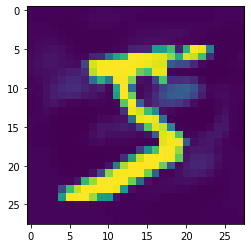

782
l2 dist: 1.3031623
target class:  3
pred of adv ex:  3


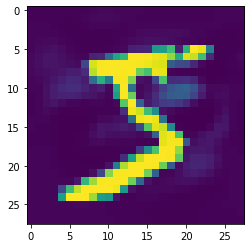

783
l2 dist: 1.302505
target class:  3
pred of adv ex:  3


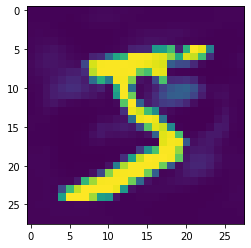

784
l2 dist: 1.3004622
target class:  3
pred of adv ex:  3


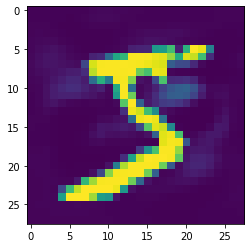

785
l2 dist: 1.2972057
target class:  3
pred of adv ex:  3


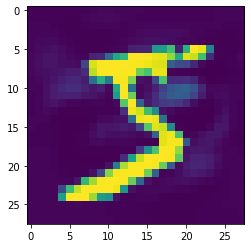

786
l2 dist: 1.292897
target class:  3
pred of adv ex:  3


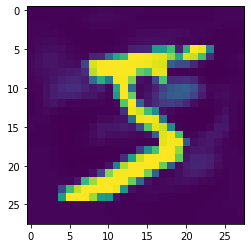

787
l2 dist: 1.2876868
target class:  3
pred of adv ex:  3


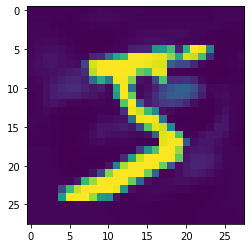

788
l2 dist: 1.2817123
target class:  3
pred of adv ex:  3


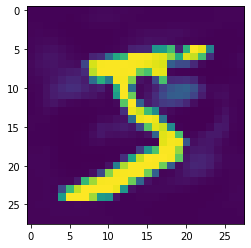

789
l2 dist: 1.2750962
target class:  3
pred of adv ex:  3


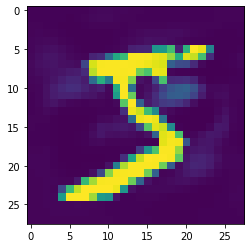

790
l2 dist: 1.267947
target class:  3
pred of adv ex:  3


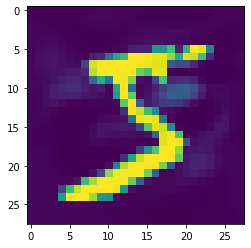

791
l2 dist: 1.2603593
target class:  3
pred of adv ex:  3


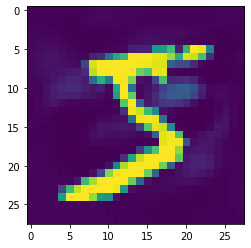

792
l2 dist: 1.2524145
target class:  3
pred of adv ex:  3


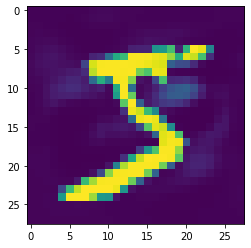

793
l2 dist: 1.2441812
target class:  3
pred of adv ex:  3


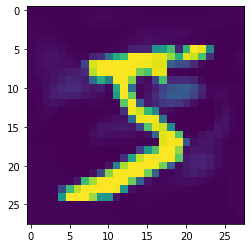

794
l2 dist: 1.2357174
target class:  3
pred of adv ex:  3


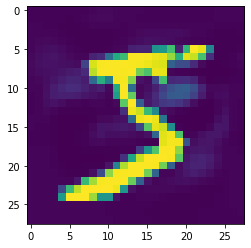

795
l2 dist: 1.2270719
target class:  3
pred of adv ex:  3


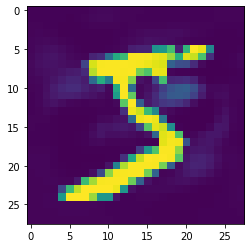

796
l2 dist: 1.2182857
target class:  3
pred of adv ex:  3


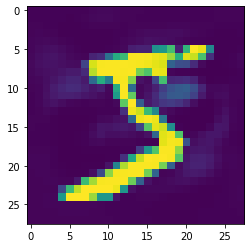

797
l2 dist: 1.2093935
target class:  3
pred of adv ex:  3


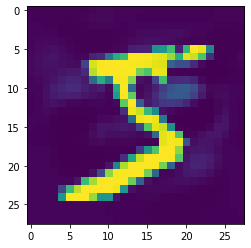

798
l2 dist: 1.2004257
target class:  3
pred of adv ex:  5


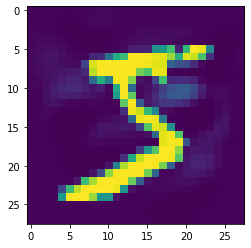

799
l2 dist: 1.2211779
target class:  3
pred of adv ex:  3


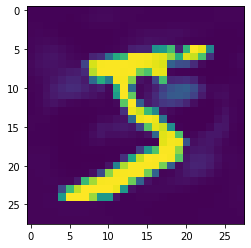

800
l2 dist: 1.2396505
target class:  3
pred of adv ex:  3


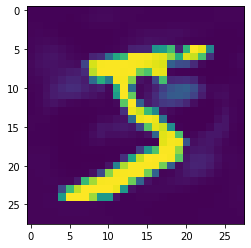

801
l2 dist: 1.2557575
target class:  3
pred of adv ex:  3


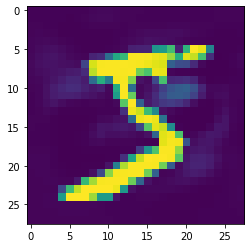

802
l2 dist: 1.2694627
target class:  3
pred of adv ex:  3


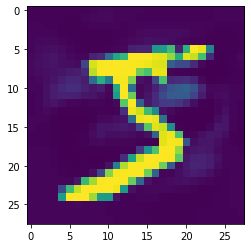

803
l2 dist: 1.2807798
target class:  3
pred of adv ex:  3


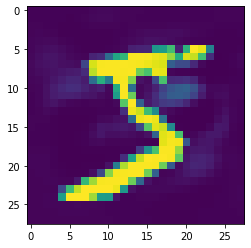

804
l2 dist: 1.2897687
target class:  3
pred of adv ex:  3


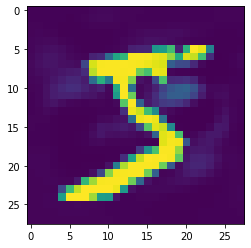

805
l2 dist: 1.2965295
target class:  3
pred of adv ex:  3


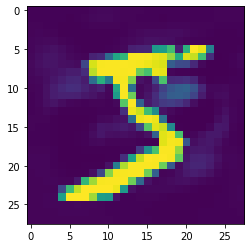

806
l2 dist: 1.3011959
target class:  3
pred of adv ex:  3


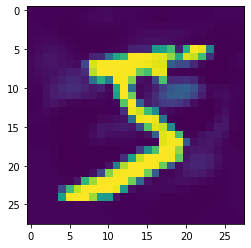

807
l2 dist: 1.3039253
target class:  3
pred of adv ex:  3


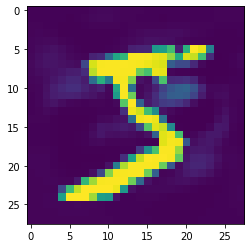

808
l2 dist: 1.3048906
target class:  3
pred of adv ex:  3


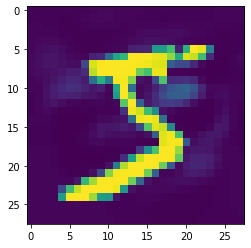

809
l2 dist: 1.3042715
target class:  3
pred of adv ex:  3


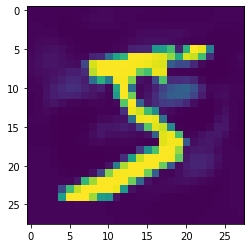

810
l2 dist: 1.3022473
target class:  3
pred of adv ex:  3


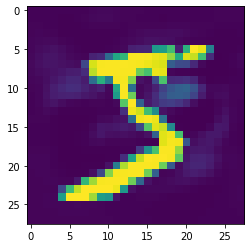

811
l2 dist: 1.2989923
target class:  3
pred of adv ex:  3


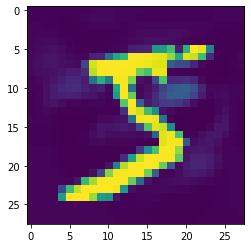

812
l2 dist: 1.29467
target class:  3
pred of adv ex:  3


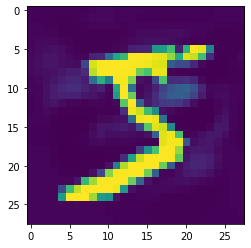

813
l2 dist: 1.2894325
target class:  3
pred of adv ex:  3


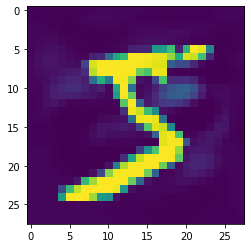

814
l2 dist: 1.2834179
target class:  3
pred of adv ex:  3


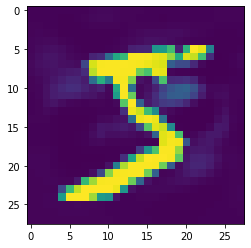

815
l2 dist: 1.2767503
target class:  3
pred of adv ex:  3


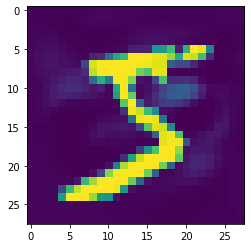

816
l2 dist: 1.2695394
target class:  3
pred of adv ex:  3


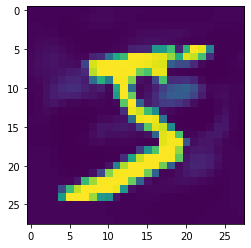

817
l2 dist: 1.2618809
target class:  3
pred of adv ex:  3


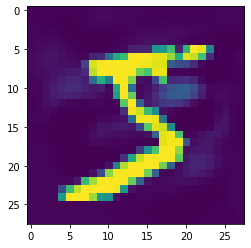

818
l2 dist: 1.2538574
target class:  3
pred of adv ex:  3


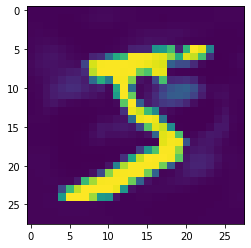

819
l2 dist: 1.2455395
target class:  3
pred of adv ex:  3


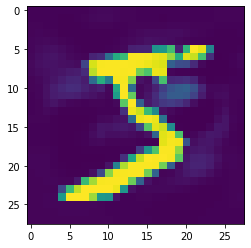

820
l2 dist: 1.2369865
target class:  3
pred of adv ex:  3


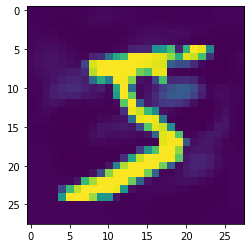

821
l2 dist: 1.2282482
target class:  3
pred of adv ex:  3


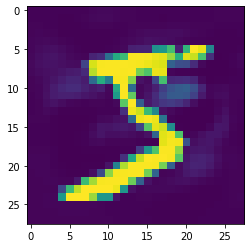

822
l2 dist: 1.2193668
target class:  3
pred of adv ex:  3


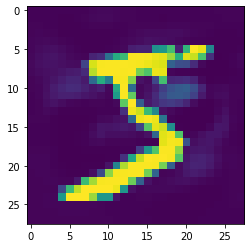

823
l2 dist: 1.2103782
target class:  3
pred of adv ex:  3


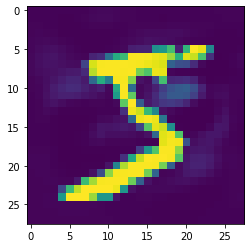

824
l2 dist: 1.2013133
target class:  3
pred of adv ex:  3


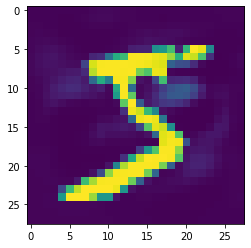

825
l2 dist: 1.1922005
target class:  3
pred of adv ex:  5


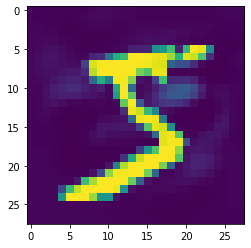

826
l2 dist: 1.2125518
target class:  3
pred of adv ex:  3


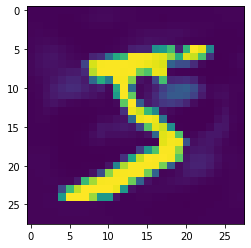

827
l2 dist: 1.2307156
target class:  3
pred of adv ex:  3


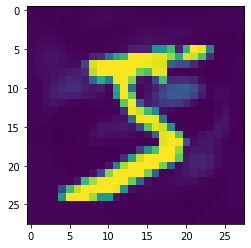

828
l2 dist: 1.24659
target class:  3
pred of adv ex:  3


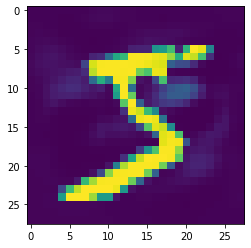

829
l2 dist: 1.2601236
target class:  3
pred of adv ex:  3


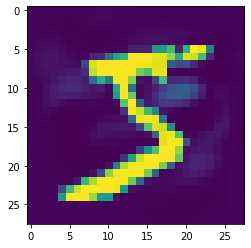

830
l2 dist: 1.2713164
target class:  3
pred of adv ex:  3


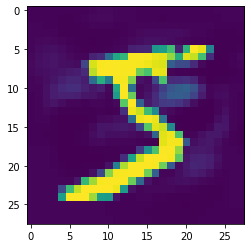

831
l2 dist: 1.2802169
target class:  3
pred of adv ex:  3


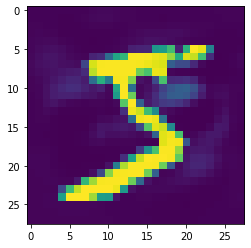

832
l2 dist: 1.2869163
target class:  3
pred of adv ex:  3


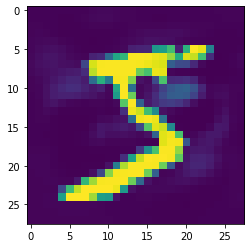

833
l2 dist: 1.2915411
target class:  3
pred of adv ex:  3


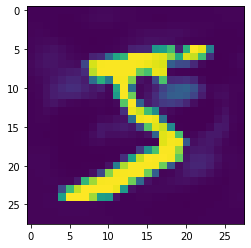

834
l2 dist: 1.294244
target class:  3
pred of adv ex:  3


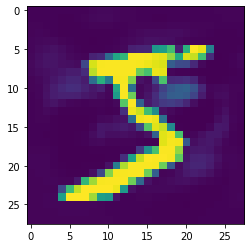

835
l2 dist: 1.295195
target class:  3
pred of adv ex:  3


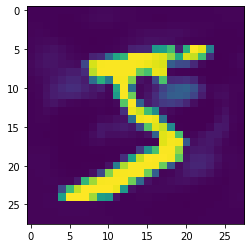

836
l2 dist: 1.294572
target class:  3
pred of adv ex:  3


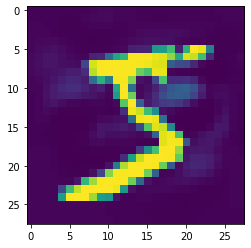

837
l2 dist: 1.2925538
target class:  3
pred of adv ex:  3


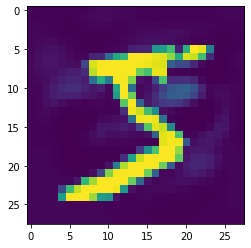

838
l2 dist: 1.2893144
target class:  3
pred of adv ex:  3


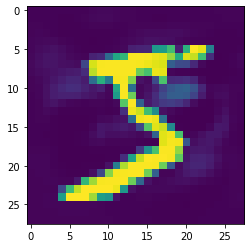

839
l2 dist: 1.2850184
target class:  3
pred of adv ex:  3


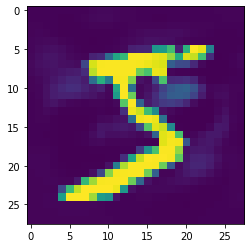

840
l2 dist: 1.2798179
target class:  3
pred of adv ex:  3


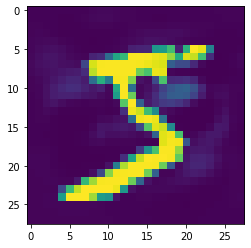

841
l2 dist: 1.2738519
target class:  3
pred of adv ex:  3


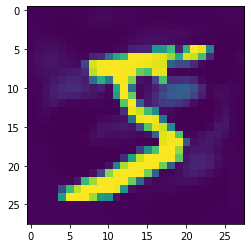

842
l2 dist: 1.267244
target class:  3
pred of adv ex:  3


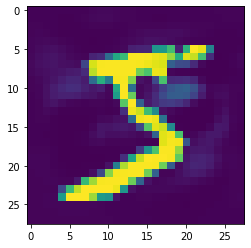

843
l2 dist: 1.2601036
target class:  3
pred of adv ex:  3


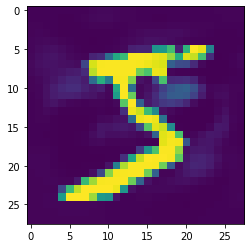

844
l2 dist: 1.2525257
target class:  3
pred of adv ex:  3


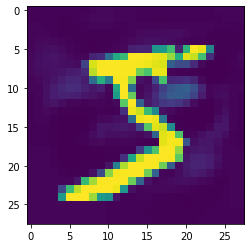

845
l2 dist: 1.2445914
target class:  3
pred of adv ex:  3


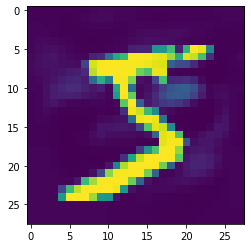

846
l2 dist: 1.2363695
target class:  3
pred of adv ex:  3


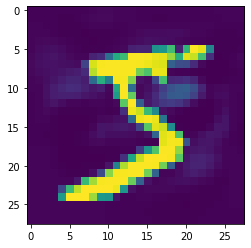

847
l2 dist: 1.2279177
target class:  3
pred of adv ex:  3


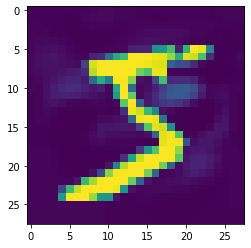

848
l2 dist: 1.2192839
target class:  3
pred of adv ex:  3


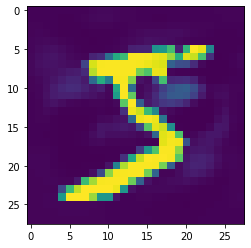

849
l2 dist: 1.2105087
target class:  3
pred of adv ex:  3


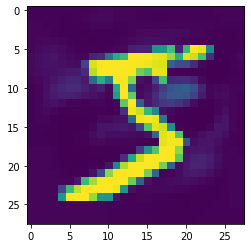

850
l2 dist: 1.2016265
target class:  3
pred of adv ex:  3


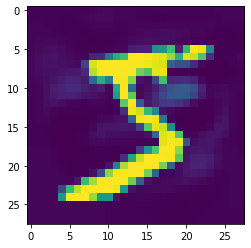

851
l2 dist: 1.1926681
target class:  3
pred of adv ex:  5


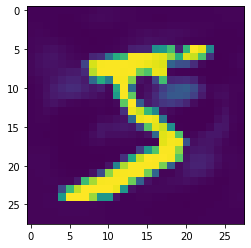

852
l2 dist: 1.2135658
target class:  3
pred of adv ex:  3


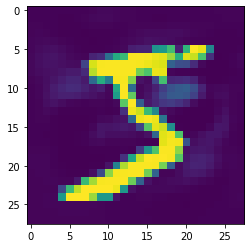

853
l2 dist: 1.2321938
target class:  3
pred of adv ex:  3


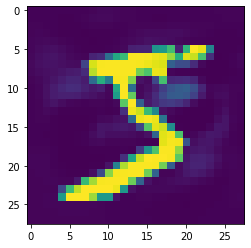

854
l2 dist: 1.2484561
target class:  3
pred of adv ex:  3


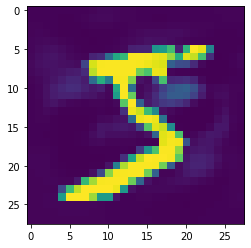

855
l2 dist: 1.2623078
target class:  3
pred of adv ex:  3


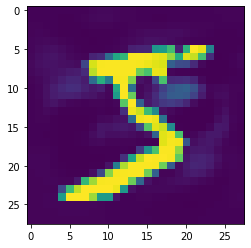

856
l2 dist: 1.2737561
target class:  3
pred of adv ex:  3


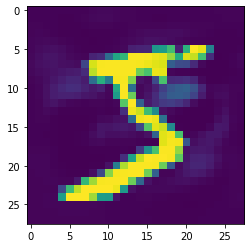

857
l2 dist: 1.2828571
target class:  3
pred of adv ex:  3


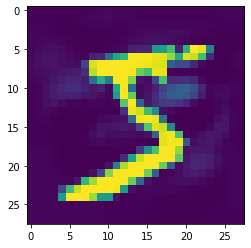

858
l2 dist: 1.2897094
target class:  3
pred of adv ex:  3


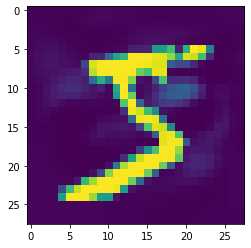

859
l2 dist: 1.2944472
target class:  3
pred of adv ex:  3


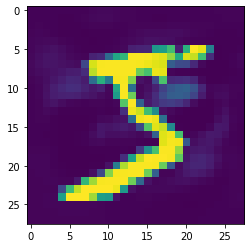

860
l2 dist: 1.2972289
target class:  3
pred of adv ex:  3


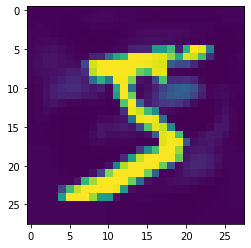

861
l2 dist: 1.2982308
target class:  3
pred of adv ex:  3


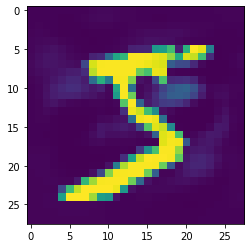

862
l2 dist: 1.297635
target class:  3
pred of adv ex:  3


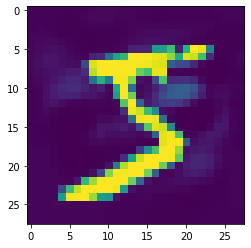

863
l2 dist: 1.2956241
target class:  3
pred of adv ex:  3


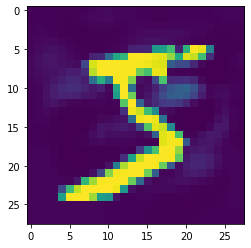

864
l2 dist: 1.2923745
target class:  3
pred of adv ex:  3


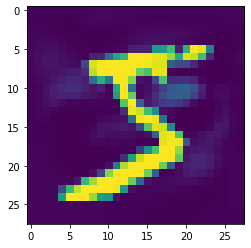

865
l2 dist: 1.2880528
target class:  3
pred of adv ex:  3


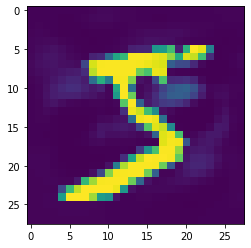

866
l2 dist: 1.2828125
target class:  3
pred of adv ex:  3


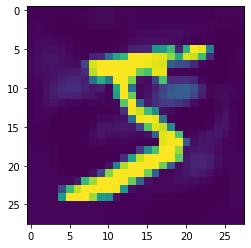

867
l2 dist: 1.2767935
target class:  3
pred of adv ex:  3


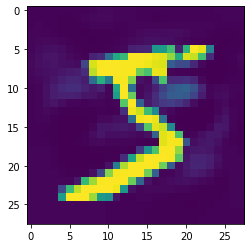

868
l2 dist: 1.2701204
target class:  3
pred of adv ex:  3


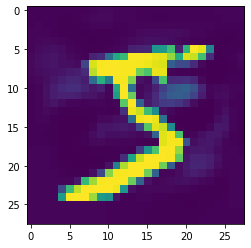

869
l2 dist: 1.2629042
target class:  3
pred of adv ex:  3


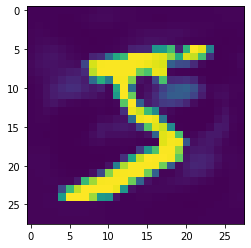

870
l2 dist: 1.2552409
target class:  3
pred of adv ex:  3


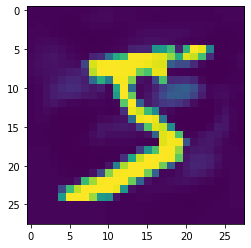

871
l2 dist: 1.2472134
target class:  3
pred of adv ex:  3


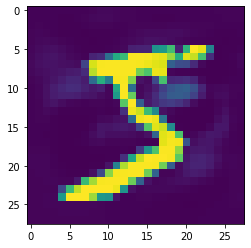

872
l2 dist: 1.238892
target class:  3
pred of adv ex:  3


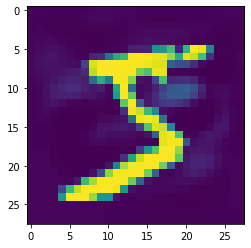

873
l2 dist: 1.2303358
target class:  3
pred of adv ex:  3


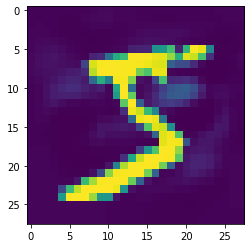

874
l2 dist: 1.2215942
target class:  3
pred of adv ex:  3


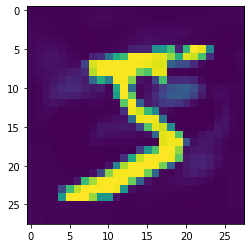

875
l2 dist: 1.2127091
target class:  3
pred of adv ex:  3


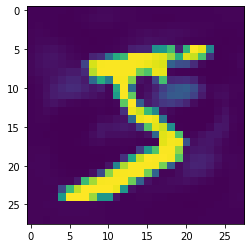

876
l2 dist: 1.2037157
target class:  3
pred of adv ex:  3


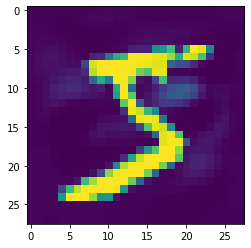

877
l2 dist: 1.1946455
target class:  3
pred of adv ex:  3


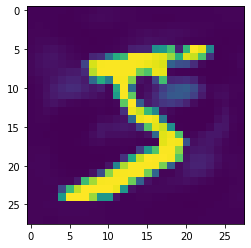

878
l2 dist: 1.1855261
target class:  3
pred of adv ex:  5


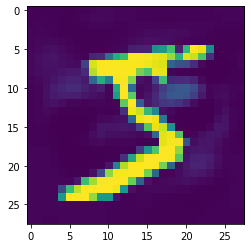

879
l2 dist: 1.2060246
target class:  3
pred of adv ex:  3


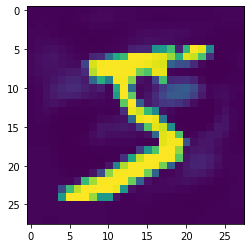

880
l2 dist: 1.2243446
target class:  3
pred of adv ex:  3


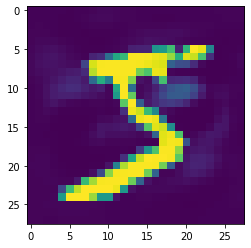

881
l2 dist: 1.2403741
target class:  3
pred of adv ex:  3


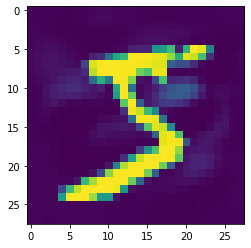

882
l2 dist: 1.2540534
target class:  3
pred of adv ex:  3


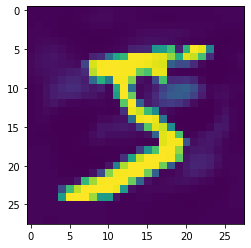

883
l2 dist: 1.2653756
target class:  3
pred of adv ex:  3


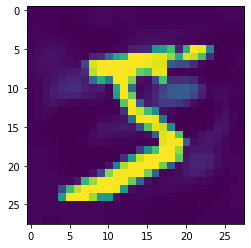

884
l2 dist: 1.2743853
target class:  3
pred of adv ex:  3


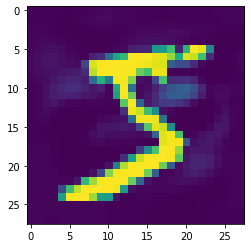

885
l2 dist: 1.2811722
target class:  3
pred of adv ex:  3


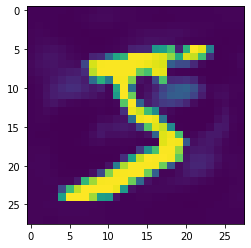

886
l2 dist: 1.2858632
target class:  3
pred of adv ex:  3


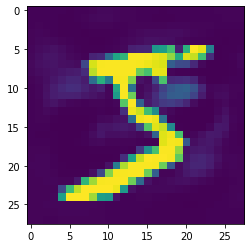

887
l2 dist: 1.2886125
target class:  3
pred of adv ex:  3


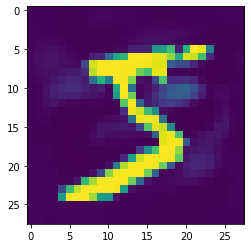

888
l2 dist: 1.2895931
target class:  3
pred of adv ex:  3


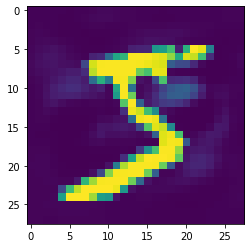

889
l2 dist: 1.2889858
target class:  3
pred of adv ex:  3


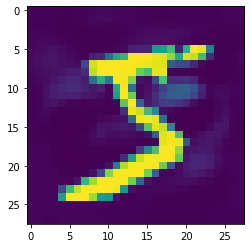

890
l2 dist: 1.2869729
target class:  3
pred of adv ex:  3


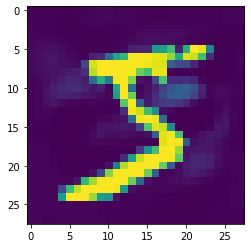

891
l2 dist: 1.2837306
target class:  3
pred of adv ex:  3


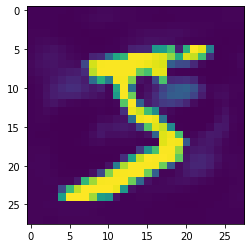

892
l2 dist: 1.2794263
target class:  3
pred of adv ex:  3


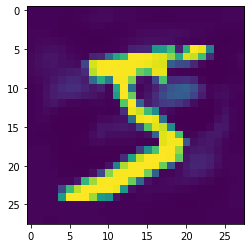

893
l2 dist: 1.2742143
target class:  3
pred of adv ex:  3


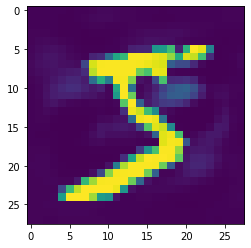

894
l2 dist: 1.2682345
target class:  3
pred of adv ex:  3


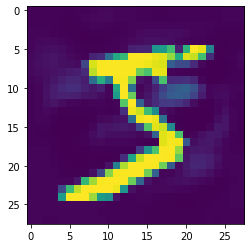

895
l2 dist: 1.2616122
target class:  3
pred of adv ex:  3


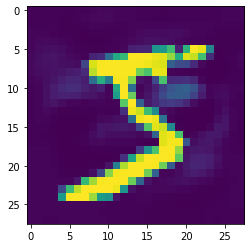

896
l2 dist: 1.2544574
target class:  3
pred of adv ex:  3


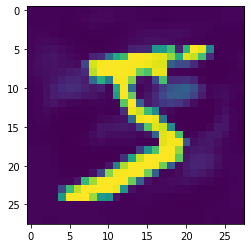

897
l2 dist: 1.2468652
target class:  3
pred of adv ex:  3


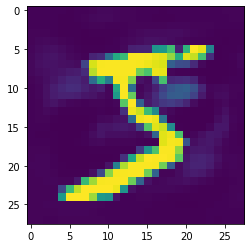

898
l2 dist: 1.2389171
target class:  3
pred of adv ex:  3


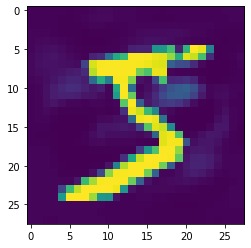

899
l2 dist: 1.2306818
target class:  3
pred of adv ex:  3


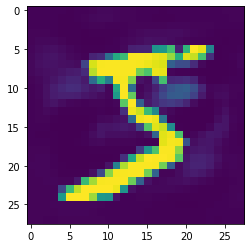

900
l2 dist: 1.2222165
target class:  3
pred of adv ex:  3


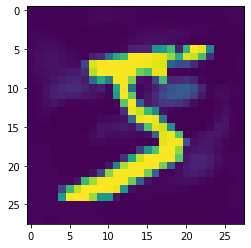

901
l2 dist: 1.2135689
target class:  3
pred of adv ex:  3


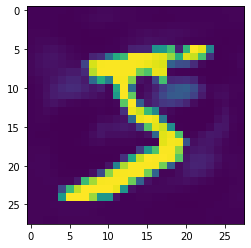

902
l2 dist: 1.2047794
target class:  3
pred of adv ex:  3


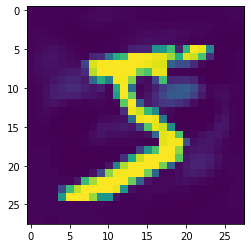

903
l2 dist: 1.1958822
target class:  3
pred of adv ex:  3


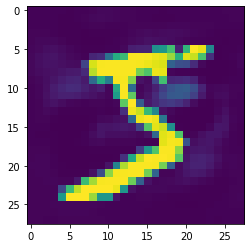

904
l2 dist: 1.1869078
target class:  3
pred of adv ex:  5


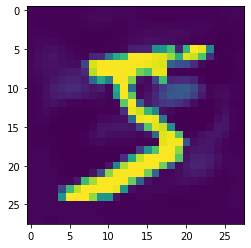

905
l2 dist: 1.2079519
target class:  3
pred of adv ex:  3


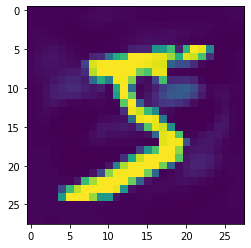

906
l2 dist: 1.2267317
target class:  3
pred of adv ex:  3


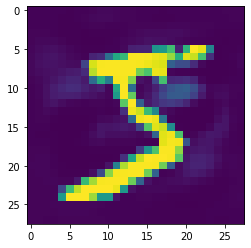

907
l2 dist: 1.2431419
target class:  3
pred of adv ex:  3


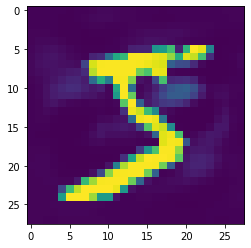

908
l2 dist: 1.2571303
target class:  3
pred of adv ex:  3


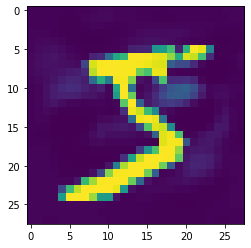

909
l2 dist: 1.2686987
target class:  3
pred of adv ex:  3


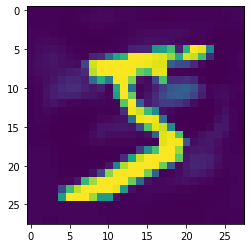

910
l2 dist: 1.2778995
target class:  3
pred of adv ex:  3


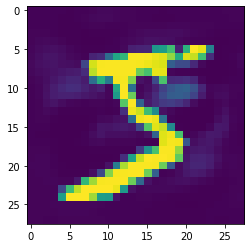

911
l2 dist: 1.2848301
target class:  3
pred of adv ex:  3


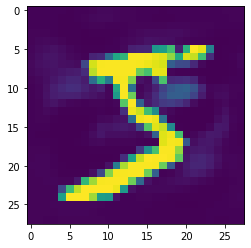

912
l2 dist: 1.289625
target class:  3
pred of adv ex:  3


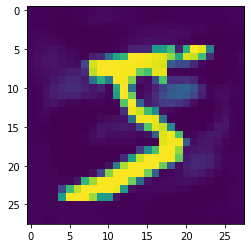

913
l2 dist: 1.2924457
target class:  3
pred of adv ex:  3


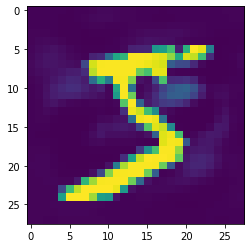

914
l2 dist: 1.2934697
target class:  3
pred of adv ex:  3


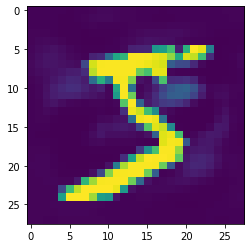

915
l2 dist: 1.2928834
target class:  3
pred of adv ex:  3


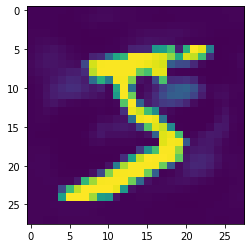

916
l2 dist: 1.2908716
target class:  3
pred of adv ex:  3


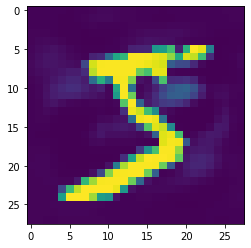

917
l2 dist: 1.2876134
target class:  3
pred of adv ex:  3


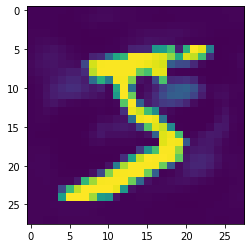

918
l2 dist: 1.2832776
target class:  3
pred of adv ex:  3


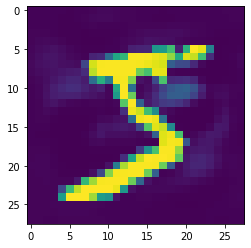

919
l2 dist: 1.2780197
target class:  3
pred of adv ex:  3


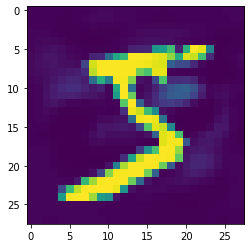

920
l2 dist: 1.2719803
target class:  3
pred of adv ex:  3


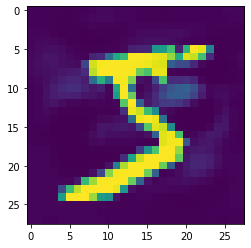

921
l2 dist: 1.2652858
target class:  3
pred of adv ex:  3


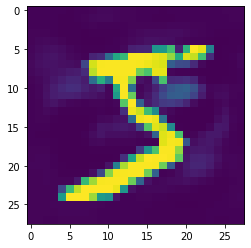

922
l2 dist: 1.2580475
target class:  3
pred of adv ex:  3


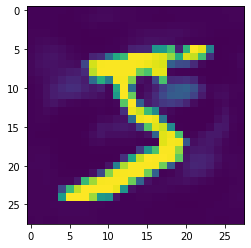

923
l2 dist: 1.2503622
target class:  3
pred of adv ex:  3


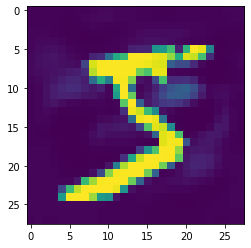

924
l2 dist: 1.2423124
target class:  3
pred of adv ex:  3


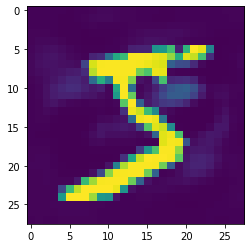

925
l2 dist: 1.233969
target class:  3
pred of adv ex:  3


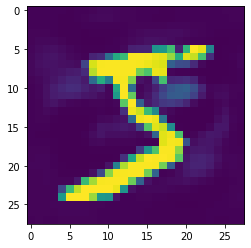

926
l2 dist: 1.2253908
target class:  3
pred of adv ex:  3


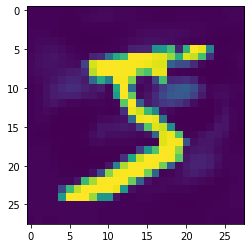

927
l2 dist: 1.2166271
target class:  3
pred of adv ex:  3


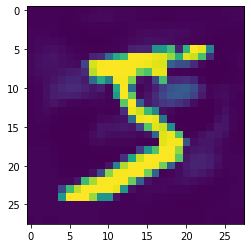

928
l2 dist: 1.2077193
target class:  3
pred of adv ex:  3


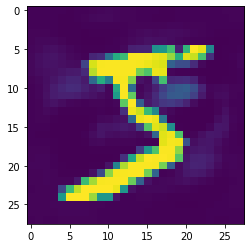

929
l2 dist: 1.198703
target class:  3
pred of adv ex:  3


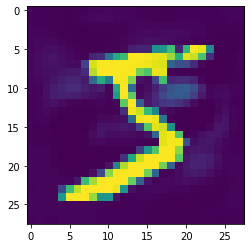

930
l2 dist: 1.189609
target class:  3
pred of adv ex:  3


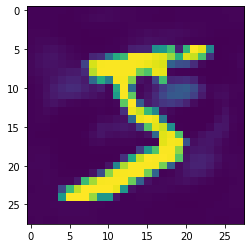

931
l2 dist: 1.1804653
target class:  3
pred of adv ex:  5


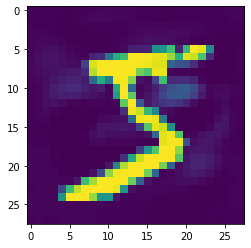

932
l2 dist: 1.2011158
target class:  3
pred of adv ex:  3


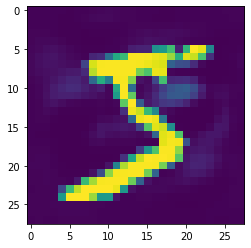

933
l2 dist: 1.219593
target class:  3
pred of adv ex:  3


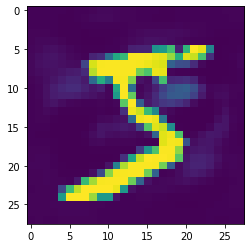

934
l2 dist: 1.2357756
target class:  3
pred of adv ex:  3


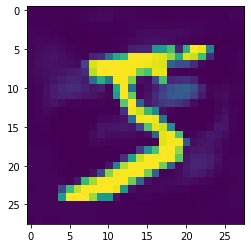

935
l2 dist: 1.2495955
target class:  3
pred of adv ex:  3


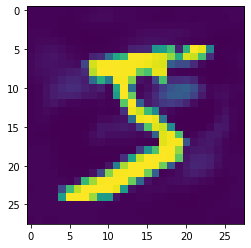

936
l2 dist: 1.2610408
target class:  3
pred of adv ex:  3


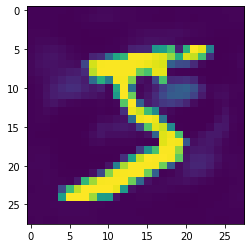

937
l2 dist: 1.2701523
target class:  3
pred of adv ex:  3


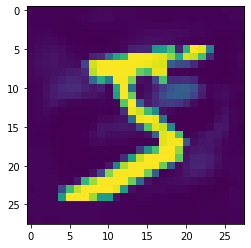

938
l2 dist: 1.2770185
target class:  3
pred of adv ex:  3


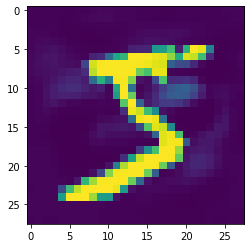

939
l2 dist: 1.281767
target class:  3
pred of adv ex:  3


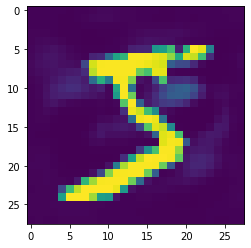

940
l2 dist: 1.2845545
target class:  3
pred of adv ex:  3


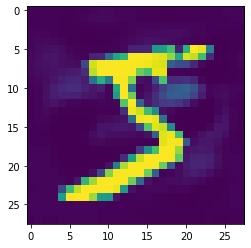

941
l2 dist: 1.2855562
target class:  3
pred of adv ex:  3


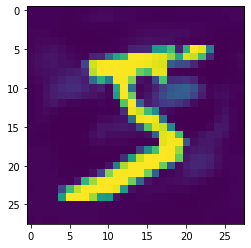

942
l2 dist: 1.2849562
target class:  3
pred of adv ex:  3


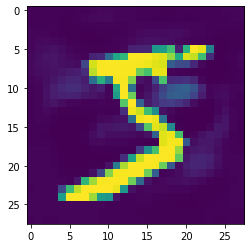

943
l2 dist: 1.2829399
target class:  3
pred of adv ex:  3


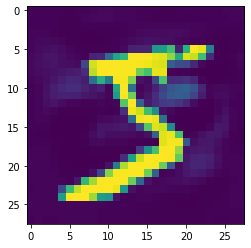

944
l2 dist: 1.2796866
target class:  3
pred of adv ex:  3


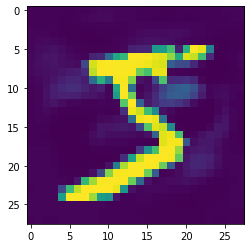

945
l2 dist: 1.2753654
target class:  3
pred of adv ex:  3


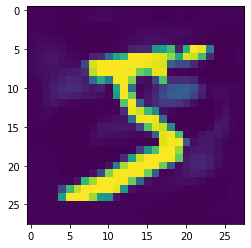

946
l2 dist: 1.2701323
target class:  3
pred of adv ex:  3


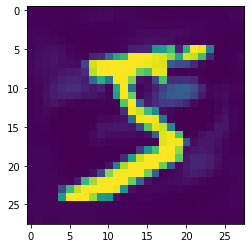

947
l2 dist: 1.2641293
target class:  3
pred of adv ex:  3


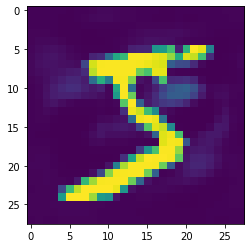

948
l2 dist: 1.257482
target class:  3
pred of adv ex:  3


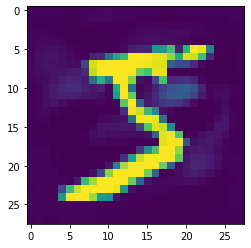

949
l2 dist: 1.2503014
target class:  3
pred of adv ex:  3


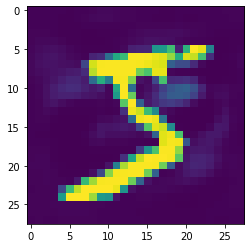

950
l2 dist: 1.242683
target class:  3
pred of adv ex:  3


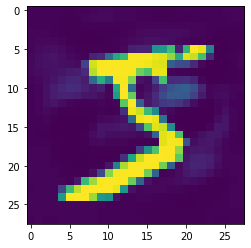

951
l2 dist: 1.2347084
target class:  3
pred of adv ex:  3


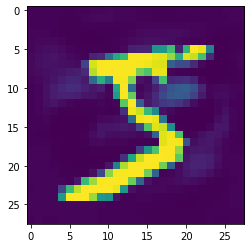

952
l2 dist: 1.2264466
target class:  3
pred of adv ex:  3


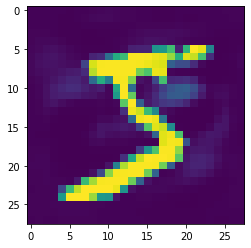

953
l2 dist: 1.2179543
target class:  3
pred of adv ex:  3


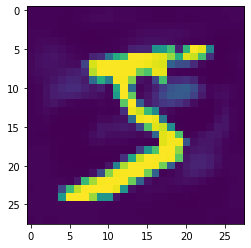

954
l2 dist: 1.2092795
target class:  3
pred of adv ex:  3


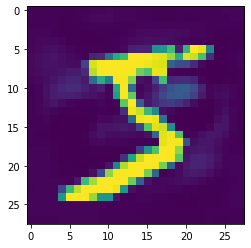

955
l2 dist: 1.2004622
target class:  3
pred of adv ex:  3


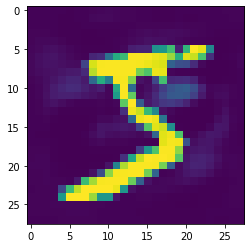

956
l2 dist: 1.1915363
target class:  3
pred of adv ex:  3


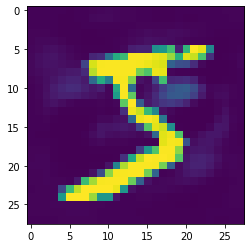

957
l2 dist: 1.1825324
target class:  3
pred of adv ex:  5


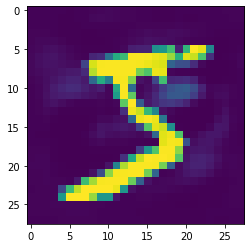

958
l2 dist: 1.2037184
target class:  3
pred of adv ex:  3


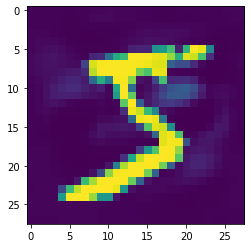

959
l2 dist: 1.2226418
target class:  3
pred of adv ex:  3


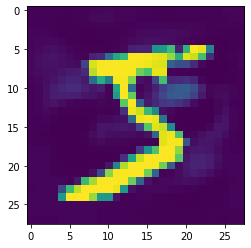

960
l2 dist: 1.23919
target class:  3
pred of adv ex:  3


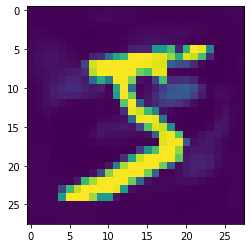

961
l2 dist: 1.2533036
target class:  3
pred of adv ex:  3


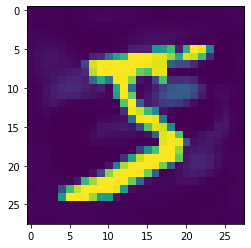

962
l2 dist: 1.2649796
target class:  3
pred of adv ex:  3


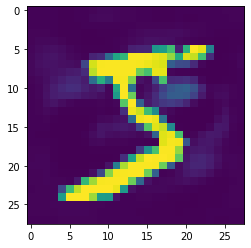

963
l2 dist: 1.2742678
target class:  3
pred of adv ex:  3


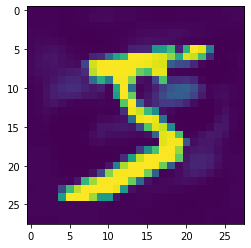

964
l2 dist: 1.2812649
target class:  3
pred of adv ex:  3


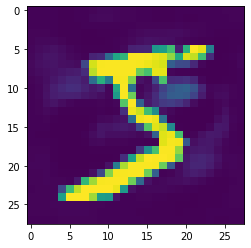

965
l2 dist: 1.2861061
target class:  3
pred of adv ex:  3


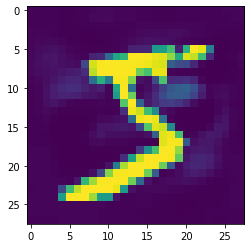

966
l2 dist: 1.288955
target class:  3
pred of adv ex:  3


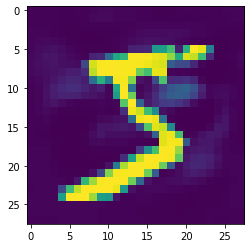

967
l2 dist: 1.2899922
target class:  3
pred of adv ex:  3


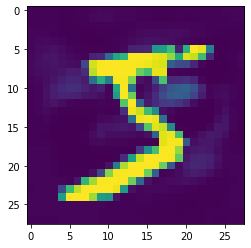

968
l2 dist: 1.2894064
target class:  3
pred of adv ex:  3


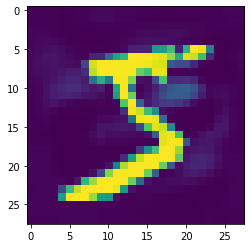

969
l2 dist: 1.2873856
target class:  3
pred of adv ex:  3


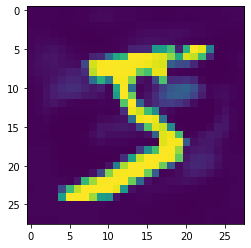

970
l2 dist: 1.2841115
target class:  3
pred of adv ex:  3


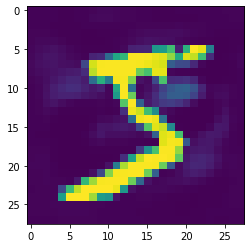

971
l2 dist: 1.2797543
target class:  3
pred of adv ex:  3


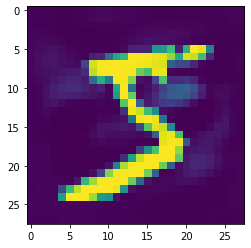

972
l2 dist: 1.2744709
target class:  3
pred of adv ex:  3


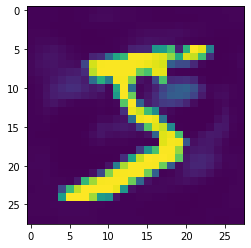

973
l2 dist: 1.2684039
target class:  3
pred of adv ex:  3


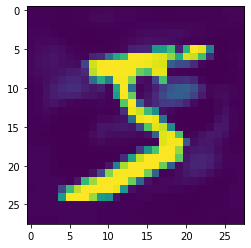

974
l2 dist: 1.26168
target class:  3
pred of adv ex:  3


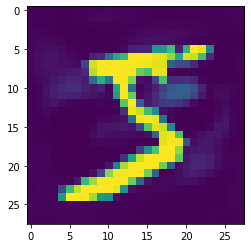

975
l2 dist: 1.254411
target class:  3
pred of adv ex:  3


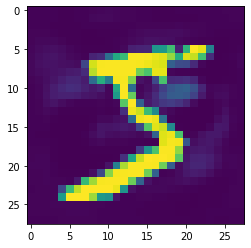

976
l2 dist: 1.2466942
target class:  3
pred of adv ex:  3


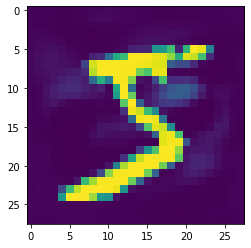

977
l2 dist: 1.238613
target class:  3
pred of adv ex:  3


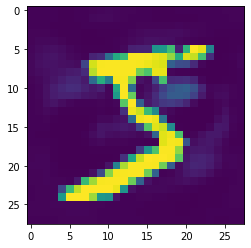

978
l2 dist: 1.2302377
target class:  3
pred of adv ex:  3


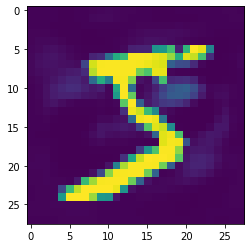

979
l2 dist: 1.2216276
target class:  3
pred of adv ex:  3


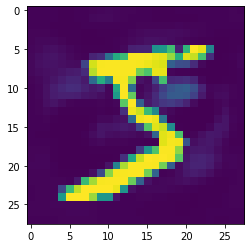

980
l2 dist: 1.2128316
target class:  3
pred of adv ex:  3


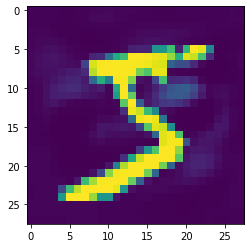

981
l2 dist: 1.2038915
target class:  3
pred of adv ex:  3


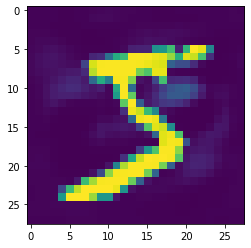

982
l2 dist: 1.1948422
target class:  3
pred of adv ex:  3


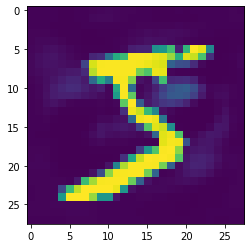

983
l2 dist: 1.185715
target class:  3
pred of adv ex:  3


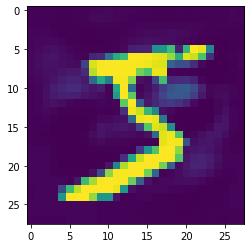

984
l2 dist: 1.1765378
target class:  3
pred of adv ex:  5


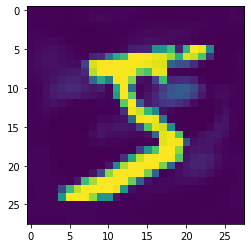

985
l2 dist: 1.1973357
target class:  3
pred of adv ex:  3


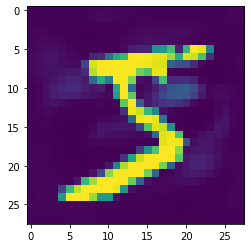

986
l2 dist: 1.2159624
target class:  3
pred of adv ex:  3


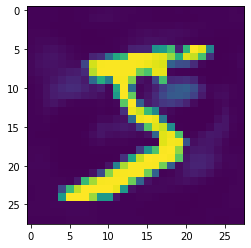

987
l2 dist: 1.2322884
target class:  3
pred of adv ex:  3


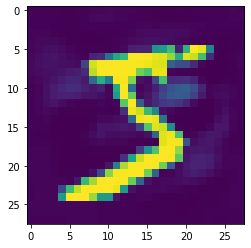

988
l2 dist: 1.2462387
target class:  3
pred of adv ex:  3


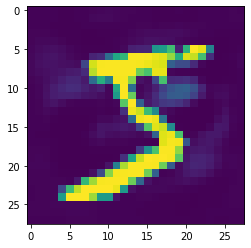

989
l2 dist: 1.2577962
target class:  3
pred of adv ex:  3


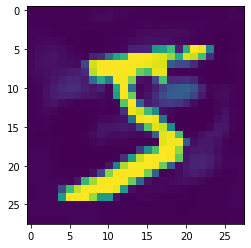

990
l2 dist: 1.266999
target class:  3
pred of adv ex:  3


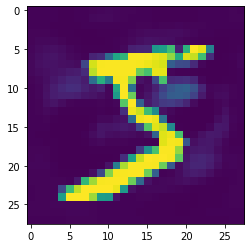

991
l2 dist: 1.2739347
target class:  3
pred of adv ex:  3


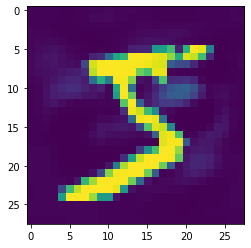

992
l2 dist: 1.278732
target class:  3
pred of adv ex:  3


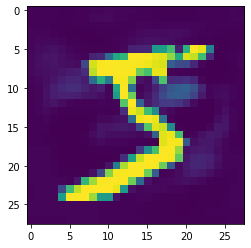

993
l2 dist: 1.2815497
target class:  3
pred of adv ex:  3


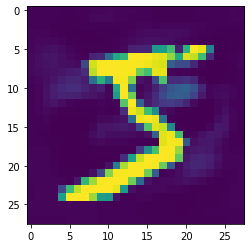

994
l2 dist: 1.2825656
target class:  3
pred of adv ex:  3


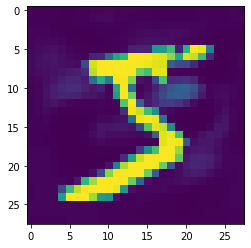

995
l2 dist: 1.2819675
target class:  3
pred of adv ex:  3


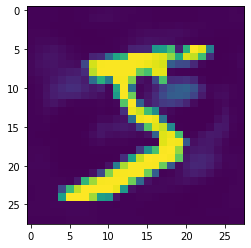

996
l2 dist: 1.279943
target class:  3
pred of adv ex:  3


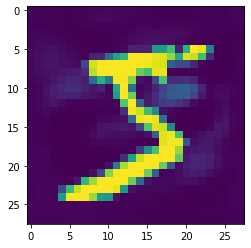

997
l2 dist: 1.2766739
target class:  3
pred of adv ex:  3


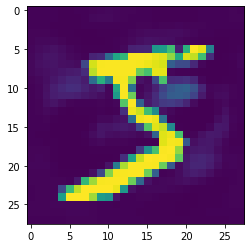

998
l2 dist: 1.2723315
target class:  3
pred of adv ex:  3


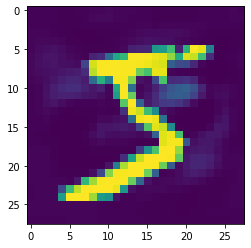

999
l2 dist: 1.2670733
target class:  3
pred of adv ex:  3


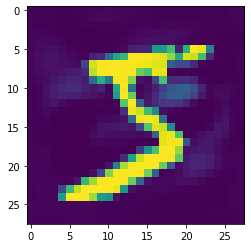

In [20]:
#x = tf.convert_to_tensor(tf.expand_dims(x_train[1], axis=0), tf.float32)
x = x_to_attack[0]
w = tf.Variable(initial_value=tf.zeros(x.shape))
CONST = 1

show_adv = []
optimizer = tf.keras.optimizers.Adam(.03)
target = find_second_most_probable_class(get_logits(model,x))

for i in range(1000):
    print(i)
    with tf.GradientTape() as tape:

        adv_image = .5 * (tf.tanh(w) + 1)
        #print(show_adv)
        preds = model(adv_image)
        const= CONST
        loss = loss_function(x=x, adv_image=adv_image, const=const, target=target)
        l2_distance = tf.norm(adv_image - x).numpy()
        grads = tape.gradient(loss, w)
        optimizer.apply_gradients([(grads, w)])
        print('l2 dist:', l2_distance)
        print('target class: ',target)
        print('pred of adv ex: ',np.argmax(model(adv_image)))
        plt.figure()
        plt.imshow(tf.reshape(adv_image, (28,28)))
        plt.show()
        #show_adv = adv_image
        #print('pred:',np.argmax(tf.nn.softmax(model(adv_image))))#
        #print(show_adv)
#print(show_adv)
#plt.show()
    

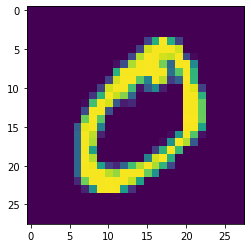

In [20]:
#plt.figure()
#plt.imshow(tf.reshape(adv_image, (28,28)))
#plt.show()
plt.figure()
plt.imshow(tf.reshape(x, (28,28)))
plt.show()

In [5]:
#w = tf.Variable(initial_value=tf.zeros(x.shape))
#x = tf.convert_to_tensor(tf.expand_dims(x_train[3], axis=0), tf.float32)

In [6]:
#
def to_attack_space(x, clip_max = 1, clip_min = 0):
    a = (clip_min + clip_max) / 2
    b = (clip_max - clip_min) / 2
    x = (x - a) / b # from (min, max) to (-1, 1)
    x = x * 0.9999999 #from (-1, 1) to ~(-1, 1)
    return tf.atanh(x) # from ~(-1, 1) to (-inf, inf)

def to_model_space(x, clip_max = 1, clip_min = 0):
    x = tf.tanh(x) # from (-inf, +inf) to (-1, 1)
    a = (clip_min + clip_max) / 2
    b = (clip_max - clip_min) / 2
    return x * b + a # from (-1, 1) to (clip_min, clip_max), (0, 1) mostly

def clip_tanh(x, clip_min, clip_max):
    x = (tf.tanh(x) + 1) / 2
    return x * (self.clip_max - self.clip_min) + self.clip_min

def find_second_most_probable_class(logits):
    logits = logits.numpy().flatten()
    return np.argpartition(logits,len(logits)-2)[len(logits)-2]

        


In [7]:
def get_least_probable(model, x):
    all_logits = get_logits(model, x)
    #print(all_logits)
    return tf.math.argmin(all_logits)


def get_logit_of_best_except_target(model, adv_x, target):
    all_logits = get_logits(model, adv_x)
    #print('all_logits', all_logits)
    most_probable_class = tf.math.argmax(all_logits)
    second_most_probable_class = find_second_most_probable_class(all_logits)
    if target == most_probable_class: 
        return all_logits[second_most_probable_class ]
    if target != most_probable_class: 
        return all_logits[most_probable_class ]

def get_logit_of_target(model, adv_x, target):
    all_logits = get_logits(model, adv_x)
    return all_logits[target]



• Average Case: select the target class uniformly at random
among the labels that are not the correct label. <br>
• Best Case: perform the attack against all incorrect classes,
and report the target class that was least difficult to attack. <br>
• Worst Case: perform the attack against all incorrect
classes, and report the target class that was most difficult
to attack.

In [8]:
def get_logits(model, x):
    
    model(x)
    
    return model.pre_softmax[0]
    

In [9]:
ds = tfds.load(name="imagenette", with_info=True, split=["train","validation"])
ds_train=ds[0][0]
ds_test=ds[0][1]
assert isinstance(ds_train, tf.data.Dataset)

def normalize(x):
    y = {'image': tf.image.convert_image_dtype(x['image'], tf.float32), 'label': x['label']}
    y = (tf.image.resize(y['image'], (224,224)), y['label'])
    return y
    
ds_train = ds_train.map(lambda x: normalize(x))
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(100)
ds_train = ds_train.batch(8)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(
    normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(8)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [10]:

def unroll(tensor, shape):
    return tf.transpose(tf.reshape(tensor, shape))

def roll_back(tensor, shape):
    return(tf.reshape(tf.transpose(tensor), shape))


shape=(50176,3)
y = unroll(x, shape)
print(y.shape)
shape=(224,224,3)
z = roll_back(y, shape)
print(z.shape)


plt.figure()
plt.imshow(z)
plt.show()

NameError: name 'x' is not defined

tf.Tensor(9, shape=(), dtype=int64)
(224, 224, 3)


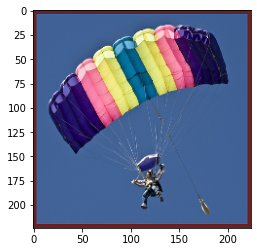

In [11]:
for z in ds_test.take(1):
    print(z[1][0])
    print(z[0][0].shape)
    x = z[0][0].numpy()
    tf.reshape
    plt.figure()
    plt.imshow(x)
    plt.show()

In [31]:
tfds.__version__

'1.2.0'

In [138]:
zzz = tf.Variable([1,2,3,4,5,6])
#print(np.argmin(zzz.numpy()))

0


In [522]:
model(x)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[1.6736643e-21, 3.1095958e-19, 1.2851257e-26, 6.1183505e-19,
        1.7574131e-11, 7.5577641e-15, 1.5379399e-28, 3.1209009e-13,
        2.4079222e-13, 1.0000000e+00]], dtype=float32)>

In [12]:
plt.figure()
plt.imshow(tf.reshape(x, (28,28)))
plt.show()

InvalidArgumentError: Input to reshape is a tensor with 150528 values, but the requested shape has 784 [Op:Reshape]

<Figure size 432x288 with 0 Axes>

In [533]:
d=[0,0,0,0,0,0,2]
e = tf.reduce_max(d).numpy()
f = tf.equal(e, d)
print(d)
print(e)
print(f)
print(tf.argmax(d).numpy())

[0, 0, 0, 0, 0, 0, 2]
2
tf.Tensor([False False False False False False  True], shape=(7,), dtype=bool)
6


# Define and Train Model

## Definiton of MLP DNN

In [13]:
class CustomLayer(layers.Layer):

    def __init__(self, units=32, activation='relu', input_shape=(784)):
        super(CustomLayer, self).__init__()
        self.units = units
        self.activation = activation
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True,
                                 name='weight'
                                )
        self.mask = self.add_weight(shape=(self.w.shape),
                                    initializer='ones',
                                    trainable=False,
                                    name='mask'
                                   )
        self.pruned_w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='ones',
                                 trainable=False,
                                 name='pruned_weights'
                                )

   
    def call(self, inputs):
        #self.mask_2 = tf.multiply(self.mask, self.mask_2)
        self.pruned_w = tf.multiply(self.w, self.mask)
        #print('layer inputy', inputs.shape)
        x = tf.matmul(inputs, self.pruned_w)
        
        if self.activation == 'relu':
            return tf.keras.activations.relu(x)
        if self.activation == 'softmax':
            return tf.keras.activations.softmax(x)
        if self.activation == None:
            return x
            
        raise ValueError('Activation function not implemented')


class LeNet300_100(tf.keras.Model):
    def __init__(self):
        super(LeNet300_100, self).__init__()
        self.dense1 = CustomLayer(300, input_shape=(None, 784))
        self.dense2 = CustomLayer(100, input_shape=(None, 300))
        self.dense3 = CustomLayer(10, activation=None, input_shape=(None, 100))
        
    def call(self, inputs):
        #print('NN call',inputs.shape)
        x = tf.keras.layers.Flatten()(inputs)
        x = self.dense1(x)
        
        x = self.dense2(x)
        x = self.dense3(x)
        self.pre_softmax = x
        return tf.keras.activations.softmax(x)
        #return x
    


In [14]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255


In [4]:
def ld_mnist():
    """Load training and test data."""

    def convert_types(image, label):
        image = tf.cast(image, tf.float32)
        image /= 255
        return image, label

    dataset, info = tfds.load('mnist', 
                              data_dir='gs://tfds-data/datasets', 
                              with_info=True,
                              as_supervised=True)
    mnist_train, mnist_test = dataset['train'], dataset['test']
    mnist_train = mnist_train.map(convert_types).shuffle(10000).batch(128)
    mnist_test = mnist_test.map(convert_types).batch(128)
    return EasyDict(train=mnist_train, test=mnist_test)
data = ld_mnist()

In [5]:
def initialize_model():
    model = LeNet300_100()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) ,
                  metrics=['accuracy'],
                  experimental_run_tf_function=False
                 )
    return model

def train_model(model):
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    model.fit(x=data.train,
              #batch_size=64,
              epochs=500,
              callbacks=[callback],
              validation_data=(x_test, y_test),
             )


In [6]:
model = initialize_model()
train_model(model)

Epoch 1/500
469/469 [==============================] - 11s 24ms/step - loss: 1.6066 - accuracy: 0.8722 - val_loss: 1.5303 - val_accuracy: 0.9357
Epoch 2/500
469/469 [==============================] - 9s 18ms/step - loss: 1.5218 - accuracy: 0.9437 - val_loss: 1.5121 - val_accuracy: 0.9516
Epoch 3/500
469/469 [==============================] - 8s 17ms/step - loss: 1.5052 - accuracy: 0.9586 - val_loss: 1.5018 - val_accuracy: 0.9612
Epoch 4/500
469/469 [==============================] - 8s 17ms/step - loss: 1.4964 - accuracy: 0.9672 - val_loss: 1.4967 - val_accuracy: 0.9657
Epoch 5/500
469/469 [==============================] - 7s 16ms/step - loss: 1.4910 - accuracy: 0.9719 - val_loss: 1.4947 - val_accuracy: 0.9680
Epoch 6/500
469/469 [==============================] - 8s 16ms/step - loss: 1.4867 - accuracy: 0.9760 - val_loss: 1.4919 - val_accuracy: 0.9701
Epoch 7/500
469/469 [==============================] - 8s 17ms/step - loss: 1.4826 - accuracy: 0.9800 - val_loss: 1.4885 - val_accuracy

# CNN-5

In [15]:
shapes = {
    # 5x5 conv, 1 input, 6 outputs
    'conv_1': (5, 5, 1, 6),
    # 5x5 conv, 6 inputs, 16 outputs
    'conv_2': (5, 5, 6, 16),
    #5x5 conv as in paper, 16 inputs, 120 outputs
    'conv_3': (1, 1, 16, 120),
    # fully connected, 5*5*16 inputs, 120 outputs
    'dense_1': (5*5*16, 120),
    # fully connected, 120 inputs, 84 outputs
    'dense_2': (120, 84),
    # 84 inputs, 10 outputs (class prediction)
    'dense_3': (84, 10),
}
bias_shapes = {
    #output depth
    'conv_1': (6),
    'conv_2': (16),
    'dense_1': (120),
    'dense_2': (84),
    'dense_3': (10),
}

#conv2D with bias and relu activation

class CustomConvLayer(layers.Layer):

    def __init__(self, weights, mask, biases, strides, padding='SAME'):
        
        super(CustomConvLayer, self).__init__()
        self.w = weights
        self.m = mask
        self.b = biases
        self.s = strides
        self.p = padding

        
    def call(self, inputs):
        x = tf.nn.conv2d(inputs, tf.multiply(self.w, self.m), strides=[1, self.s, self.s, 1], padding=self.p,)# data_format='NCHW')
        x = tf.nn.bias_add(x, self.b,)# 'NC...')
        return tf.nn.tanh(x)
        

#Average Pooling Layer
class CustomPoolLayer(layers.Layer):
    
    def __init__(self, k=2, padding='valid'):#padding='VALID'):
        super(CustomPoolLayer, self).__init__()
        self.k = k
        self.p = padding
    
    def call(self, inputs):
#        return tf.keras.layers.AveragePooling2D(pool_size=(self.k, self.k), strides=None, padding=self.p, data_format='channels_first')(inputs)
        return tf.nn.avg_pool2d(inputs, ksize=[1, self.k, self.k,1], strides=[1, self.k, self.k, 1], padding=self.p,)# data_format='NCHW')
    

        
class CustomConvLayer(layers.Layer):

    def __init__(self, shape, bias, strides, padding='SAME'):
        
        super(CustomConvLayer, self).__init__()
        self.w = self.add_weight(
            shape=shape,
            initializer='random_normal',
            trainable=True,
            name='w'
        )
        self.m = self.add_weight(
            shape=shape,
            initializer='ones',
            trainable=False,
            name='m'
        )
        self.b = self.add_weight(
            shape = (shape[-1]),
            initializer = 'zeros',
            trainable = True,
            name='b'
        )
        self.s = strides
        self.p = padding

        
    def call(self, inputs):
        x = tf.nn.conv2d(inputs, tf.multiply(self.w, self.m), strides=[1, self.s, self.s, 1], padding=self.p,)# data_format='NCHW')
        x = tf.nn.bias_add(x, self.b,)# 'NC...')
        return tf.nn.tanh(x)

#Dense Layer with Bias
class CustomDenseLayer(layers.Layer):
    def __init__(self, shape, bias, activation = 'tanh'):
        super(CustomDenseLayer, self).__init__()
        self.w = self.add_weight(
            shape = shape,
            initializer='random_normal',
            trainable = True,
            name='w'
        )
        self.m = self.add_weight(
            shape = shape,
            initializer='ones',
            trainable = False,
            name='m'
        )
        self.b = self.add_weight(
            shape = (shape[-1]),
            initializer = 'zeros',
            trainable = True,
            name='b'
        )
        self.a = activation
        
        
    def call(self, inputs):
        x = tf.matmul(inputs, tf.multiply(self.w, self.m))
        x = tf.nn.bias_add(x, self.b)
        if self.a == 'tanh':
            return tf.nn.tanh(x)
        if self.a == 'softmax':
            return tf.nn.softmax(x)
        if self.a == None:
            return x
        
        
        
class CustomConvModel(tf.keras.Model):
    def __init__(self):
        super(CustomConvModel, self).__init__()
        self.conv1 = CustomConvLayer(shapes['conv_1'], True, 1, 'SAME')#'VALID')
        self.maxpool1 = CustomPoolLayer(k=2, padding='SAME')
        self.conv2 = CustomConvLayer(shapes['conv_2'], True, 1, 'VALID')
        self.maxpool2 = CustomPoolLayer(k=2, padding='VALID')

        self.dense1 = CustomDenseLayer(shapes['dense_1'], True, 'tanh')
        self.dense2 = CustomDenseLayer(shapes['dense_2'], True, 'tanh')
        self.dense3 = CustomDenseLayer(shapes['dense_3'], True, None)
        self.pre_softmax = None
        
    def call(self, inputs):
        x = tf.reshape(inputs, shape=[-1,28, 28, 1])
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = layers.Flatten()(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x =  self.dense3(x)
        self.pre_softmax = x
        return tf.nn.softmax(x)
    
    def prune_random_local_unstruct(self, ratio):
        def prune_conv_layers_locally(self, ratio):
            conv_layer_to_prune = [0, 3]
            weights = self.get_weights()
            for layer in conv_layer_to_prune:
                converted_weights = convert_from_hwio_to_iohw(weights[layer]).numpy()
                converted_mask = convert_from_hwio_to_iohw(weights[layer + 2]).numpy()
                for input_index, input_layer in enumerate(converted_weights):
                    for kernel_index, kernel in enumerate(input_layer):
                        shape = kernel.shape
                        flat_weights = kernel.flatten()
                        flat_masks = converted_mask[input_index][kernel_index].flatten()
                        
                        no_of_weighs_to_prune = ratio * len(flat_weights)
                        # find unpruned weights
                        non_zero_weights = np.nonzero(flat_masks)[0]
                        # calculate the amount of weights to be pruned this round
                        no_of_weights_to_prune_left = int(no_of_weighs_to_prune - (len(flat_weights) - len(non_zero_weights)) )
                        # shuffle all non-zero weights
                        random.shuffle(non_zero_weights)
                        # and take the indices of the first x weights where x is the number of weights to be pruned this round
                        indices_to_delete = non_zero_weights[:no_of_weights_to_prune_left]
                        
                        for idx_to_delete in indices_to_delete:
                            flat_masks[idx_to_delete] = 0
                            flat_weights[idx_to_delete] = 0
                        converted_mask[input_index][kernel_index] = flat_masks.reshape(shape)
                        converted_weights[input_index][kernel_index] = flat_weights.reshape(shape)
                back_converted_mask = convert_from_iohw_to_hwio(converted_mask)
                back_converted_weights = convert_from_iohw_to_hwio(converted_weights)
                weights[layer] = back_converted_weights
                weights[layer+2] = back_converted_mask
            self.set_weights(weights)
            return True
        
        def prune_dense_layers_locally(self, ratio):
            dense_layer_to_prune = [6, 9, 12]
            weights = self.get_weights()
            for index, weight in enumerate(weights):
                if index in dense_layer_to_prune:
                    shape = weight.shape
                    flat_weights = weight.flatten()
                    flat_mask = weights[index+2].flatten()
                    no_of_weighs_to_prune = ratio * len(flat_weights)
                    # find unpruned weights
                    non_zero_weights = np.nonzero(flat_mask)[0]
                    # calculate the amount of weights to be pruned this round
                    no_of_weights_to_prune_left = int(no_of_weighs_to_prune - (len(flat_weights) - len(non_zero_weights)) )
                    # shuffle all non-zero weights
                    random.shuffle(non_zero_weights)
                    # and take the indices of the first x weights where x is the number of weights to be pruned this round
                    indices_to_delete = non_zero_weights[:no_of_weights_to_prune_left]
                    for idx_to_delete in indices_to_delete:
                        flat_mask[idx_to_delete] = 0
                        flat_weights[idx_to_delete] = 0

                    mask_reshaped = flat_mask.reshape(shape)
                    weights_reshaped = flat_weights.reshape(shape)
                    weights[index+2] = mask_reshaped
                    weights[index] = weights_reshaped
            self.set_weights(weights)
            return True
        prune_conv_layers_locally(self, ratio)
        prune_dense_layers_locally(self,ratio)
    
    def prune_magnitude_global_unstruct(self, ratio):
        #flat out all weights:
        conv_layer_to_prune = [0, 3]
        dense_layer_to_prune = [6, 9, 12]
        weights = self.get_weights()
        flat_weights = []
        flat_mask = []
        for x in conv_layer_to_prune + dense_layer_to_prune:
            flat_weights = np.append(flat_weights, weights[x])
            flat_mask = np.append(flat_mask, weights[x+2])
            
        no_of_weights_to_prune = int(len(flat_weights)*ratio)
        indices_to_delete = np.abs(flat_weights).argsort(0)[:no_of_weights_to_prune]
        
        for idx_to_delete in indices_to_delete:
            flat_mask[idx_to_delete] = 0
            flat_weights[idx_to_delete] = 0
        z = 0
        for x in conv_layer_to_prune + dense_layer_to_prune:
            weights[x] = flat_weights[z:z + np.prod(weights[x].shape)].reshape(weights[x].shape)
            weights[x + 2] = flat_mask[z:z + np.prod(weights[x].shape)].reshape(weights[x].shape)
            z = z + np.prod(weights[x].shape)            
        self.set_weights(weights)
        
        
            
        
        
    
    def prune_magnitude_local_unstruct(self, ratio):
        def prune_conv_layers_locally(self, ratio):
            conv_layer_to_prune = [0, 3]
            #print('inside conv prune func',get_zeros_ratio(self.get_weights()))
            weights = self.get_weights()
            
            for layer in conv_layer_to_prune:
                converted_weights = convert_from_hwio_to_iohw(weights[layer]).numpy()
                converted_mask = convert_from_hwio_to_iohw(weights[layer + 2]).numpy()
                for input_index, input_layer in enumerate(converted_weights):
                    for kernel_index, kernel in enumerate(input_layer):
                        shape = kernel.shape
                        flat_weights = kernel.flatten()
                        flat_masks = converted_mask[input_index][kernel_index].flatten()
                        #flat_weights_df = pd.DataFrame(flat_weights)
                        #flat_mask_df = pd.DataFrame(flat_masks)
                        no_of_weights_to_prune = int(len(flat_weights)*ratio)
                        #print(no_of_weights_to_prune)
                        #indices_to_delete = flat_weights_df.abs().values.argsort(0)[:no_of_weights_to_prune]
                        indices_to_delete = np.abs(flat_weights).argsort(0)[:no_of_weights_to_prune]


                        for idx_to_delete in indices_to_delete:
                            flat_masks[idx_to_delete] = 0
                            flat_weights[idx_to_delete] = 0

                        converted_mask[input_index][kernel_index] = flat_masks.reshape(shape)
                        converted_weights[input_index][kernel_index] = flat_weights.reshape(shape)
                back_converted_mask = convert_from_iohw_to_hwio(converted_mask)
                back_converted_weights = convert_from_iohw_to_hwio(converted_weights)
                weights[layer] = back_converted_weights
                weights[layer+2] = back_converted_mask
            self.set_weights(weights)
            return True
        
        def prune_dense_layers_locally(self, ratio):
            
            dense_layer_to_prune = [6, 9, 12]
            weights = self.get_weights()
            for index, weight in enumerate(weights):
                if index in dense_layer_to_prune:
                    shape = weight.shape
                    flat_weights = weight.flatten()
                    flat_mask = weights[index+2].flatten()

                    no_of_weights_to_prune = int(len(flat_weights)*ratio)
                    indices_to_delete = np.abs(flat_weights).argsort()[:no_of_weights_to_prune]
                    for idx_to_delete in indices_to_delete:
                        flat_mask[idx_to_delete] = 0
                        flat_weights[idx_to_delete] = 0
                    mask_reshaped = flat_mask.reshape(shape)
                    weights_reshaped = flat_weights.reshape(shape)
                    weights[index+2] = mask_reshaped
                    weights[index] = weights_reshaped
            self.set_weights(weights)
            return True
        prune_conv_layers_locally(self,ratio)
        prune_dense_layers_locally(self,ratio)
        return
    
    def prune_random_local_struct(self, ratio):
        def prune_conv_layers(conv_layers_to_prune, weights):
            for x in conv_layers_to_prune:

                vals = []
                iohw_weights = convert_from_hwio_to_iohw(weights[x])
                iohw_mask = convert_from_hwio_to_iohw(weights[x+2])
                converted_shape = iohw_weights.shape
                no_of_channels = converted_shape[0]*converted_shape[1]
                no_of_channels_to_prune = int(np.round(ratio * no_of_channels))
                channels = tf.reshape(iohw_weights, (no_of_channels,converted_shape[2],converted_shape[3])).numpy()
                #print(channels)
                non_zero_channels = np.nonzero([np.sum(channel) for channel in channels])[0]
                #print(non_zero_channels)
                no_of_channels_to_prune_left = no_of_channels_to_prune - (len(channels) - len(non_zero_channels))
                random.shuffle(non_zero_channels)
                channels_to_prune = non_zero_channels[:no_of_channels_to_prune_left]
                mask = tf.reshape(iohw_mask, (no_of_channels,converted_shape[2],converted_shape[3])).numpy()

                for channel_to_prune in channels_to_prune:
                    channels[channel_to_prune] = tf.zeros([converted_shape[2],converted_shape[3]])
                    mask[channel_to_prune] = tf.zeros([converted_shape[2],converted_shape[3]])

                reshaped_mask = tf.reshape(mask, converted_shape)
                reshaped_weights = tf.reshape(channels, converted_shape)
                weights[x] = convert_from_iohw_to_hwio(reshaped_weights)
                weights[x+2] = convert_from_iohw_to_hwio(reshaped_mask)
            #self.set_weights(weights)
            return True
        def prune_dense_layers(dense_layers_to_prune, weights):
            for layer_to_prune in dense_layers_to_prune:
                rows = weights[layer_to_prune]
                no_of_rows_to_prune = int(ratio * len(weights[layer_to_prune]))
                non_zero_rows = np.nonzero([np.sum(row) for row in rows])[0]
                no_of_rows_to_prune_left = no_of_rows_to_prune - (len(rows) - len(non_zero_rows))
                random.shuffle(non_zero_rows)
                rows_to_prune = non_zero_rows[:no_of_rows_to_prune_left]
                
                for row_to_prune in rows_to_prune:
                    weights[layer_to_prune][row_to_prune] = tf.zeros(len(weights[layer_to_prune][row_to_prune]))
                    weights[layer_to_prune+2][row_to_prune] = tf.zeros(len(weights[layer_to_prune][row_to_prune]))
            return True
        weights = self.get_weights()
        conv_layers_to_prune = [0,3]
        dense_layers_to_prune = [6,9,12]
        prune_conv_layers(conv_layers_to_prune, weights)
        prune_dense_layers(dense_layers_to_prune, weights)
        self.set_weights(weights)
        return True

    def prune_random_global_struct(self, ratio):
        raise Warning('Not yet implemented')
        return False
    def prune_magnitude_local_struct(self, ratio):
        def prune_conv_layers(conv_layers_to_prune, weights):
            for x in conv_layers_to_prune:

                vals = []
                iohw_weights = convert_from_hwio_to_iohw(weights[x])
                iohw_mask = convert_from_hwio_to_iohw(weights[x+2])
                converted_shape = iohw_weights.shape
                no_of_channels = converted_shape[0]*converted_shape[1]
                no_of_channels_to_prune = int(np.round(ratio * no_of_channels))
                channels = tf.reshape(iohw_weights, (no_of_channels,converted_shape[2],converted_shape[3])).numpy()
                
                mask = tf.reshape(iohw_mask, (no_of_channels,converted_shape[2],converted_shape[3])).numpy()
                for channel in channels:
                    vals.append(tf.math.reduce_sum(tf.math.abs(channel)))
                channels_to_prune = np.argsort(vals)[:no_of_channels_to_prune]

                for channel_to_prune in channels_to_prune:
                    channels[channel_to_prune] = tf.zeros([converted_shape[2],converted_shape[3]])
                    mask[channel_to_prune] = tf.zeros([converted_shape[2],converted_shape[3]])

                reshaped_mask = tf.reshape(mask, converted_shape)
                reshaped_weights = tf.reshape(channels, converted_shape)
                weights[x] = convert_from_iohw_to_hwio(reshaped_weights)
                weights[x+2] = convert_from_iohw_to_hwio(reshaped_mask)
            #self.set_weights(weights)
            return weights
        def prune_dense_layers(dense_layers_to_prune, weights):
            for layer_to_prune in dense_layers_to_prune:
                no_of_rows_to_prune = int(ratio * len(weights[layer_to_prune]))
                vals = []
                for row in weights[layer_to_prune]:
                    vals.append(np.sum(np.abs(row)))
                rows_to_prune = np.argsort(vals)[:no_of_rows_to_prune]
                for row_to_prune in rows_to_prune:

                    weights[layer_to_prune][row_to_prune] = tf.zeros(len(weights[layer_to_prune][row_to_prune]))
                    weights[layer_to_prune+2][row_to_prune] = tf.zeros(len(weights[layer_to_prune][row_to_prune]))
            return weights
        weights = self.get_weights()
        conv_layers_to_prune = [0,3]
        dense_layers_to_prune = [6,9,12]
        weights = prune_conv_layers(conv_layers_to_prune, weights)
        weights = prune_dense_layers(dense_layers_to_prune, weights)
        self.set_weights(weights)
        return True
        
    def prune_magnitude_global_struct(self, ratio):
        def prune_conv_layers(conv_layers_to_prune, weights):
            all_channels = np.empty((0,5,5))
            original_shapes = []
            for layer_to_prune in conv_layers_to_prune:
                iohw_weights = convert_from_hwio_to_iohw(weights[layer_to_prune])
                converted_shape = iohw_weights.shape
                no_of_channels = converted_shape[0]*converted_shape[1]
                channels = tf.reshape(iohw_weights, (no_of_channels,converted_shape[2],converted_shape[3])).numpy()
                all_channels = np.concatenate((all_channels, channels))
            mask = np.ones(all_channels.shape)
            vals = [np.sum(np.abs(channel)) for channel in all_channels]
            no_of_channels_to_prune = int(ratio * len(vals))
            channels_to_prune = np.argsort(vals)[:no_of_channels_to_prune]

            for channel_to_prune in channels_to_prune:
                all_channels[channel_to_prune] = tf.zeros((5,5))
                mask[channel_to_prune] = tf.zeros((5,5))
            z = 0
            for i, layer_to_prune in enumerate(conv_layers_to_prune):
                original_shape = convert_from_hwio_to_iohw(weights[layer_to_prune]).shape
                pruned_layer = tf.reshape(all_channels[z:z + original_shape[0]*original_shape[1]], original_shape)
                pruned_mask = tf.reshape(mask[z:z + original_shape[0]*original_shape[1]], original_shape)
                weights[layer_to_prune] = convert_from_iohw_to_hwio(pruned_layer)
                weights[layer_to_prune + 2] = convert_from_iohw_to_hwio(pruned_mask)
                z = original_shape[0]*original_shape[1]    
            return weights
        
        def prune_dense_layers(dense_layers_to_prune, weights):
            vals = []
            lengths = []
            for layer_to_prune in dense_layers_to_prune:
                lengths.append(weights[layer_to_prune].shape[0])
                vals = vals + [np.sum(np.abs(row)) / len(row) for row in weights[layer_to_prune]]
            no_of_rows_to_prune = int(ratio * len(vals))
            rows_to_prune = np.argsort(vals)[:no_of_rows_to_prune]
            for i, layer_to_prune in enumerate(dense_layers_to_prune):
                for row_to_prune in rows_to_prune:
                    if row_to_prune in range(int(np.sum(lengths[:i])), int(np.sum(lengths[:i+1]))):
                        weights[layer_to_prune][row_to_prune - int(np.sum(lengths[:i]))] = tf.zeros(weights[layer_to_prune][row_to_prune - int(np.sum(lengths[:i]))].shape)
                        weights[layer_to_prune + 2][row_to_prune - int(np.sum(lengths[:i]))] = tf.zeros(weights[layer_to_prune][row_to_prune - int(np.sum(lengths[:i]))].shape)                
            return weights
        weights = self.get_weights()
        conv_layers_to_prune = [0,3]
        dense_layers_to_prune = [6,9,12]
        weights = prune_conv_layers(conv_layers_to_prune, weights)
        weights = prune_dense_layers(dense_layers_to_prune, weights)
        self.set_weights(weights)
        return True

        


In [16]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

x_to_attack = tf.convert_to_tensor(x_train[:10].reshape(10,28*28))
y_to_attack = tf.convert_to_tensor([y_train[:10]])[0];

In [17]:
def train_model(model, to_convergence=True):
    if to_convergence == True:
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
        model.fit(
            x=x_train,
            y=y_train,
            batch_size=64,
            epochs=500,
            callbacks=[callback],
            validation_data=(x_test, y_test),
            )
    if to_convergence == False:
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
        model.fit(
            x=x_train,
            y=y_train,
            batch_size=64,
            epochs=100,
            callbacks=[callback],
            validation_data=(x_test, y_test),
            )
    return model
def initialize_base_model(index, experiment_name, save_weights=False):

    model = CustomConvModel()

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) ,
                  metrics=['accuracy'],
                  experimental_run_tf_function=False
                 )

    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    model.fit(x=x_train,
              y=y_train,
              batch_size=64,
              epochs=1,
              callbacks=[callback],
              validation_data=(x_test, y_test),
             )
    if save_weights == True:
        model.save_weights(f'./saved-weights/{experiment_name}-{index}')
    return model


In [18]:
model = initialize_base_model(999,'')
train_model(model)

938/938 [==============================] - 3s 3ms/step - loss: 1.5915 - accuracy: 0.8869 - val_loss: 1.5121 - val_accuracy: 0.9519
Epoch 1/500
938/938 [==============================] - 2s 3ms/step - loss: 1.5051 - accuracy: 0.9595 - val_loss: 1.4991 - val_accuracy: 0.9661
Epoch 2/500
938/938 [==============================] - 2s 3ms/step - loss: 1.4923 - accuracy: 0.9711 - val_loss: 1.4900 - val_accuracy: 0.9734
Epoch 3/500
938/938 [==============================] - 2s 3ms/step - loss: 1.4857 - accuracy: 0.9771 - val_loss: 1.4853 - val_accuracy: 0.9779
Epoch 4/500
938/938 [==============================] - 2s 3ms/step - loss: 1.4817 - accuracy: 0.9807 - val_loss: 1.4864 - val_accuracy: 0.9765
Epoch 5/500
938/938 [==============================] - 2s 3ms/step - loss: 1.4792 - accuracy: 0.9831 - val_loss: 1.4827 - val_accuracy: 0.9798
Epoch 6/500
938/938 [==============================] - 2s 3ms/step - loss: 1.4780 - accuracy: 0.9841 - val_loss: 1.4811 - val_accuracy: 0.9808
Epoch 7/500